In [13]:
# === CONFIG ===
DATA_DIR = "outputs"

# Filenames (adjust if yours differ)
CSV_TOTAL_SPILLOVER = f"{DATA_DIR}/rolling/rolling_total_H10_W250_S5_fixed.csv"           # must have columns: [Date, Total_Spillover]
CSV_NET = f"{DATA_DIR}/rolling/rolling_net_H10_W250_S5_fixed.csv"               # Date + per-asset NET columns
CSV_VOL = f"{DATA_DIR}/all_assets_conditional_vol.csv"                  # Date + per-asset vols
CSV_DCC = f"{DATA_DIR}/dcc_correlations.csv"                            # Date + avg_dcc or pairwise; we’ll take average if provided per-pair
CSV_REGIME_MS = f"{DATA_DIR}/regime_switching/regime_labels_trackA.csv"                  # Date + Regime_MS (e.g., {0,1,2} or labels)
CSV_REGIME_SEG = f"{DATA_DIR}/trackC_segments.csv"                      # Date + Regime_SegID


# Modeling config
HORIZON = 5           # predict Total_Spillover at t+HORIZON
LAGS = list(range(1, 21))  # 1..20-day lags
SEQ_LEN = 60          # LSTM input window
TEST_SIZE = 0.15
VAL_SIZE = 0.15
RANDOM_SEED = 42
USE_GPU = False       # set True if TF GPU is available


(968, 19)
(943, 343)
Splits -> train:682  val:120  test:141
Baseline    RMSE=2.180  MAE=1.731  R2=0.776  DirChange=0.511
XGB raw     RMSE=5.072  MAE=4.230  R2=-0.214  DirChange=0.467
XGB residual RMSE=1.973  MAE=1.691  R2=0.816  DirChange=0.555
Sign(Δ) accuracy: 0.500
Baseline: shape (138,)
XGB raw: shape (138,)
XGB residual: shape (138,)


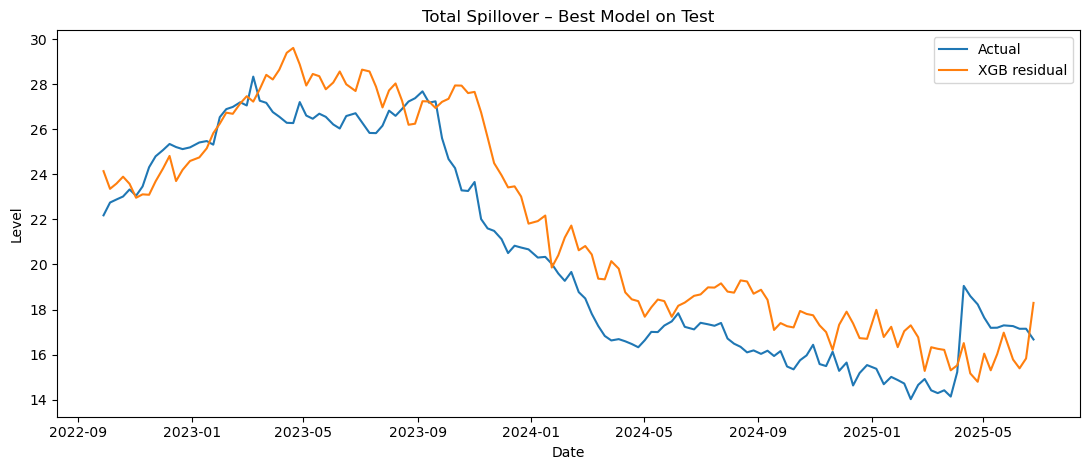

In [156]:
import os, re, numpy as np, pandas as pd
from glob import glob
import warnings; warnings.filterwarnings("ignore")

def _load_csv(path, date_col="Date"):
    if not os.path.exists(path):
        return None
    df = pd.read_csv(path)
    # try common date col names
    for cand in [date_col, "date", "DATE", "timestamp"]:
        if cand in df.columns:
            df[cand] = pd.to_datetime(df[cand])
            df = df.rename(columns={cand: "Date"})
            df = df.sort_values("Date")
            return df
    raise ValueError(f"Could not find a date column in {path}")

# Load pieces (some may be None if not available yet)
df_total = _load_csv(CSV_TOTAL_SPILLOVER)
df_net   = _load_csv(CSV_NET)
df_vol   = _load_csv(CSV_VOL)
df_dcc   = _load_csv(CSV_DCC)
df_ms    = _load_csv(CSV_REGIME_MS)      # expects 'Regime_MS'
df_seg   = _load_csv(CSV_REGIME_SEG)     # expects 'Regime_SegID'


# If dcc_correlations.csv has many pair columns, take their row-wise mean as avg_dcc
if df_dcc is not None:
    # If already provided, keep only what's needed
    if "avg_dcc" in df_dcc.columns:
        df_dcc = df_dcc[["Date", "avg_dcc"]]
    else:
        # Try to identify a "value" column (long format)
        val_col = next((c for c in df_dcc.columns
                        if c.lower() in {"dcc","corr","correlation","value","avgcorr"}), None)

        if val_col is not None and any(c.lower() in {"pair","i","j","asset_i","asset_j"} for c in df_dcc.columns):
            # Long format: average by Date
            df_dcc[val_col] = pd.to_numeric(df_dcc[val_col], errors="coerce")
            df_dcc = (df_dcc.groupby("Date", as_index=False)[val_col]
                              .mean()
                              .rename(columns={val_col: "avg_dcc"}))
        else:
            # Wide format: average across numeric columns only
            cand_cols = [c for c in df_dcc.columns if c != "Date"]
            # coerce all candidates to numeric (non-numerics -> NaN)
            df_dcc[cand_cols] = df_dcc[cand_cols].apply(pd.to_numeric, errors="coerce")
            num_cols = df_dcc.select_dtypes(include=np.number).columns.tolist()
            if not num_cols:
                raise ValueError("dcc_correlations.csv has no numeric correlation columns after coercion.")
            df_dcc["avg_dcc"] = df_dcc[num_cols].mean(axis=1, skipna=True)
            df_dcc = df_dcc[["Date", "avg_dcc"]]

# Merge everything on Date (inner join keeps aligned days)
frames = [df_total, df_net, df_vol, df_dcc, df_ms, df_seg]
merged = None
for f in frames:
    if f is None: 
        continue
    merged = f if merged is None else pd.merge(merged, f, on="Date", how="inner")

if merged is None:
    raise RuntimeError("No data loaded. Check your CSV paths.")

merged = merged.drop_duplicates(subset=["Date"]).sort_values("Date").reset_index(drop=True)

# Basic cleaning: forward-fill regimes if they’re categorical codes
for col in ["Regime_MS", "Regime_SegID"]:
    if col in merged.columns:
        merged[col] = merged[col].ffill().bfill()

print(merged.shape)
merged.head()

def make_lags(df, cols, lags):
    out = df.copy()
    for c in cols:
        for L in lags:
            out[f"{c}_lag{L}"] = out[c].shift(L)
    return out

# Define target: Total_Spillover at t+H (shift negative moves up)
if "Total_Spillover" not in merged.columns:
    # try common alternatives
    alt = [c for c in merged.columns if re.search("total.*spill", c, flags=re.I)]
    if alt:
        merged = merged.rename(columns={alt[0]:"Total_Spillover"})
    else:
        raise ValueError("Couldn't find Total_Spillover column. Rename in CSV or here.")

merged["y"] = merged["Total_Spillover"].shift(-HORIZON)

# candidate feature columns (exclude Date, y)
base_feats = [c for c in merged.columns if c not in ["Date","y"]]

# create lags for spillover + net + vol + dcc + macro (avoid lagging regime flags if you want them contemporaneous)
to_lag = []
for c in base_feats:
    if c in ["Regime_MS","Regime_SegID"]:
        continue
    to_lag.append(c)

lagged = make_lags(merged, to_lag, LAGS)

# keep regimes as-is (no lag), and drop contemporaneous unlagged versions of numeric signals to prevent leakage
keep_direct = ["Regime_MS","Regime_SegID"]
feat_cols = [col for col in lagged.columns if any(col.endswith(f"_lag{L}") for L in LAGS)] + [c for c in keep_direct if c in lagged.columns]

# final dataset
data = lagged[["Date","y"] + feat_cols].dropna().reset_index(drop=True)
print(data.shape)
data.head()

from math import floor

N = len(data)
n_test = floor(TEST_SIZE * N)
n_val  = floor(VAL_SIZE * (N - n_test))
n_train = N - n_val - n_test

train = data.iloc[:n_train]
val   = data.iloc[n_train:n_train+n_val]
test  = data.iloc[n_train+n_val:]

X_train, y_train = train[feat_cols], train["y"]
X_val,   y_val   = val[feat_cols],   val["y"]
X_test,  y_test  = test[feat_cols],  test["y"]

print(f"Splits -> train:{len(train)}  val:{len(val)}  test:{len(test)}")

# Optional: save the split dates for reference
split_info = {
    "train_start": str(train["Date"].iloc[0].date()),
    "train_end":   str(train["Date"].iloc[-1].date()),
    "val_start":   str(val["Date"].iloc[0].date()),
    "val_end":     str(val["Date"].iloc[-1].date()),
    "test_start":  str(test["Date"].iloc[0].date()),
    "test_end":    str(test["Date"].iloc[-1].date())
}
split_info

# ==== XGB bundle: change-aware features + pure residual + per-regime + sign-classifier ====
import numpy as np, pandas as pd, matplotlib.pyplot as plt, xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from pandas.api.types import is_numeric_dtype

np.random.seed(RANDOM_SEED)

# -------- helpers --------
def make_lags(df, cols, lags):
    out = df.copy()
    for c in cols:
        for L in lags:
            out[f"{c}_lag{L}"] = out[c].shift(L)
    return out

def dir_change_acc(y, p):
    return (np.sign(np.diff(y)) == np.sign(np.diff(p))).mean()

def print_report(y, p, label):
    rmse = mean_squared_error(y, p, squared=False)
    mae  = mean_absolute_error(y, p)
    r2   = r2_score(y, p)
    doc  = dir_change_acc(y, p)
    print(f"{label:<11s} RMSE={rmse:.3f}  MAE={mae:.3f}  R2={r2:.3f}  DirChange={doc:.3f}")
    return dict(rmse=rmse, mae=mae, r2=r2, doc=doc)

# -------- 1) Change-aware features (HAR / z-scores) on the pre-lag 'merged' --------
merged_ml = merged.copy()
for c in ["Total_Spillover", "avg_dcc"]:
    if c in merged_ml.columns:
        merged_ml[f"{c}_chg1"]  = merged_ml[c].diff(1)
        merged_ml[f"{c}_avg5"]  = merged_ml[c].rolling(5).mean()
        merged_ml[f"{c}_avg22"] = merged_ml[c].rolling(22).mean()
        roll = merged_ml[c].rolling(20)
        merged_ml[f"{c}_z20"]   = (merged_ml[c] - roll.mean())/roll.std()

# target & timing
merged_ml["y"]          = merged_ml["Total_Spillover"].shift(-HORIZON)
merged_ml["TargetDate"] = merged_ml["Date"].shift(-HORIZON)

# -------- 2) Rebuild lags (numeric-only), keep regimes contemporaneously --------
skip_direct = ["Regime_MS", "Regime_SegID"]
to_lag = []
for col in merged_ml.columns:
    if col in (["Date","y","TargetDate"] + skip_direct): 
        continue
    if is_numeric_dtype(merged_ml[col]):
        to_lag.append(col)

lagged = make_lags(merged_ml, to_lag, LAGS)

# baseline column (for residual add-back) will be created by lagging Total_Spillover
baseline_col = f"Total_Spillover_lag{HORIZON}"

keep_direct = [c for c in skip_direct if c in lagged.columns]
feat_cols = [c for c in lagged.columns if any(c.endswith(f"_lag{L}") for L in LAGS)] + keep_direct

data = lagged[["Date","TargetDate","y", baseline_col] + feat_cols].dropna().reset_index(drop=True)

# --- ensure unique columns and avoid baseline duplication ---
baseline_col = f"Total_Spillover_lag{HORIZON}"

# drop any duplicate columns that may have crept in
lagged = lagged.loc[:, ~lagged.columns.duplicated()]

# build feature list, but EXCLUDE the baseline col from features
keep_direct = [c for c in ["Regime_MS","Regime_SegID"] if c in lagged.columns]
feat_cols = [c for c in lagged.columns if any(c.endswith(f"_lag{L}") for L in LAGS) and c != baseline_col] + keep_direct

# final dataset (explicit column order)
cols_order = ["Date","TargetDate","y", baseline_col] + feat_cols
data = lagged.loc[:, cols_order].dropna().reset_index(drop=True)


# -------- 3) Time split (same ratios as before) --------
N = len(data)
n_test = int(TEST_SIZE * N)
n_val  = int(VAL_SIZE * (N - n_test))
n_train = N - n_val - n_test

train = data.iloc[:n_train].copy()
val   = data.iloc[n_train:n_train+n_val].copy()
test  = data.iloc[n_train+n_val:].copy()

X_train_raw, y_train = train[feat_cols], train["y"]
X_val_raw,   y_val   = val[feat_cols],   val["y"]
X_test_raw,  y_test  = test[feat_cols],  test["y"]

b_tr = train[baseline_col].values
b_va = val[baseline_col].values
b_te = test[baseline_col].values

target_dates = (test["TargetDate"] if "TargetDate" in test else test["Date"]).values

# ensure numeric-only for XGBoost
X_train_raw = X_train_raw.select_dtypes(include=[np.number])
X_val_raw   = X_val_raw.select_dtypes(include=[np.number])
X_test_raw  = X_test_raw.select_dtypes(include=[np.number])

# -------- 4) Baseline & raw XGB (reference) --------
y_true = y_test.values
preds = {}

base_metrics = print_report(y_true, b_te, "Baseline")
preds["Baseline"] = b_te

dtrain = xgb.DMatrix(X_train_raw, label=y_train)
dval   = xgb.DMatrix(X_val_raw,   label=y_val)
dtest  = xgb.DMatrix(X_test_raw,  label=y_test)

params_raw = dict(
    objective="reg:squarederror", eval_metric="rmse",
    tree_method="hist", learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, seed=RANDOM_SEED
)
xgb_raw = xgb.train(params_raw, dtrain, num_boost_round=400,
                    evals=[(dtrain,"train"),(dval,"val")],
                    early_stopping_rounds=30, verbose_eval=False)
pred_raw = xgb_raw.predict(dtest)
raw_metrics = print_report(y_true, pred_raw, "XGB raw")
preds["XGB raw"] = pred_raw

# -------- 5) PURE residual model (drop ALL TS lags from features) --------
ts_lag_cols = [c for c in X_train_raw.columns if c.startswith("Total_Spillover_lag")]
Xtr = X_train_raw.drop(columns=ts_lag_cols, errors="ignore")
Xva = X_val_raw.drop(columns=ts_lag_cols, errors="ignore")
Xte = X_test_raw.drop(columns=ts_lag_cols, errors="ignore")

r_tr = y_train.values - b_tr
r_va = y_val.values   - b_va
r_te = y_test.values  - b_te

dtr = xgb.DMatrix(Xtr, label=r_tr)
dva = xgb.DMatrix(Xva, label=r_va)
dte = xgb.DMatrix(Xte)

params_res = dict(
    objective="reg:squarederror", eval_metric="rmse",
    tree_method="hist", learning_rate=0.035, max_depth=3,
    min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, seed=RANDOM_SEED
)
xgb_res = xgb.train(params_res, dtr, num_boost_round=800,
                    evals=[(dtr,"train"),(dva,"val")],
                    early_stopping_rounds=60, verbose_eval=False)

r_hat = xgb_res.predict(dte)
pred_res = b_te + r_hat
res_metrics = print_report(y_true, pred_res, "XGB residual")
preds["XGB residual"] = pred_res

# -------- 6) Per-regime residual models (if regime available) --------
key = "Regime_MS" if "Regime_MS" in train.columns else ("Regime_SegID" if "Regime_SegID" in train.columns else None)
pred_reg = None
if key is not None:
    pred_res_all = np.zeros_like(y_true, dtype=float)
    done_any = False
    for g in sorted(pd.unique(test[key].dropna())):
        tr_mask = (train[key] == g).values
        va_mask = (val[key]   == g).values
        te_mask = (test[key]  == g).values
        # skip tiny groups
        if tr_mask.sum() < 40 or va_mask.sum() < 20 or te_mask.sum() < 10:
            continue
        dtr_g = xgb.DMatrix(Xtr[tr_mask], label=r_tr[tr_mask])
        dva_g = xgb.DMatrix(Xva[va_mask], label=r_va[va_mask])
        dte_g = xgb.DMatrix(Xte[te_mask])
        model_g = xgb.train(params_res, dtr_g, num_boost_round=800,
                            evals=[(dtr_g,"train"),(dva_g,"val")],
                            early_stopping_rounds=60, verbose_eval=False)
        pred_res_all[te_mask] = model_g.predict(dte_g)
        done_any = True
    if done_any:
        pred_reg = b_te + pred_res_all
        reg_metrics = print_report(y_true, pred_reg, "XGB perReg")
        preds["XGB perReg"] = pred_reg

# -------- 7) Sign-of-change classifier on residual (labels must be 0/1) --------
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# map -1/+1 -> 0/1
def to01(y): 
    return ((np.sign(y).clip(-1, 1) + 1) // 2).astype(int)

ytr_clf01 = to01(r_tr)
yva_clf01 = to01(r_va)
yte_clf01 = to01(r_te)

# guard against degenerate cases (only one class in train/val)
if np.unique(ytr_clf01).size < 2 or np.unique(yva_clf01).size < 2:
    print("[warn] Only one class present in train/val; skipping sign classifier.")
else:
    clf = XGBClassifier(
        n_estimators=600, max_depth=3, learning_rate=0.04,
        subsample=0.8, colsample_bytree=0.8, eval_metric="logloss",
        random_state=RANDOM_SEED, tree_method="hist"
    )
    clf.fit(Xtr, ytr_clf01, eval_set=[(Xva, yva_clf01)], verbose=False)
    pred_cls  = clf.predict(Xte)                    # 0/1
    pred_sign = np.where(pred_cls == 1, 1, -1)      # back to -1/+1
    sign_acc  = accuracy_score(np.where(yte_clf01==1, 1, -1), pred_sign)
    print(f"Sign(Δ) accuracy: {sign_acc:.3f}")


# --- sanitize predictions to 1-D and find offenders ---
import numpy as np
bad = []
for k, v in list(preds.items()):
    a = np.asarray(v)
    if a.ndim == 2:
        if a.shape[1] == 1:
            a = a.ravel()
        else:
            print(f"[warn] '{k}' predictions are multi-output {a.shape}; skipping for RMSE selection.")
            bad.append(k)
            continue
    preds[k] = a

for k in bad:
    preds.pop(k, None)

# (optional) quick audit
for k, v in preds.items():
    print(f"{k}: shape {np.asarray(v).shape}")

# --- best-by-RMSE selection (1-D only) ---
from sklearn.metrics import mean_squared_error
best_label = min(preds.keys(), key=lambda k: mean_squared_error(y_true, preds[k], squared=False))
best_pred  = preds[best_label]



plt.figure(figsize=(11,4.8))
plt.plot(target_dates, y_true, label="Actual")
plt.plot(target_dates, best_pred, label=f"{best_label}")
plt.title("Total Spillover – Best Model on Test")
plt.xlabel("Date"); plt.ylabel("Level"); plt.legend(); plt.tight_layout(); plt.show()


In [184]:
import os
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
from sklearn.impute import SimpleImputer
from PIL import Image, ImageDraw, ImageFont
import math

warnings.filterwarnings("ignore", category=UserWarning)

# ------------------ CONFIG: edit if needed ------------------
CSV_TOTAL_SPILLOVER = "outputs/rolling/rolling_total_H10_W250_S5_fixed.csv"
CSV_NET = "outputs/rolling/rolling_net_H10_W250_S5_fixed.csv"
CSV_VOL = "outputs/all_assets_conditional_vol.csv"
CSV_DCC = "outputs/dcc_correlations.csv"
CSV_REGIME_SEG = "outputs/trackC_segments.csv"
SEGMENTS_CSV = "outputs/regime_switching/trackC_segment_summary.csv"
MODEL_JSON = "outputs/ml/xgb_residual_model.json"
OUT_DIR = "outputs/ml/shap_trackC_xgb"
PLOTS_DIR = os.path.join(OUT_DIR, "plots")
# Speed/plot controls
HORIZON = 5
LAGS = list(range(1, 21))
MAX_ROWS_PER_SEG = 5000
TOPN = 10
SUMMARY_MAX_ROWS = 3000
RANDOM_SEED = 42
SAVE_DEPENDENCE = True
# Montage configuration
MONTAGE_FONT_SIZE = 20
MONTAGE_PADDING = 10
MONTAGE_INCLUDE_ALL = False  # True to include bar and dependence plots, False for summary plots only

# Check if input files exist
for path in [CSV_TOTAL_SPILLOVER, CSV_NET, CSV_VOL, CSV_DCC, CSV_REGIME_SEG, SEGMENTS_CSV, MODEL_JSON]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Input file not found: {path}")

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# --- Utilities ---
def _ensure_date(df, name):
    if "Date" not in df.columns:
        raise ValueError(f"'Date' column missing in {name}")
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"]).sort_values("Date")
    return df

def _collapse_to_unique_dates(df, name, value_cols=None, how="mean"):
    df = _ensure_date(df, name)
    if value_cols is None:
        value_cols = [c for c in df.columns if c != "Date" and pd.api.types.is_numeric_dtype(df[c])]
    if df.duplicated("Date").any():
        agg = {c: how for c in value_cols}
        df = df.groupby("Date", as_index=False).agg(agg).sort_values("Date")
    else:
        df = df[["Date"] + value_cols]
    return df

def _pivot_long_if_needed(df, name, value_suffix):
    df = _ensure_date(df, name)
    num_cols = [c for c in df.columns if c not in ["Date", "Asset"] and pd.api.types.is_numeric_dtype(df[c])]
    if "Asset" in df.columns and len(num_cols) == 1:
        val = num_cols[0]
        wide = df.pivot_table(index="Date", columns="Asset", values=val, aggfunc="mean").sort_index().reset_index()
        wide.columns = ["Date"] + [f"{str(c)}_{value_suffix}" for c in wide.columns[1:]]
        return wide
    return _collapse_to_unique_dates(df, name)

def add_lags(frame, col, lags):
    if col not in frame.columns or not pd.api.types.is_numeric_dtype(frame[col]):
        return
    for L in lags:
        frame[f"{col}_lag{L}"] = frame[col].shift(L)

def create_montage(plot_files, output_path, padding=MONTAGE_PADDING, font_size=MONTAGE_FONT_SIZE):
    if not plot_files:
        print("[MONTAGE] No plots found; skipping montage creation.")
        return

    images = [Image.open(f) for f in plot_files]
    max_width = max(img.width for img in images)
    max_height = max(img.height for img in images)

    n_images = len(images)
    n_cols = max(1, math.ceil(math.sqrt(n_images)))
    n_rows = max(1, math.ceil(n_images / n_cols))

    label_height = font_size + 5
    total_width = n_cols * (max_width + padding) - padding
    total_height = n_rows * (max_height + label_height + padding) - padding

    montage = Image.new("RGB", (total_width, total_height), "white")
    draw = ImageDraw.Draw(montage)
    
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except Exception:
        font = ImageFont.load_default()

    for i, (img, fname) in enumerate(zip(images, plot_files)):
        row = i // n_cols
        col = i % n_cols
        x = col * (max_width + padding)
        y = row * (max_height + label_height + padding)
        
        # Label based on plot type
        base = os.path.basename(fname)
        if base.startswith("seg_") and "summary" in base:
            seg_id = base.split("_")[1]
            label = f"Segment {seg_id}"
        elif base == "all_shap_summary.png":
            label = "Whole Dataset"
        elif "bar_top" in base:
            label = f"Top-{TOPN} Bar"
        elif "dependence_" in base:
            feature = base.split("dependence_")[1].replace(".png", "")
            label = f"Dependence: {feature}"
        else:
            label = base.replace(".png", "")
        
        montage.paste(img, (x, y + label_height))
        draw.text((x, y), label, fill="black", font=font)

    montage.save(output_path, dpi=(160, 160))
    print(f"[MONTAGE] Saved montage to: {output_path}")

# --- 1) Load and normalize inputs ---
tsi = _ensure_date(pd.read_csv(CSV_TOTAL_SPILLOVER), "Total Spillover")
if "Total_Spillover" not in tsi.columns:
    cand = [c for c in tsi.columns if c.lower().startswith("total")]
    if not cand:
        raise ValueError("Cannot find Total_Spillover column in TSI file.")
    tsi = tsi.rename(columns={cand[0]: "Total_Spillover"})
tsi = _collapse_to_unique_dates(tsi, "Total Spillover", ["Total_Spillover"])

net = _pivot_long_if_needed(pd.read_csv(CSV_NET), "NET", "x")
vol = _pivot_long_if_needed(pd.read_csv(CSV_VOL), "VOL", "y")

dcc_raw = _ensure_date(pd.read_csv(CSV_DCC), "DCC")
if "avg_dcc" not in dcc_raw.columns:
    dcc_cols = [c for c in dcc_raw.columns if c != "Date" and (c.upper().startswith("DCC") or pd.api.types.is_numeric_dtype(dcc_raw[c]))]
    if not dcc_cols:
        raise ValueError("No DCC columns found to compute avg_dcc.")
    dcc_raw["avg_dcc"] = dcc_raw[dcc_cols].mean(axis=1)
dcc = _collapse_to_unique_dates(dcc_raw[["Date", "avg_dcc"]], "DCC", ["avg_dcc"])

regC_raw = _ensure_date(pd.read_csv(CSV_REGIME_SEG), "Regime C (Segments)")
num_cols = [c for c in regC_raw.columns if c != "Date" and pd.api.types.is_numeric_dtype(regC_raw[c])]
if "Regime_SegID" not in regC_raw.columns:
    if num_cols:
        regC_raw = regC_raw.rename(columns={num_cols[0]: "Regime_SegID"})
    else:
        regC_raw["Regime_SegID"] = -1
regC = _collapse_to_unique_dates(regC_raw[["Date", "Regime_SegID"]], "Regime C (Segments)", ["Regime_SegID"])

# --- 2) Merge ---
df = tsi.merge(net, on="Date", how="left").merge(vol, on="Date", how="left").merge(dcc, on="Date", how="left").merge(regC, on="Date", how="left")
if df.duplicated("Date").sum():
    raise RuntimeError("Merged frame has duplicate Dates; investigate inputs.")

# --- 3) Feature engineering ---
df = df.sort_values("Date").reset_index(drop=True)
assets = ["S&P_500", "IEF", "Gold", "Wheat", "Natural_Gas", "Crude_Oil", "PBW"]
net_cols = [f"{asset}_x" for asset in assets if f"{asset}_x" in df.columns]
vol_cols = [f"{asset}_y" for asset in assets if f"{asset}_y" in df.columns]

for col in ["Total_Spillover", "avg_dcc"]:
    df[f"{col}_chg1"] = df[col].diff(1)
    df[f"{col}_avg5"] = df[col].rolling(5, min_periods=1).mean()
    df[f"{col}_avg22"] = df[col].rolling(22, min_periods=1).mean()
    roll = df[col].rolling(20, min_periods=1)
    df[f"{col}_z20"] = (df[col] - roll.mean()) / roll.std().clip(lower=1e-6)

for col in net_cols + vol_cols + ["Total_Spillover_chg1", "Total_Spillover_avg5", "Total_Spillover_avg22",
                                  "Total_Spillover_z20", "avg_dcc", "avg_dcc_chg1", "avg_dcc_avg5",
                                  "avg_dcc_avg22", "avg_dcc_z20"]:
    add_lags(df, col, LAGS)

# --- Feature set ---
feature_cols = []
for asset in assets:
    feature_cols.extend([f"{asset}_x_lag{L}" for L in LAGS])
    feature_cols.extend([f"{asset}_y_lag{L}" for L in LAGS])
feature_cols.extend([f"avg_dcc_lag{L}" for L in LAGS])
feature_cols.extend([f"Total_Spillover_chg1_lag{L}" for L in LAGS])
feature_cols.extend([f"Total_Spillover_avg5_lag{L}" for L in LAGS])
feature_cols.extend([f"Total_Spillover_avg22_lag{L}" for L in LAGS])
feature_cols.extend([f"Total_Spillover_z20_lag{L}" for L in LAGS])
feature_cols.extend([f"avg_dcc_chg1_lag{L}" for L in LAGS])
feature_cols.extend([f"avg_dcc_avg5_lag{L}" for L in LAGS])
feature_cols.extend([f"avg_dcc_avg22_lag{L}" for L in LAGS])
feature_cols.extend([f"avg_dcc_z20_lag{L}" for L in LAGS])
feature_cols.append("Regime_SegID")

missing_cols = [c for c in feature_cols if c not in df.columns]
if missing_cols:
    print(f"[WARNING] Missing features: {missing_cols}")
    feature_cols = [c for c in feature_cols if c in df.columns]

# --- 4) Load XGB model and SHAP explainer ---
booster = xgb.Booster()
booster.load_model(MODEL_JSON)
explainer = shap.TreeExplainer(booster)
model_feats = booster.feature_names or feature_cols
X = df[feature_cols].copy()

# Impute missing values
imp = SimpleImputer(strategy="mean")
X = pd.DataFrame(imp.fit_transform(X), columns=feature_cols, index=df["Date"])

# --- 5) Load segments ---
seg = pd.read_csv(SEGMENTS_CSV)
seg.columns = [c.strip().lower() for c in seg.columns]
id_col = next(c for c in seg.columns if c in ("segment_id", "segid", "id", "segment"))
start_c = next(c for c in seg.columns if c.startswith("start"))
end_c = next(c for c in seg.columns if c.startswith("end"))
seg = seg.rename(columns={id_col: "segment_id", start_c: "start_date", end_c: "end_date"})
seg["start_date"] = pd.to_datetime(seg["start_date"]).dt.normalize()
seg["end_date"] = pd.to_datetime(seg["end_date"]).dt.normalize()
seg = seg.sort_values(["start_date", "end_date"]).reset_index(drop=True)

# --- 6) Segment-wise SHAP analysis ---
meta_rows, long_rows, all_Xseg, all_sv = [], [], [], []
for _, r in seg.iterrows():
    sid, s, e = r["segment_id"], r["start_date"], r["end_date"]

    mask = (X.index >= s) & (X.index <= e)
    Xseg = X[mask].copy()
    n = len(Xseg)
    print(f"[Seg {sid}] requested {s.date()}→{e.date()} | rows={n}")

    if n == 0:
        meta_rows.append({"segment_id": sid, "start_date": s, "end_date": e, "n_obs": 0})
        plt.figure(figsize=(6, 3))
        plt.title(f"Segment {sid}: No Data", fontsize=14)
        txt_msg = (f"No data in {s.date()}→{e.date()}\n"
                   f"Features available: {X.index.min().date()}→{X.index.max().date()}")
        plt.text(0.5, 0.5, txt_msg, ha="center", va="center")
        plt.axis("off")
        plt.tight_layout(pad=1.5)
        plt.savefig(os.path.join(PLOTS_DIR, f"seg_{sid}_NO_DATA.png"), dpi=160)
        plt.close()
        continue

    if (MAX_ROWS_PER_SEG is not None) and (n > MAX_ROWS_PER_SEG):
        Xseg = Xseg.sample(n=MAX_ROWS_PER_SEG, random_state=RANDOM_SEED).sort_index()
        n = len(Xseg)

    # Compute SHAP values
    try:
        sv = explainer.shap_values(Xseg)
        if isinstance(sv, list):
            sv_abs_mean = np.sum([np.abs(s) for s in sv], axis=0).mean(axis=0)
        else:
            sv_abs_mean = np.abs(sv).mean(axis=0)

        mas = pd.Series(sv_abs_mean, index=Xseg.columns, name="mean_abs_shap").reset_index()
        mas.columns = ["feature", "mean_abs_shap"]
        mas.insert(0, "segment_id", sid)
        mas["start_date"], mas["end_date"], mas["n_obs"] = s, e, n
        long_rows.append(mas)
        meta_rows.append({"segment_id": sid, "start_date": s, "end_date": e, "n_obs": n})

        # Collect data for whole-dataset plot
        all_Xseg.append(Xseg)
        if isinstance(sv, list):
            all_sv.append(sv[0])  # Use first output for multi-output models
        else:
            all_sv.append(sv)

        # Plots: Top-N bar chart of mean|SHAP|
        top = mas.sort_values("mean_abs_shap", ascending=False).head(TOPN)
        plt.figure(figsize=(8, 5))
        plt.barh(top["feature"][::-1], top["mean_abs_shap"][::-1])
        plt.title(f"Segment {sid} | Top-{TOPN} Mean |SHAP|", fontsize=14)
        plt.xlabel("Mean |SHAP|")
        plt.tight_layout(pad=1.5)
        plt.savefig(os.path.join(PLOTS_DIR, f"seg_{sid}_bar_top{TOPN}.png"), dpi=160)
        plt.close()

        # Plots: SHAP summary (beeswarm)
        Xsum = Xseg
        sv_sum = sv
        if (SUMMARY_MAX_ROWS is not None) and (len(Xsum) > SUMMARY_MAX_ROWS):
            sample_idx = Xseg.sample(n=SUMMARY_MAX_ROWS, random_state=RANDOM_SEED).index
            Xsum = Xseg.loc[sample_idx]
            if isinstance(sv, list):
                sv_sum = [s[sample_idx - Xseg.index[0]] for s in sv]
            else:
                sv_sum = sv[sample_idx - Xseg.index[0]]

        plt.figure(figsize=(8, 6))
        shap.summary_plot(sv_sum, Xsum, show=False)
        plt.title(f"SHAP Summary for Segment {sid} ({s.date()} to {e.date()})", fontsize=16, pad=10)
        plt.tight_layout(pad=1.5)
        plt.savefig(os.path.join(PLOTS_DIR, f"seg_{sid}_summary.png"), dpi=160, bbox_inches="tight")
        plt.close()

        # Optional: dependence plot for top feature
        if SAVE_DEPENDENCE and len(top) > 0:
            top_feat = top.iloc[0]["feature"]
            try:
                shap.dependence_plot(top_feat, sv_sum, Xsum, show=False)
                plt.title(f"Dependence Plot for {top_feat} (Segment {sid})", fontsize=14, pad=10)
                plt.tight_layout(pad=1.5)
                safe_feat = str(top_feat).replace("/", "-").replace(" ", "_")
                plt.savefig(os.path.join(PLOTS_DIR, f"seg_{sid}_dependence_{safe_feat}.png"), dpi=160, bbox_inches="tight")
                plt.close()
            except Exception as e:
                print(f"[Seg {sid}] Dependence plot failed for feature '{top_feat}': {e}")

    except Exception as e:
        print(f"[Seg {sid}] SHAP computation failed: {e}")
        meta_rows.append({"segment_id": sid, "start_date": s, "end_date": e, "n_obs": n, "error": str(e)})
        continue

# --- 7) Whole-dataset SHAP analysis ---
n = len(X)
print(f"[Whole Dataset] rows={n}, dates: {X.index.min().date()} → {X.index.max().date()}")

if n > 0:
    try:
        sv = explainer.shap_values(X)
        if isinstance(sv, list):
            sv_abs_mean = np.sum([np.abs(s) for s in sv], axis=0).mean(axis=0)
        else:
            sv_abs_mean = np.abs(sv).mean(axis=0)

        mas = pd.Series(sv_abs_mean, index=X.columns, name="mean_abs_shap").reset_index()
        mas.columns = ["feature", "mean_abs_shap"]
        mas["n_obs"] = n

        # Plots: Top-N bar chart of mean|SHAP|
        top = mas.sort_values("mean_abs_shap", ascending=False).head(TOPN)
        plt.figure(figsize=(8, 5))
        plt.barh(top["feature"][::-1], top["mean_abs_shap"][::-1])
        plt.title(f"Top-{TOPN} Mean |SHAP| (Whole Dataset)", fontsize=14)
        plt.xlabel("Mean |SHAP|")
        plt.tight_layout(pad=1.5)
        plt.savefig(os.path.join(PLOTS_DIR, f"all_bar_top{TOPN}.png"), dpi=160)
        plt.close()

        # Plots: SHAP summary (beeswarm)
        X_sum = X
        sv_sum = sv
        if (SUMMARY_MAX_ROWS is not None) and (len(X_sum) > SUMMARY_MAX_ROWS):
            sample_idx = X.sample(n=SUMMARY_MAX_ROWS, random_state=RANDOM_SEED).index
            X_sum = X.loc[sample_idx]
            sv_sum = sv[sample_idx] if not isinstance(sv, list) else [s[sample_idx] for s in sv]

        plt.figure(figsize=(10, 8))
        shap.summary_plot(sv_sum, X_sum, show=False)
        plt.title("SHAP Summary Plot for XGB - All Segments", fontsize=16, pad=10)
        plt.tight_layout(pad=1.5)
        plt.savefig(os.path.join(PLOTS_DIR, "all_shap_summary.png"), dpi=160, bbox_inches="tight")
        plt.close()

        # Optional: dependence plot for top feature
        if SAVE_DEPENDENCE and len(top) > 0:
            top_feat = top.iloc[0]["feature"]
            try:
                shap.dependence_plot(top_feat, sv_sum, X_sum, show=False)
                plt.title(f"Dependence Plot for {top_feat} (Whole Dataset)", fontsize=14, pad=10)
                plt.tight_layout(pad=1.5)
                safe_feat = str(top_feat).replace("/", "-").replace(" ", "_")
                plt.savefig(os.path.join(PLOTS_DIR, f"all_dependence_{safe_feat}.png"), dpi=160, bbox_inches="tight")
                plt.close()
            except Exception as e:
                print(f"[Whole Dataset] Dependence plot failed for feature '{top_feat}': {e}")

        # Save CSV outputs for whole dataset
        mas.to_csv(os.path.join(OUT_DIR, "xgb_shap_whole_long.csv"), index=False)
        wide_df = mas.pivot_table(columns="feature", values="mean_abs_shap", aggfunc="mean")
        wide_df.to_csv(os.path.join(OUT_DIR, "xgb_shap_whole_wide.csv"))
        top_df = mas.sort_values("mean_abs_shap", ascending=False).head(TOPN)
        top_df.to_csv(os.path.join(OUT_DIR, f"xgb_shap_top{TOPN}_whole.csv"), index=False)

    except Exception as e:
        print(f"[Whole Dataset] SHAP computation failed: {e}")

# --- 8) Save segment-wise CSV outputs ---
pd.DataFrame(meta_rows).to_csv(os.path.join(OUT_DIR, "trackC_segments_coverage.csv"), index=False)

if long_rows:
    long_df = pd.concat(long_rows, ignore_index=True)
    long_df.to_csv(os.path.join(OUT_DIR, "xgb_shap_segment_long.csv"), index=False)

    wide_df = long_df.pivot_table(index="segment_id", columns="feature", values="mean_abs_shap", aggfunc="mean")
    wide_df.to_csv(os.path.join(OUT_DIR, "xgb_shap_segment_wide.csv"))

    top_df = (long_df.sort_values(["segment_id", "mean_abs_shap"], ascending=[True, False])
                    .groupby("segment_id").head(TOPN))
    top_df.to_csv(os.path.join(OUT_DIR, f"xgb_shap_top{TOPN}_per_segment.csv"), index=False)

# --- 9) Create montage of SHAP plots ---
plot_files = sorted(
    [os.path.join(PLOTS_DIR, f) for f in os.listdir(PLOTS_DIR)
     if (f.endswith("_summary.png") or
         (MONTAGE_INCLUDE_ALL and (
             f.endswith(f"_bar_top{TOPN}.png") or
             ("dependence_" in f and f.endswith(".png"))
         ))) and "NO_DATA" not in f]
)
create_montage(plot_files, os.path.join(PLOTS_DIR, "montage_shap_summary.png"))

# --- 10) Manifest ---
manifest = {
    "total_spillover_path": CSV_TOTAL_SPILLOVER,
    "net_path": CSV_NET,
    "vol_path": CSV_VOL,
    "dcc_path": CSV_DCC,
    "regime_seg_path": CSV_REGIME_SEG,
    "segments_csv": SEGMENTS_CSV,
    "model_json": MODEL_JSON,
    "feature_order_used": feature_cols,
    "max_rows_per_seg": MAX_ROWS_PER_SEG,
    "topn": TOPN,
    "summary_max_rows": SUMMARY_MAX_ROWS,
    "save_dependence": SAVE_DEPENDENCE,
    "montage_include_all": MONTAGE_INCLUDE_ALL,
    "shap_summary_plot": os.path.join(PLOTS_DIR, "all_shap_summary.png"),
    "montage_plot": os.path.join(PLOTS_DIR, "montage_shap_summary.png")
}
with open(os.path.join(OUT_DIR, "manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2, default=lambda x: x.isoformat() if isinstance(x, pd.Timestamp) else str(x))

print(f"[DATA] Features available: {X.index.min().date()} → {X.index.max().date()}")
print("[DONE] Wrote SHAP CSVs to:", os.path.abspath(OUT_DIR))
print("[DONE] Plots saved to:", os.path.abspath(PLOTS_DIR))
print("[DONE] SHAP summary plot saved to:", os.path.join(os.path.abspath(PLOTS_DIR), "all_shap_summary.png"))
if plot_files:
    print("[DONE] Montage saved to:", os.path.join(os.path.abspath(PLOTS_DIR), "montage_shap_summary.png"))

[Seg 1] requested 2006-03-13→2007-11-26 | rows=86
[Seg 2] requested 2007-11-26→2008-08-06 | rows=36
[Seg 3] requested 2008-08-06→2013-07-25 | rows=251
[Seg 4] requested 2013-07-25→2016-02-24 | rows=131
[Seg 5] requested 2016-02-24→2017-06-12 | rows=66
[Seg 6] requested 2017-06-12→2019-08-21 | rows=111
[Seg 7] requested 2019-08-21→2021-02-19 | rows=76
[Seg 8] requested 2021-02-19→2022-07-12 | rows=71
[Seg 9] requested 2022-07-12→2024-01-08 | rows=76
[Seg 10] requested 2024-01-08→2025-06-24 | rows=74
[Whole Dataset] rows=969, dates: 2006-03-13 → 2025-06-24
[MONTAGE] Saved montage to: outputs/ml/shap_trackC_xgb/plots/montage_shap_summary.png
[DATA] Features available: 2006-03-13 → 2025-06-24
[DONE] Wrote SHAP CSVs to: /Users/mileshobson/outputs/ml/shap_trackC_xgb
[DONE] Plots saved to: /Users/mileshobson/outputs/ml/shap_trackC_xgb/plots
[DONE] SHAP summary plot saved to: /Users/mileshobson/outputs/ml/shap_trackC_xgb/plots/all_shap_summary.png
[DONE] Montage saved to: /Users/mileshobson/ou

In [34]:
import numpy as np

# Drop any non-numeric columns from the feature sets
bad_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
if bad_cols:
    print(f"Dropping non-numeric features ({len(bad_cols)}): {bad_cols[:10]}...")
    X_train = X_train.drop(columns=bad_cols)
    X_val   = X_val.drop(columns=bad_cols, errors="ignore")
    X_test  = X_test.drop(columns=bad_cols, errors="ignore")


Dropping non-numeric features (20): ['Regime_Label_lag1', 'Regime_Label_lag2', 'Regime_Label_lag3', 'Regime_Label_lag4', 'Regime_Label_lag5', 'Regime_Label_lag6', 'Regime_Label_lag7', 'Regime_Label_lag8', 'Regime_Label_lag9', 'Regime_Label_lag10']...


In [113]:
# ==== Per-Asset Net Spillover: residual XGBoost (merging NET columns) ====
import os, numpy as np, pandas as pd, xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pandas.api.types import is_numeric_dtype

np.random.seed(RANDOM_SEED)
os.makedirs("outputs/ml/per_asset", exist_ok=True)

def make_lags(df, cols, lags):
    out = df.copy()
    for c in cols:
        for L in lags:
            out[f"{c}_lag{L}"] = out[c].shift(L)
    return out

def dir_change_acc(y, p):
    return (np.sign(np.diff(y)) == np.sign(np.diff(p))).mean()

def normcol(c: str) -> str:
    # keep Date, tidy others
    c = c.strip()
    if c == "Date": 
        return c
    return (c.replace(" ", "_")
             .replace("/", "_")
             .replace("&", "and")
             .replace("-", "_"))

# 0) Load NET file and normalize its column names
assert os.path.exists(CSV_NET), f"Missing NET file: {CSV_NET}"
df_net_src = pd.read_csv(CSV_NET)
df_net_src.columns = [normcol(c) for c in df_net_src.columns]
df_net_src["Date"] = pd.to_datetime(df_net_src["Date"])
asset_cols = [c for c in df_net_src.columns if c != "Date"]
print("Assets found in NET:", asset_cols)

rows = []
for asset in asset_cols:
    try:
        # 1) Merge this asset's NET series onto merged
        df_asset = df_net_src[["Date", asset]].copy()
        base_df = merged.merge(df_asset, on="Date", how="inner").copy()

        # need enough data
        if base_df[asset].notna().sum() < 300:
            print(f"[skip] {asset}: too few non-NaN rows")
            continue

        # 2) Target & timing
        base_df["y"]          = base_df[asset].shift(-HORIZON)
        base_df["TargetDate"] = base_df["Date"].shift(-HORIZON)

        # 3) Change-aware helpers on spillover/DCC
        for c in ["Total_Spillover","avg_dcc"]:
            if c in base_df.columns:
                base_df[f"{c}_chg1"]  = base_df[c].diff(1)
                base_df[f"{c}_avg5"]  = base_df[c].rolling(5).mean()
                base_df[f"{c}_avg22"] = base_df[c].rolling(22).mean()
                roll = base_df[c].rolling(20)
                base_df[f"{c}_z20"]   = (base_df[c]-roll.mean())/roll.std()

        # 4) Lags (numeric only)
        to_lag = []
        for col in base_df.columns:
            if col in ["Date","y","TargetDate","Regime_MS","Regime_SegID"]:
                continue
            if is_numeric_dtype(base_df[col]):
                to_lag.append(col)

        lagged = make_lags(base_df, to_lag, LAGS)
        lagged = lagged.loc[:, ~lagged.columns.duplicated()]  # de-dup

        # 5) Feature set: ALL lags EXCEPT this asset's own lags (pure residual)
        baseline_col = f"{asset}_lag{HORIZON}"
        keep_direct  = [c for c in ["Regime_MS","Regime_SegID"] if c in lagged.columns]
        feat_cols = [c for c in lagged.columns
                     if any(c.endswith(f"_lag{L}") for L in LAGS)
                     and not c.startswith(f"{asset}_lag")]
        feat_cols += keep_direct

        cols_order = ["Date","TargetDate","y", baseline_col] + feat_cols
        data = lagged.loc[:, [c for c in cols_order if c in lagged.columns]].dropna().reset_index(drop=True)

        # 6) Time split
        N = len(data)
        n_test = int(TEST_SIZE * N)
        n_val  = int(VAL_SIZE * (N - n_test))
        n_train = N - n_val - n_test
        train = data.iloc[:n_train].copy()
        val   = data.iloc[n_train:n_train+n_val].copy()
        test  = data.iloc[n_train+n_val:].copy()

        Xtr = train[feat_cols].select_dtypes(include=[np.number]).copy()
        Xva = val[feat_cols].select_dtypes(include=[np.number]).copy()
        Xte = test[feat_cols].select_dtypes(include=[np.number]).copy()

        ytr = train["y"].values
        yva = val["y"].values
        yte = test["y"].values

        b_tr = train[baseline_col].values
        b_va = val[baseline_col].values
        b_te = test[baseline_col].values

        # 7) Residuals
        r_tr = ytr - b_tr
        r_va = yva - b_va

        dtr = xgb.DMatrix(Xtr, label=r_tr); dva = xgb.DMatrix(Xva, label=r_va); dte = xgb.DMatrix(Xte)
        params = dict(objective="reg:squarederror", eval_metric="rmse",
                      tree_method="hist", learning_rate=0.035, max_depth=3,
                      min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
                      reg_lambda=1.0, seed=RANDOM_SEED)

        model = xgb.train(params, dtr, num_boost_round=800,
                          evals=[(dtr,"train"),(dva,"val")],
                          early_stopping_rounds=60, verbose_eval=False)

        r_hat = model.predict(dte)
        pred  = b_te + r_hat

        # 8) Metrics
        base_rmse = mean_squared_error(yte, b_te, squared=False)
        base_mae  = mean_absolute_error(yte, b_te)
        base_r2   = r2_score(yte, b_te)
        base_doc  = dir_change_acc(yte, b_te)

        rmse = mean_squared_error(yte, pred, squared=False)
        mae  = mean_absolute_error(yte, pred)
        r2   = r2_score(yte, pred)
        doc  = dir_change_acc(yte, pred)

        rows.append(dict(
            Asset=asset, N=N, train=n_train, val=n_val, test=len(test),
            Baseline_RMSE=base_rmse, Baseline_MAE=base_mae, Baseline_R2=base_r2, Baseline_DirChange=base_doc,
            XGBres_RMSE=rmse, XGBres_MAE=mae, XGBres_R2=r2, XGBres_DirChange=doc
        ))

        # 9) Save predictions & model
        out_pred = pd.DataFrame({
            "Date": pd.to_datetime(test["TargetDate"].values),
            "Actual": yte, "Baseline": b_te, "XGB_residual": pred, "ResidualHat": r_hat
        })
        out_pred.to_csv(f"outputs/ml/per_asset/{asset}_test_predictions.csv", index=False)
        model.save_model(f"outputs/ml/per_asset/xgb_residual_{asset}.json")
        print(f"[ok] {asset}: test={len(test)}  RMSE(base,res)={base_rmse:.3f},{rmse:.3f}")

    except Exception as e:
        print(f"[{asset}] error:", e)

if rows:
    per_asset_metrics = pd.DataFrame(rows).sort_values("Asset")
    per_asset_metrics.to_csv("outputs/ml/per_asset/metrics_summary.csv", index=False)
    print("Saved per-asset metrics -> outputs/ml/per_asset/metrics_summary.csv")
    display(per_asset_metrics)
else:
    print("No assets processed. Check NET columns and dates.")


Assets found in NET: ['SandP_500', 'IEF', 'Gold', 'Wheat', 'Natural_Gas', 'Crude_Oil', 'PBW']
[ok] SandP_500: test=138  RMSE(base,res)=2.026,2.316
[ok] IEF: test=138  RMSE(base,res)=1.750,2.804
[ok] Gold: test=138  RMSE(base,res)=1.875,2.175
[ok] Wheat: test=138  RMSE(base,res)=1.944,2.810
[ok] Natural_Gas: test=138  RMSE(base,res)=1.650,1.741
[ok] Crude_Oil: test=138  RMSE(base,res)=2.150,3.308
[ok] PBW: test=138  RMSE(base,res)=1.803,1.858
Saved per-asset metrics -> outputs/ml/per_asset/metrics_summary.csv


,Asset,N,train,val,test,Baseline_RMSE,Baseline_MAE,Baseline_R2,Baseline_DirChange,XGBres_RMSE,XGBres_MAE,XGBres_R2,XGBres_DirChange
5,Crude_Oil,923,668,117,138,2.149509,1.725481,0.274727,0.459854,3.308035,2.775421,-0.717763,0.459854
2,Gold,923,668,117,138,1.875247,1.401480,0.168698,0.496350,2.174978,1.617056,-0.118283,0.554745
1,IEF,923,668,117,138,1.749668,1.456052,0.419958,0.430657,2.803526,2.251636,-0.489215,0.452555
4,Natural_Gas,923,668,117,138,1.649511,1.392084,0.042103,0.576642,1.741393,1.426709,-0.067584,0.569343
6,PBW,923,668,117,138,1.803304,1.423766,0.147013,0.416058,1.857533,1.525168,0.094939,0.437956
0,SandP_500,923,668,117,138,2.026477,1.462296,0.407412,0.467153,2.316186,1.796831,0.225866,0.445255
3,Wheat,923,668,117,138,1.944074,1.646410,0.463462,0.518248,2.809610,2.174225,-0.120641,0.496350


In [110]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pandas.api.types import is_numeric_dtype

# === CONFIG ===
DATA_DIR = "outputs"
CSV_TOTAL_SPILLOVER = f"{DATA_DIR}/rolling/rolling_total_H10_W250_S5_fixed.csv"
CSV_NET = f"{DATA_DIR}/rolling/rolling_net_H10_W250_S5_fixed.csv"
CSV_DCC = f"{DATA_DIR}/dcc_correlations.csv"
CSV_REGIME_SEG = f"{DATA_DIR}/trackC_segments.csv"

# Modelling
HORIZON = 5
LAGS = list(range(1, 21))
TEST_SIZE = 0.15
VAL_SIZE = 0.15
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
os.makedirs("outputs/ml/per_asset", exist_ok=True)

# === Utilities ===
def _ensure_date(df, name):
    if "Date" not in df.columns:
        raise ValueError(f"'Date' column missing in {name}")
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"]).sort_values("Date")
    return df

def _collapse_to_unique_dates(df, name, value_cols=None, how="mean"):
    df = _ensure_date(df, name)
    if value_cols is None:
        value_cols = [c for c in df.columns if c != "Date" and is_numeric_dtype(df[c])]
    if df.duplicated("Date").any():
        agg = {c: how for c in value_cols}
        df = (df.groupby("Date", as_index=False).agg(agg).sort_values("Date"))
    else:
        df = df[["Date"] + value_cols]
    return df

def _pivot_long_if_needed(df, name, value_suffix):
    df = _ensure_date(df, name)
    num_cols = [c for c in df.columns if c not in ["Date","Asset"] and is_numeric_dtype(df[c])]
    if "Asset" in df.columns and len(num_cols) == 1:
        val = num_cols[0]
        wide = (df.pivot_table(index="Date", columns="Asset", values=val, aggfunc="mean")
                .sort_index().reset_index())
        wide.columns = ["Date"] + [f"{str(c)}_{value_suffix}" for c in wide.columns[1:]]
        return wide
    return _collapse_to_unique_dates(df, name)

def make_lags(df, cols, lags):
    out = df.copy()
    for c in cols:
        for L in lags:
            out[f"{c}_lag{L}"] = out[c].shift(L)
    return out

def dir_change_acc(y, p):
    return (np.sign(np.diff(y)) == np.sign(np.diff(p))).mean()

def normcol(c: str) -> str:
    # keep Date, tidy others
    c = c.strip()
    if c == "Date": 
        return c
    return (c.replace(" ", "_")
             .replace("/", "_")
             .replace("&", "and")
             .replace("-", "_"))

# === Load & normalize inputs ===
tsi = _ensure_date(pd.read_csv(CSV_TOTAL_SPILLOVER), "Total Spillover")
if "Total_Spillover" not in tsi.columns:
    cand = [c for c in tsi.columns if c.lower().startswith("total")]
    if not cand:
        raise ValueError("Cannot find Total_Spillover column in TSI file.")
    tsi = tsi.rename(columns={cand[0]: "Total_Spillover"})
tsi = _collapse_to_unique_dates(tsi, "Total Spillover", ["Total_Spillover"])

dcc_raw = _ensure_date(pd.read_csv(CSV_DCC), "DCC")
if "avg_dcc" not in dcc_raw.columns:
    dcc_cols = [c for c in dcc_raw.columns if c != "Date" and (c.upper().startswith("DCC") or is_numeric_dtype(dcc_raw[c]))]
    if not dcc_cols:
        raise ValueError("No DCC columns found to compute avg_dcc.")
    dcc_raw["avg_dcc"] = dcc_raw[dcc_cols].mean(axis=1)
dcc = _collapse_to_unique_dates(dcc_raw[["Date","avg_dcc"]], "DCC", ["avg_dcc"])

regC_raw = _ensure_date(pd.read_csv(CSV_REGIME_SEG), "Regime C (Segments)")
num_cols = [c for c in regC_raw.columns if c != "Date" and is_numeric_dtype(regC_raw[c])]
if "Regime_SegID" not in regC_raw.columns:
    if num_cols:
        regC_raw = regC_raw.rename(columns={num_cols[0]: "Regime_SegID"})
    else:
        regC_raw["Regime_SegID"] = -1
regC = _collapse_to_unique_dates(regC_raw[["Date","Regime_SegID"]], "Regime C (Segments)", ["Regime_SegID"])

# === Merge to create merged DataFrame ===
merged = tsi.merge(dcc, on="Date", how="left")
merged = merged.merge(regC, on="Date", how="left")

_dupes = merged.duplicated("Date").sum()
print(f"[CHECK] Duplicated dates after merge: {_dupes}")
if _dupes:
    raise RuntimeError("Merged frame still has duplicate Dates; investigate inputs.")

merged = merged.sort_values("Date").reset_index(drop=True)

# === Per-Asset Net Spillover: residual XGBoost (merging NET columns) ===
assert os.path.exists(CSV_NET), f"Missing NET file: {CSV_NET}"
df_net_src = pd.read_csv(CSV_NET)
df_net_src.columns = [normcol(c) for c in df_net_src.columns]
df_net_src["Date"] = pd.to_datetime(df_net_src["Date"])
asset_cols = [c for c in df_net_src.columns if c != "Date"]
print("Assets found in NET:", asset_cols)

rows = []
for asset in asset_cols:
    try:
        # 1) Merge this asset's NET series onto merged
        df_asset = df_net_src[["Date", asset]].copy()
        base_df = merged.merge(df_asset, on="Date", how="inner").copy()

        # Need enough data
        if base_df[asset].notna().sum() < 300:
            print(f"[skip] {asset}: too few non-NaN rows")
            continue

        # 2) Target & timing
        base_df["y"] = base_df[asset].shift(-HORIZON)
        base_df["TargetDate"] = base_df["Date"].shift(-HORIZON)

        # 3) Change-aware helpers on spillover/DCC
        for c in ["Total_Spillover", "avg_dcc"]:
            if c in base_df.columns:
                base_df[f"{c}_chg1"] = base_df[c].diff(1)
                base_df[f"{c}_avg5"] = base_df[c].rolling(5).mean()
                base_df[f"{c}_avg22"] = base_df[c].rolling(22).mean()
                roll = base_df[c].rolling(20)
                base_df[f"{c}_z20"] = (base_df[c] - roll.mean()) / roll.std()

        # 4) Lags (numeric only)
        to_lag = []
        for col in base_df.columns:
            if col in ["Date", "y", "TargetDate", "Regime_MS", "Regime_SegID"]:
                continue
            if is_numeric_dtype(base_df[col]):
                to_lag.append(col)

        lagged = make_lags(base_df, to_lag, LAGS)
        lagged = lagged.loc[:, ~lagged.columns.duplicated()]  # de-dup

        # 5) Feature set: ALL lags EXCEPT this asset's own lags (pure residual)
        baseline_col = f"{asset}_lag{HORIZON}"
        keep_direct = [c for c in ["Regime_MS", "Regime_SegID"] if c in lagged.columns]
        feat_cols = [c for c in lagged.columns
                     if any(c.endswith(f"_lag{L}") for L in LAGS)
                     and not c.startswith(f"{asset}_lag")]
        feat_cols += keep_direct

        cols_order = ["Date", "TargetDate", "y", baseline_col] + feat_cols
        data = lagged.loc[:, [c for c in cols_order if c in lagged.columns]].dropna().reset_index(drop=True)

        # 6) Time split
        N = len(data)
        n_test = int(TEST_SIZE * N)
        n_val = int(VAL_SIZE * (N - n_test))
        n_train = N - n_val - n_test
        train = data.iloc[:n_train].copy()
        val = data.iloc[n_train:n_train+n_val].copy()
        test = data.iloc[n_train+n_val:].copy()

        Xtr = train[feat_cols].select_dtypes(include=[np.number]).copy()
        Xva = val[feat_cols].select_dtypes(include=[np.number]).copy()
        Xte = test[feat_cols].select_dtypes(include=[np.number]).copy()

        ytr = train["y"].values
        yva = val["y"].values
        yte = test["y"].values

        b_tr = train[baseline_col].values
        b_va = val[baseline_col].values
        b_te = test[baseline_col].values

        # 7) Residuals
        r_tr = ytr - b_tr
        r_va = yva - b_va

        dtr = xgb.DMatrix(Xtr, label=r_tr)
        dva = xgb.DMatrix(Xva, label=r_va)
        dte = xgb.DMatrix(Xte)
        params = dict(objective="reg:squarederror", eval_metric="rmse",
                      tree_method="hist", learning_rate=0.035, max_depth=3,
                      min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
                      reg_lambda=1.0, seed=RANDOM_SEED)

        model = xgb.train(params, dtr, num_boost_round=800,
                          evals=[(dtr, "train"), (dva, "val")],
                          early_stopping_rounds=60, verbose_eval=False)

        r_hat = model.predict(dte)
        pred = b_te + r_hat

        # 8) Metrics
        base_rmse = mean_squared_error(yte, b_te, squared=False)
        base_mae = mean_absolute_error(yte, b_te)
        base_r2 = r2_score(yte, b_te)
        base_doc = dir_change_acc(yte, b_te)

        rmse = mean_squared_error(yte, pred, squared=False)
        mae = mean_absolute_error(yte, pred)
        r2 = r2_score(yte, pred)
        doc = dir_change_acc(yte, pred)

        rows.append(dict(
            Asset=asset, N=N, train=n_train, val=n_val, test=len(test),
            Baseline_RMSE=base_rmse, Baseline_MAE=base_mae, Baseline_R2=base_r2, Baseline_DirChange=base_doc,
            XGBres_RMSE=rmse, XGBres_MAE=mae, XGBres_R2=r2, XGBres_DirChange=doc
        ))

        # 9) Save predictions & model
        out_pred = pd.DataFrame({
            "Date": pd.to_datetime(test["TargetDate"].values),
            "Actual": yte, "Baseline": b_te, "XGB_residual": pred, "ResidualHat": r_hat
        })
        out_pred.to_csv(f"outputs/ml/per_asset/{asset}_test_predictions.csv", index=False)
        model.save_model(f"outputs/ml/per_asset/xgb_residual_{asset}.json")
        print(f"[ok] {asset}: test={len(test)}  RMSE(base,res)={base_rmse:.3f},{rmse:.3f}")

    except Exception as e:
        print(f"[{asset}] error:", e)

if rows:
    per_asset_metrics = pd.DataFrame(rows).sort_values("Asset")
    per_asset_metrics.to_csv("outputs/ml/per_asset/metrics_summary.csv", index=False)
    print("Saved per-asset metrics -> outputs/ml/per_asset/metrics_summary.csv")
    print(per_asset_metrics)
else:
    print("No assets processed. Check NET columns and dates.")

[CHECK] Duplicated dates after merge: 0
Assets found in NET: ['SandP_500', 'IEF', 'Gold', 'Wheat', 'Natural_Gas', 'Crude_Oil', 'PBW']
[ok] SandP_500: test=138  RMSE(base,res)=2.026,2.316
[ok] IEF: test=138  RMSE(base,res)=1.750,2.804
[ok] Gold: test=138  RMSE(base,res)=1.875,2.175
[ok] Wheat: test=138  RMSE(base,res)=1.944,2.810
[ok] Natural_Gas: test=138  RMSE(base,res)=1.650,1.741
[ok] Crude_Oil: test=138  RMSE(base,res)=2.150,3.308
[ok] PBW: test=138  RMSE(base,res)=1.803,1.858
Saved per-asset metrics -> outputs/ml/per_asset/metrics_summary.csv
         Asset    N  train  val  test  Baseline_RMSE  Baseline_MAE  \
5    Crude_Oil  923    668  117   138       2.149509      1.725481   
2         Gold  923    668  117   138       1.875247      1.401480   
1          IEF  923    668  117   138       1.749668      1.456052   
4  Natural_Gas  923    668  117   138       1.649511      1.392084   
6          PBW  923    668  117   138       1.803304      1.423766   
0    SandP_500  923    668

In [54]:
import os, json, numpy as np, pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb

# === CONFIG ===
DATA_DIR = "outputs"

CSV_TOTAL_SPILLOVER = f"{DATA_DIR}/rolling/rolling_total_H10_W250_S5_fixed.csv"   # [Date, Total_Spillover]
CSV_NET             = f"{DATA_DIR}/rolling/rolling_net_H10_W250_S5_fixed.csv"     # [Date, (wide) <asset>_NET or (long) ['Date','Asset','NET']]
CSV_VOL             = f"{DATA_DIR}/all_assets_conditional_vol.csv"                 # [Date, (wide) <asset>_VOL or (long) ['Date','Asset','VOL']]
CSV_DCC             = f"{DATA_DIR}/dcc_correlations.csv"                           # [Date, avg_dcc] or [Date, pairwise DCC_*]
CSV_REGIME_SEG      = f"{DATA_DIR}/trackC_segments.csv"                            # [Date, Regime_SegID]

# Modelling
HORIZON     = 5               # predict TSI at t+H
LAGS        = list(range(1, 21))  # Match full_features lags (1 to 20)
TEST_SIZE   = 0.15
VAL_SIZE    = 0.15
RANDOM_SEED = 42
USE_RESIDUAL = True           # Consistent with residual approach

OUT_DIR     = f"{DATA_DIR}/ml"
os.makedirs(OUT_DIR, exist_ok=True)

PARAMS = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.02,
    "num_leaves": 31,
    "max_depth": -1,
    "min_data_in_leaf": 30,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "seed": RANDOM_SEED,
    "verbosity": -1,
}

# === Utilities ===
def _ensure_date(df, name):
    if "Date" not in df.columns:
        raise ValueError(f"'Date' column missing in {name}")
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"]).sort_values("Date")
    return df

def _collapse_to_unique_dates(df, name, value_cols=None, how="mean"):
    df = _ensure_date(df, name)
    if value_cols is None:
        value_cols = [c for c in df.columns if c != "Date" and pd.api.types.is_numeric_dtype(df[c])]
    if df.duplicated("Date").any():
        agg = {c: how for c in value_cols}
        df = (df.groupby("Date", as_index=False).agg(agg).sort_values("Date"))
    else:
        df = df[["Date"] + value_cols]
    return df

def _pivot_long_if_needed(df, name, value_suffix):
    df = _ensure_date(df, name)
    num_cols = [c for c in df.columns if c not in ["Date","Asset"] and pd.api.types.is_numeric_dtype(df[c])]
    if "Asset" in df.columns and len(num_cols) == 1:
        val = num_cols[0]
        wide = (df.pivot_table(index="Date", columns="Asset", values=val, aggfunc="mean")
                .sort_index().reset_index())
        wide.columns = ["Date"] + [f"{str(c)}_{value_suffix}" for c in wide.columns[1:]]
        return wide
    return _collapse_to_unique_dates(df, name)

def dir_change_acc(y_true, y_pred):
    if len(y_true) < 2:
        return float("nan")
    return float((np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred))).mean())

# === Load & normalize inputs ===
tsi = _ensure_date(pd.read_csv(CSV_TOTAL_SPILLOVER), "Total Spillover")
if "Total_Spillover" not in tsi.columns:
    cand = [c for c in tsi.columns if c.lower().startswith("total")]
    if not cand:
        raise ValueError("Cannot find Total_Spillover column in TSI file.")
    tsi = tsi.rename(columns={cand[0]: "Total_Spillover"})
tsi = _collapse_to_unique_dates(tsi, "Total Spillover", ["Total_Spillover"])

net = _pivot_long_if_needed(pd.read_csv(CSV_NET), "NET", "x")
vol = _pivot_long_if_needed(pd.read_csv(CSV_VOL), "VOL", "y")

dcc_raw = _ensure_date(pd.read_csv(CSV_DCC), "DCC")
if "avg_dcc" not in dcc_raw.columns:
    dcc_cols = [c for c in dcc_raw.columns if c != "Date" and (c.upper().startswith("DCC") or pd.api.types.is_numeric_dtype(dcc_raw[c]))]
    if not dcc_cols:
        raise ValueError("No DCC columns found to compute avg_dcc.")
    dcc_raw["avg_dcc"] = dcc_raw[dcc_cols].mean(axis=1)
dcc = _collapse_to_unique_dates(dcc_raw[["Date","avg_dcc"]], "DCC", ["avg_dcc"])

regC_raw = _ensure_date(pd.read_csv(CSV_REGIME_SEG), "Regime C (Segments)")
num_cols = [c for c in regC_raw.columns if c != "Date" and pd.api.types.is_numeric_dtype(regC_raw[c])]
if "Regime_SegID" not in regC_raw.columns:
    if num_cols:
        regC_raw = regC_raw.rename(columns={num_cols[0]: "Regime_SegID"})
    else:
        regC_raw["Regime_SegID"] = -1
regC = _collapse_to_unique_dates(regC_raw[["Date","Regime_SegID"]], "Regime C (Segments)", ["Regime_SegID"])

# === Merge ===
df = tsi.merge(net, on="Date", how="left")
df = df.merge(vol, on="Date", how="left")
df = df.merge(dcc, on="Date", how="left")
df = df.merge(regC, on="Date", how="left")

_dupes = df.duplicated("Date").sum()
print(f"[CHECK] Duplicated dates after merge: {_dupes}")
if _dupes:
    raise RuntimeError("Merged frame still has duplicate Dates; investigate inputs.")

# === Target & baseline ===
df = df.sort_values("Date").reset_index(drop=True)
df["y"] = df["Total_Spillover"].shift(-HORIZON)
df["Baseline_naive"] = df["Total_Spillover"]
if USE_RESIDUAL:
    df["y_delta"] = df["y"] - df["Baseline_naive"]

# Residual standardization
ROLL_W = 20
resid = df["y"] - df["Baseline_naive"]
# Impute resid_std to avoid NaN
resid_std = resid.rolling(ROLL_W, min_periods=1).std().fillna(method="ffill").clip(lower=1e-6)
df["y_delta_std"] = resid / resid_std

# === Feature engineering (match full_features) ===
assets = ["S&P_500", "IEF", "Gold", "Wheat", "Natural_Gas", "Crude_Oil", "PBW"]
net_cols = [f"{asset}_x" for asset in assets if f"{asset}_x" in df.columns]
vol_cols = [f"{asset}_y" for asset in assets if f"{asset}_y" in df.columns]
base_cols = ["Total_Spillover", "avg_dcc"]

# Generate transformations for Total_Spillover and avg_dcc
for col in ["Total_Spillover", "avg_dcc"]:
    df[f"{col}_chg1"] = df[col].diff(1)
    df[f"{col}_avg5"] = df[col].rolling(5, min_periods=1).mean()  # Relax min_periods
    df[f"{col}_avg22"] = df[col].rolling(22, min_periods=1).mean()  # Relax min_periods
    roll = df[col].rolling(20, min_periods=1)
    df[f"{col}_z20"] = (df[col] - roll.mean()) / roll.std().clip(lower=1e-6)

# Add lags for all relevant columns
def add_lags(frame, col, lags):
    if col not in frame.columns or not pd.api.types.is_numeric_dtype(frame[col]):
        return
    for L in lags:
        frame[f"{col}_lag{L}"] = frame[col].shift(L)

for col in net_cols + vol_cols + ["Total_Spillover_chg1", "Total_Spillover_avg5", "Total_Spillover_avg22", 
                                  "Total_Spillover_z20", "avg_dcc", "avg_dcc_chg1", "avg_dcc_avg5", 
                                  "avg_dcc_avg22", "avg_dcc_z20"]:
    add_lags(df, col, LAGS)

# === Feature set (exactly match full_features) ===
feature_cols = []
for asset in assets:
    feature_cols.extend([f"{asset}_x_lag{L}" for L in LAGS])
    feature_cols.extend([f"{asset}_y_lag{L}" for L in LAGS])
feature_cols.extend([f"avg_dcc_lag{L}" for L in LAGS])
feature_cols.extend([f"Total_Spillover_chg1_lag{L}" for L in LAGS])
feature_cols.extend([f"Total_Spillover_avg5_lag{L}" for L in LAGS])
feature_cols.extend([f"Total_Spillover_avg22_lag{L}" for L in LAGS])
feature_cols.extend([f"Total_Spillover_z20_lag{L}" for L in LAGS])
feature_cols.extend([f"avg_dcc_chg1_lag{L}" for L in LAGS])
feature_cols.extend([f"avg_dcc_avg5_lag{L}" for L in LAGS])
feature_cols.extend([f"avg_dcc_avg22_lag{L}" for L in LAGS])
feature_cols.extend([f"avg_dcc_z20_lag{L}" for L in LAGS])
feature_cols.append("Regime_SegID")

# Verify all features exist
missing_cols = [c for c in feature_cols if c not in df.columns]
if missing_cols:
    print(f"[WARNING] Missing features: {missing_cols}")
    feature_cols = [c for c in feature_cols if c in df.columns]

# Drop rows with missing target or baseline
df = df.dropna(subset=["y", "Baseline_naive"]).reset_index(drop=True)

# === Chronological split ===
N = len(df)
n_test = int(round(TEST_SIZE * N))
n_val  = int(round(VAL_SIZE * N))
n_train = N - n_val - n_test
if min(n_train, n_val, n_test) <= 0:
    raise ValueError(f"Bad split sizes with N={N}: train={n_train}, val={n_val}, test={n_test}")

train = df.iloc[:n_train]
val   = df.iloc[n_train:n_train+n_val]
test  = df.iloc[n_train+n_val:]

print(f"[SPLIT] Total {N} | Train {len(train)} | Val {len(val)} | Test {len(test)}")
print(f"[DATES] {df['Date'].iloc[0].date()} → {df['Date'].iloc[-1].date()} | "
      f"Test window: {test['Date'].iloc[0].date()} → {test['Date'].iloc[-1].date()}")

Xtr, Xva, Xte = train[feature_cols], val[feature_cols], test[feature_cols]

# Choose training target
_tgt = "y_delta_std" if USE_RESIDUAL else "y"
ytr, yva, yte = train[_tgt].values, val[_tgt].values, test[_tgt].values

b_tr, b_va, b_te = train["Baseline_naive"].values, val["Baseline_naive"].values, test["Baseline_naive"].values
TSI_t_test = test["Total_Spillover"].values
Date_test = test["Date"].values

# === Impute features ===
imp = SimpleImputer(strategy="mean")
Xtr_i = pd.DataFrame(imp.fit_transform(Xtr), columns=feature_cols, index=Xtr.index)
Xva_i = pd.DataFrame(imp.transform(Xva), columns=feature_cols, index=Xva.index)
Xte_i = pd.DataFrame(imp.transform(Xte), columns=feature_cols, index=Xte.index)

# === Train LightGBM ===
train_set = lgb.Dataset(Xtr_i, label=ytr, feature_name=feature_cols, free_raw_data=False)
val_set   = lgb.Dataset(Xva_i, label=yva, reference=train_set, free_raw_data=False)

callbacks = [
    lgb.early_stopping(stopping_rounds=300, verbose=False),
    lgb.log_evaluation(period=100),
]

gbm = lgb.train(
    PARAMS,
    train_set,
    num_boost_round=8000,
    valid_sets=[train_set, val_set],
    valid_names=["train", "val"],
    callbacks=callbacks,
)

best_iter = getattr(gbm, "best_iteration", None) or gbm.current_iteration() or gbm.num_trees()
print(f"[MODEL] Best iteration: {best_iter}")

# === Predict ===
yhat_core = gbm.predict(Xte_i, num_iteration=best_iter)
if USE_RESIDUAL:
    # Ensure resid_std aligns with test set
    resid_std_test = resid_std.iloc[-len(yhat_core):].values
    yhat = b_te + yhat_core * resid_std_test
    ytrue = test["y"].values
else:
    yhat = yhat_core
    ytrue = test["y"].values

baseline_pred = b_te.copy()

# === Handle NaN in yhat and ytrue ===
# Impute NaN in yhat and ytrue with mean of non-NaN values
yhat = np.where(np.isnan(yhat), np.nanmean(yhat), yhat)
ytrue = np.where(np.isnan(ytrue), np.nanmean(ytrue), ytrue)

# If all values are NaN, set to 0 to avoid metric failure
if np.all(np.isnan(yhat)):
    yhat = np.zeros_like(yhat)
    print("[WARNING] All predictions are NaN; replaced with zeros.")
if np.all(np.isnan(ytrue)):
    ytrue = np.zeros_like(ytrue)
    print("[WARNING] All true values are NaN; replaced with zeros.")

# === Metrics ===
def _metrics(y_true, y_pred):
    return {
        "RMSE": float(mean_squared_error(y_true, y_pred, squared=False)),
        "MAE":  float(mean_absolute_error(y_true, y_pred)),
        "R2":   float(r2_score(y_true, y_pred)),
        "DirChange": float(dir_change_acc(y_true, y_pred)),
    }

metrics = {
    "Baseline_naive": _metrics(ytrue, baseline_pred),
    "LGBM": {**_metrics(ytrue, yhat), "BestIteration": int(best_iter)},
}

# === Save outputs ===
preds_df = pd.DataFrame({
    "Date": Date_test,
    "Actual_TSI_t_plus_H": ytrue,
    "Pred": yhat,
    "Baseline_naive": baseline_pred,
    "TSI_t": TSI_t_test,
})

preds_path   = os.path.join(OUT_DIR, "new_lgbm_predictions.csv")
metrics_path = os.path.join(OUT_DIR, "new_lgbm_metrics.json")
fi_path      = os.path.join(OUT_DIR, "new_lgbm_feature_importance.csv")
model_path   = os.path.join(OUT_DIR, "new_lgbm_model.txt")

preds_df.to_csv(preds_path, index=False)

with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)

fi = pd.DataFrame({
    "feature": feature_cols,
    "gain": gbm.feature_importance(importance_type="gain"),
    "split": gbm.feature_importance(importance_type="split"),
}).sort_values("gain", ascending=False)
fi.to_csv(fi_path, index=False)

gbm.save_model(model_path)

print(f"\n[DONE] Saved model: {os.path.abspath(model_path)}")
print(f"[DONE] Predictions: {os.path.abspath(preds_path)}")
print(f"[DONE] Metrics: {os.path.abspath(metrics_path)}")
print(f"[DONE] Feature importance: {os.path.abspath(fi_path)}")

print("\n[METRICS]")
for k, v in metrics.items():
    print(k)
    for kk, vv in v.items():
        if isinstance(vv, float):
            print(f"  {kk}: {vv:.6f}")
        else:
            print(f"  {kk}: {vv}")

[CHECK] Duplicated dates after merge: 0
[SPLIT] Total 964 | Train 674 | Val 145 | Test 145
[DATES] 2006-03-13 → 2025-05-16 | Test window: 2022-07-05 → 2025-05-16
[100]	train's rmse: 0.661135	val's rmse: 1.60413
[200]	train's rmse: 0.42547	val's rmse: 1.58973
[300]	train's rmse: 0.301317	val's rmse: 1.59165
[MODEL] Best iteration: 61

[DONE] Saved model: /Users/mileshobson/outputs/ml/new_lgbm_model.txt
[DONE] Predictions: /Users/mileshobson/outputs/ml/new_lgbm_predictions.csv
[DONE] Metrics: /Users/mileshobson/outputs/ml/new_lgbm_metrics.json
[DONE] Feature importance: /Users/mileshobson/outputs/ml/new_lgbm_feature_importance.csv

[METRICS]
Baseline_naive
  RMSE: 1.388919
  MAE: 1.005351
  R2: 0.904692
  DirChange: 0.583333
LGBM
  RMSE: 1.565224
  MAE: 1.209197
  R2: 0.878960
  DirChange: 0.611111
  BestIteration: 61


In [85]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from PIL import Image
import math

# === CONFIG ===
DATA_DIR = "outputs"
MODEL_PATH = f"{DATA_DIR}/ml/new_lgbm_model.txt"
OUT_DIR = f"{DATA_DIR}/ml"
CSV_TOTAL_SPILLOVER = f"{DATA_DIR}/rolling/rolling_total_H10_W250_S5_fixed.csv"
CSV_NET = f"{DATA_DIR}/rolling/rolling_net_H10_W250_S5_fixed.csv"
CSV_VOL = f"{DATA_DIR}/all_assets_conditional_vol.csv"
CSV_DCC = f"{DATA_DIR}/dcc_correlations.csv"
CSV_REGIME_SEG = f"{DATA_DIR}/trackC_segments.csv"

# Modelling
HORIZON = 5
LAGS = list(range(1, 21))
USE_RESIDUAL = True
RANDOM_SEED = 42

os.makedirs(OUT_DIR, exist_ok=True)

# === Utilities ===
def _ensure_date(df, name):
    if "Date" not in df.columns:
        raise ValueError(f"'Date' column missing in {name}")
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"]).sort_values("Date")
    return df

def _collapse_to_unique_dates(df, name, value_cols=None, how="mean"):
    df = _ensure_date(df, name)
    if value_cols is None:
        value_cols = [c for c in df.columns if c != "Date" and pd.api.types.is_numeric_dtype(df[c])]
    if df.duplicated("Date").any():
        agg = {c: how for c in value_cols}
        df = (df.groupby("Date", as_index=False).agg(agg).sort_values("Date"))
    else:
        df = df[["Date"] + value_cols]
    return df

def _pivot_long_if_needed(df, name, value_suffix):
    df = _ensure_date(df, name)
    num_cols = [c for c in df.columns if c not in ["Date","Asset"] and pd.api.types.is_numeric_dtype(df[c])]
    if "Asset" in df.columns and len(num_cols) == 1:
        val = num_cols[0]
        wide = (df.pivot_table(index="Date", columns="Asset", values=val, aggfunc="mean")
                .sort_index().reset_index())
        wide.columns = ["Date"] + [f"{str(c)}_{value_suffix}" for c in wide.columns[1:]]
        return wide
    return _collapse_to_unique_dates(df, name)

# === Load & normalize inputs ===
tsi = _ensure_date(pd.read_csv(CSV_TOTAL_SPILLOVER), "Total Spillover")
if "Total_Spillover" not in tsi.columns:
    cand = [c for c in tsi.columns if c.lower().startswith("total")]
    if not cand:
        raise ValueError("Cannot find Total_Spillover column in TSI file.")
    tsi = tsi.rename(columns={cand[0]: "Total_Spillover"})
tsi = _collapse_to_unique_dates(tsi, "Total Spillover", ["Total_Spillover"])

net = _pivot_long_if_needed(pd.read_csv(CSV_NET), "NET", "x")
vol = _pivot_long_if_needed(pd.read_csv(CSV_VOL), "VOL", "y")

dcc_raw = _ensure_date(pd.read_csv(CSV_DCC), "DCC")
if "avg_dcc" not in dcc_raw.columns:
    dcc_cols = [c for c in dcc_raw.columns if c != "Date" and (c.upper().startswith("DCC") or pd.api.types.is_numeric_dtype(dcc_raw[c]))]
    if not dcc_cols:
        raise ValueError("No DCC columns found to compute avg_dcc.")
    dcc_raw["avg_dcc"] = dcc_raw[dcc_cols].mean(axis=1)
dcc = _collapse_to_unique_dates(dcc_raw[["Date","avg_dcc"]], "DCC", ["avg_dcc"])

regC_raw = _ensure_date(pd.read_csv(CSV_REGIME_SEG), "Regime C (Segments)")
num_cols = [c for c in regC_raw.columns if c != "Date" and pd.api.types.is_numeric_dtype(regC_raw[c])]
if "Regime_SegID" not in regC_raw.columns:
    if num_cols:
        regC_raw = regC_raw.rename(columns={num_cols[0]: "Regime_SegID"})
    else:
        regC_raw["Regime_SegID"] = -1
regC = _collapse_to_unique_dates(regC_raw[["Date","Regime_SegID"]], "Regime C (Segments)", ["Regime_SegID"])

# === Merge ===
df = tsi.merge(net, on="Date", how="left")
df = df.merge(vol, on="Date", how="left")
df = df.merge(dcc, on="Date", how="left")
df = df.merge(regC, on="Date", how="left")

_dupes = df.duplicated("Date").sum()
print(f"[CHECK] Duplicated dates after merge: {_dupes}")
if _dupes:
    raise RuntimeError("Merged frame still has duplicate Dates; investigate inputs.")

# === Target & baseline ===
df = df.sort_values("Date").reset_index(drop=True)
df["y"] = df["Total_Spillover"].shift(-HORIZON)
df["Baseline_naive"] = df["Total_Spillover"]
if USE_RESIDUAL:
    df["y_delta"] = df["y"] - df["Baseline_naive"]

# Residual standardization
ROLL_W = 20
resid = df["y"] - df["Baseline_naive"]
resid_std = resid.rolling(ROLL_W, min_periods=1).std().fillna(method="ffill").clip(lower=1e-6)
df["y_delta_std"] = resid / resid_std

# === Feature engineering (match full_features) ===
assets = ["S&P_500", "IEF", "Gold", "Wheat", "Natural_Gas", "Crude_Oil", "PBW"]
net_cols = [f"{asset}_x" for asset in assets if f"{asset}_x" in df.columns]
vol_cols = [f"{asset}_y" for asset in assets if f"{asset}_y" in df.columns]
base_cols = ["Total_Spillover", "avg_dcc"]

# Generate transformations for Total_Spillover and avg_dcc
for col in ["Total_Spillover", "avg_dcc"]:
    df[f"{col}_chg1"] = df[col].diff(1)
    df[f"{col}_avg5"] = df[col].rolling(5, min_periods=1).mean()
    df[f"{col}_avg22"] = df[col].rolling(22, min_periods=1).mean()
    roll = df[col].rolling(20, min_periods=1)
    df[f"{col}_z20"] = (df[col] - roll.mean()) / roll.std().clip(lower=1e-6)

# Add lags for all relevant columns
def add_lags(frame, col, lags):
    if col not in frame.columns or not pd.api.types.is_numeric_dtype(frame[col]):
        return
    for L in lags:
        frame[f"{col}_lag{L}"] = frame[col].shift(L)

for col in net_cols + vol_cols + ["Total_Spillover_chg1", "Total_Spillover_avg5", "Total_Spillover_avg22", 
                                  "Total_Spillover_z20", "avg_dcc", "avg_dcc_chg1", "avg_dcc_avg5", 
                                  "avg_dcc_avg22", "avg_dcc_z20"]:
    add_lags(df, col, LAGS)

# === Feature set (exactly match full_features) ===
feature_cols = []
for asset in assets:
    feature_cols.extend([f"{asset}_x_lag{L}" for L in LAGS])
    feature_cols.extend([f"{asset}_y_lag{L}" for L in LAGS])
feature_cols.extend([f"avg_dcc_lag{L}" for L in LAGS])
feature_cols.extend([f"Total_Spillover_chg1_lag{L}" for L in LAGS])
feature_cols.extend([f"Total_Spillover_avg5_lag{L}" for L in LAGS])
feature_cols.extend([f"Total_Spillover_avg22_lag{L}" for L in LAGS])
feature_cols.extend([f"Total_Spillover_z20_lag{L}" for L in LAGS])
feature_cols.extend([f"avg_dcc_chg1_lag{L}" for L in LAGS])
feature_cols.extend([f"avg_dcc_avg5_lag{L}" for L in LAGS])
feature_cols.extend([f"avg_dcc_avg22_lag{L}" for L in LAGS])
feature_cols.extend([f"avg_dcc_z20_lag{L}" for L in LAGS])
feature_cols.append("Regime_SegID")

# Verify all features exist
missing_cols = [c for c in feature_cols if c not in df.columns]
if missing_cols:
    print(f"[WARNING] Missing features: {missing_cols}")
    feature_cols = [c for c in feature_cols if c in df.columns]

# Drop rows with missing target or baseline
print(f"[DEBUG] Rows before dropping NaN in y/Baseline_naive: {len(df)}")
df = df.dropna(subset=["y", "Baseline_naive"]).reset_index(drop=True)
print(f"[DEBUG] Rows after dropping NaN in y/Baseline_naive: {len(df)}")

# === Impute features ===
X = df[feature_cols]
imp = SimpleImputer(strategy="mean")
X_i = pd.DataFrame(imp.fit_transform(X), columns=feature_cols, index=X.index)

# Debug: Print segment distribution
print(f"[DEBUG] Segment distribution in full dataset:\n{df['Regime_SegID'].value_counts(dropna=False)}")
print(f"[DEBUG] Total rows in full dataset: {len(df)}")

# === Load LightGBM model ===
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found at {MODEL_PATH}")
gbm = lgb.Booster(model_file=MODEL_PATH)

# === SHAP Analysis per Segment ===
unique_segments = df["Regime_SegID"].unique()
unique_segments = sorted(unique_segments[~pd.isna(unique_segments)])  # Remove NaN if any
print(f"[INFO] Unique segments in full dataset: {unique_segments}")

explainer = shap.TreeExplainer(gbm)
plot_paths = []

for seg in unique_segments:
    mask = df["Regime_SegID"] == seg
    if mask.sum() == 0:
        print(f"[WARNING] No data for segment {seg}; skipping.")
        continue
    
    X_subset = X_i[mask]
    print(f"[INFO] Processing segment {seg} with {len(X_subset)} data points")
    
    shap_values = explainer.shap_values(X_subset)
    
    # Compute mean absolute SHAP values for importance
    mean_shap = np.abs(shap_values).mean(axis=0)
    shap_importance = pd.DataFrame({
        "feature": feature_cols,
        "mean_abs_shap": mean_shap,
    }).sort_values("mean_abs_shap", ascending=False)
    
    # Save SHAP importance for this segment
    shap_path = os.path.join(OUT_DIR, f"new_lgbm_shap_importance_seg{seg}.csv")
    shap_importance.to_csv(shap_path, index=False)
    print(f"[DONE] SHAP importance for segment {seg}: {os.path.abspath(shap_path)}")
    
    # Plot SHAP summary for this segment
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_subset, feature_names=feature_cols, show=False, max_display=20)
    plt.title(f"SHAP Summary Plot for LightGBM - Segment {seg}")
    plt.tight_layout()
    plot_path = os.path.join(OUT_DIR, f"new_lgbm_shap_summary_seg{seg}.png")
    plt.savefig(plot_path, bbox_inches='tight')
    plt.close()
    plot_paths.append(plot_path)

# === Overall SHAP Analysis ===
shap_values_all = explainer.shap_values(X_i)
mean_shap_all = np.abs(shap_values_all).mean(axis=0)
shap_importance_all = pd.DataFrame({
    "feature": feature_cols,
    "mean_abs_shap": mean_shap_all,
}).sort_values("mean_abs_shap", ascending=False)

# Save overall SHAP importance
shap_path_all = os.path.join(OUT_DIR, "new_lgbm_shap_importance_all.csv")
shap_importance_all.to_csv(shap_path_all, index=False)
print(f"[DONE] Overall SHAP importance: {os.path.abspath(shap_path_all)}")

# Plot overall SHAP summary
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_all, X_i, feature_names=feature_cols, show=False, max_display=20)
plt.title("SHAP Summary Plot for LightGBM - All Segments")
plt.tight_layout()
plot_path_all = os.path.join(OUT_DIR, "new_lgbm_shap_summary_all.png")
plt.savefig(plot_path_all, bbox_inches='tight')
plt.close()
plot_paths.append(plot_path_all)

# === Create Montage of SHAP Diagrams ===
if plot_paths:
    num_plots = len(plot_paths)
    cols = math.ceil(math.sqrt(num_plots))
    rows = math.ceil(num_plots / cols)
    
    images = [Image.open(p) for p in plot_paths]
    widths, heights = zip(*(i.size for i in images))
    
    max_width = max(widths)
    max_height = max(heights)
    
    total_width = cols * max_width
    total_height = rows * max_height
    
    montage = Image.new('RGB', (total_width, total_height), (255, 255, 255))
    
    x_offset = 0
    y_offset = 0
    for img in images:
        montage.paste(img, (x_offset, y_offset))
        x_offset += max_width
        if x_offset >= total_width:
            x_offset = 0
            y_offset += max_height
    
    montage_path = os.path.join(OUT_DIR, "new_lgbm_shap_summary_montage.png")
    montage.save(montage_path)
    print(f"[DONE] SHAP montage: {os.path.abspath(montage_path)}")
else:
    print("[INFO] No plots generated; skipping montage.")


[CHECK] Duplicated dates after merge: 0
[DEBUG] Rows before dropping NaN in y/Baseline_naive: 969
[DEBUG] Rows after dropping NaN in y/Baseline_naive: 964
[DEBUG] Segment distribution in full dataset:
Regime_SegID
3.0     250
4.0     130
6.0     110
1.0      85
7.0      75
9.0      75
8.0      70
10.0     68
5.0      65
2.0      35
NaN       1
Name: count, dtype: int64
[DEBUG] Total rows in full dataset: 964
[INFO] Unique segments in full dataset: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
[INFO] Processing segment 1.0 with 85 data points
[DONE] SHAP importance for segment 1.0: /Users/mileshobson/outputs/ml/new_lgbm_shap_importance_seg1.0.csv
[INFO] Processing segment 2.0 with 35 data points
[DONE] SHAP importance for segment 2.0: /Users/mileshobson/outputs/ml/new_lgbm_shap_importance_seg2.0.csv
[INFO] Processing segment 3.0 with 250 data points
[DONE] SHAP importance for segment 3.0: /Users/mileshobson/outputs/ml/new_lgbm_shap_importance_seg3.0.csv
[INFO] Processing segment 4

Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[12]	train's rmse: 2.3821	val's rmse: 1.35743
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[100]	train's rmse: 1.13613	val's rmse: 1.68425
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[168]	train's rmse: 0.764588	val's rmse: 3.16523
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[78]	train's rmse: 1.37956	val's rmse: 1.92299
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[79]	train's rmse: 1.3226	val's rmse: 1.90353

Walk-forward CV (averages across folds)
Baseline: {'Base_RMSE': 2.7461581179532963, 'Base_MAE': 2.068883407459716, 'Base_R2': -0.04883783326947435, 'Base_DirChange': 0.5050847457627118}
XGB-res : {'XGB_RMSE': 2.1355533731808407, 'XGB_MAE': 1.5199969051418265, 'XGB_R2': 0.284111

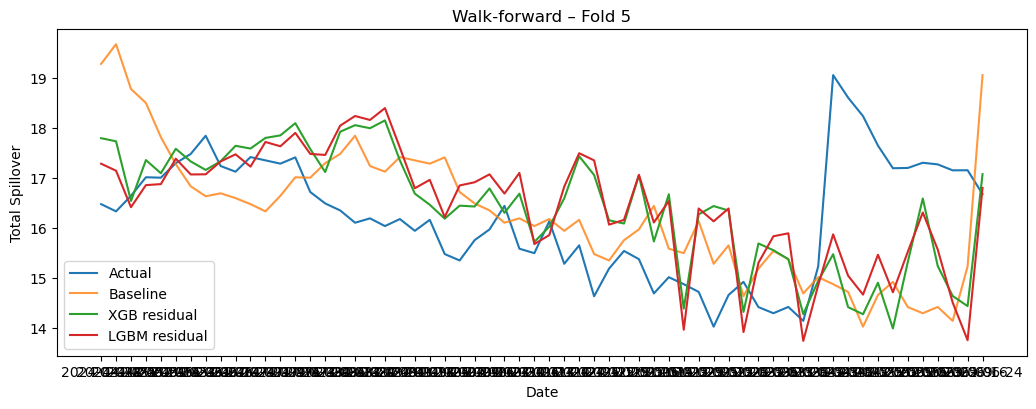

In [115]:
# ==== Walk-Forward CV for Total Spillover (Baseline vs XGB-res vs LGBM-res) ====
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings
from pandas.api.types import is_numeric_dtype
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
warnings.filterwarnings("ignore")

import xgboost as xgb
try:
    import lightgbm as lgb
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False
    print("[warn] lightgbm not installed; skipping LGBM.")

# --------- config (tweak if you like) ----------
FOLDS    = 5               # number of walk-forward test windows
VAL_LEN  = 60              # validation length (days)
TEST_LEN = 60              # test length per fold (days)
OUTDIR   = "outputs/ml/walkforward"
np.random.seed(RANDOM_SEED)

# --------- helpers ----------
def make_lags(df, cols, lags):
    out = df.copy()
    for c in cols:
        for L in lags:
            out[f"{c}_lag{L}"] = out[c].shift(L)
    return out

def dir_change_acc(y, p):
    return (np.sign(np.diff(y)) == np.sign(np.diff(p))).mean()

def build_dataset_from_merged(merged):
    df = merged.copy()

    # change-aware helpers for a couple of key drivers
    for c in ["Total_Spillover", "avg_dcc"]:
        if c in df.columns:
            df[f"{c}_chg1"]  = df[c].diff(1)
            df[f"{c}_avg5"]  = df[c].rolling(5).mean()
            df[f"{c}_avg22"] = df[c].rolling(22).mean()
            roll = df[c].rolling(20)
            df[f"{c}_z20"]   = (df[c] - roll.mean())/roll.std()

    # target & timing
    df["y"]          = df["Total_Spillover"].shift(-HORIZON)
    df["TargetDate"] = df["Date"].shift(-HORIZON)

    # lag numeric columns (skip direct regime flags)
    to_lag = []
    for col in df.columns:
        if col in ["Date","y","TargetDate","Regime_MS","Regime_SegID"]:
            continue
        if is_numeric_dtype(df[col]):
            to_lag.append(col)

    lagged = make_lags(df, to_lag, LAGS)
    lagged = lagged.loc[:, ~lagged.columns.duplicated()]  # de-dup

    baseline_col = f"Total_Spillover_lag{HORIZON}"
    keep_direct  = [c for c in ["Regime_MS","Regime_SegID"] if c in lagged.columns]

    # PURE residual features: exclude ALL TS lags
    feat_cols = [c for c in lagged.columns
                 if any(c.endswith(f"_lag{L}") for L in LAGS)
                 and not c.startswith("Total_Spillover_lag")]
    feat_cols += keep_direct

    data = lagged[["Date","TargetDate","y", baseline_col] + feat_cols].dropna().reset_index(drop=True)
    return data, feat_cols, baseline_col

# --------- build ML-ready data once ----------
data, feat_cols, baseline_col = build_dataset_from_merged(merged)
X_all = data[feat_cols].select_dtypes(include="number")
y_all = data["y"].values
b_all = data[baseline_col].values
dates_all = pd.to_datetime(data["TargetDate"].fillna(data["Date"])).values

N = len(data)
need = FOLDS*TEST_LEN + VAL_LEN + 200  # leave ~200 for initial training
if need > N:
    # shrink folds if not enough data
    FOLDS = max(2, (N - VAL_LEN - 200) // TEST_LEN)
    print(f"[info] Reduced FOLDS to {FOLDS} due to data length.")

os.makedirs(OUTDIR, exist_ok=True)

rows = []
all_preds = []

# --------- loop folds (expanding window) ----------
for k in range(FOLDS):
    test_end   = N - (FOLDS - 1 - k)*TEST_LEN
    test_start = test_end - TEST_LEN
    val_end    = test_start
    val_start  = val_end - VAL_LEN
    train_end  = val_start

    if train_end <= 0 or val_start < 0 or test_start <= 0:
        print(f"[skip] fold {k}: invalid indices.")
        continue

    tr_idx = slice(0, train_end)
    va_idx = slice(val_start, val_end)
    te_idx = slice(test_start, test_end)

    Xtr, Xva, Xte = X_all.iloc[tr_idx], X_all.iloc[va_idx], X_all.iloc[te_idx]
    ytr, yva, yte = y_all[tr_idx],    y_all[va_idx],    y_all[te_idx]
    btr, bva, bte = b_all[tr_idx],    b_all[va_idx],    b_all[te_idx]
    d_tr, d_va, d_te = dates_all[tr_idx], dates_all[va_idx], dates_all[te_idx]

    # --- Baseline ---
    base_pred = bte
    base_rmse = mean_squared_error(yte, base_pred, squared=False)
    base_mae  = mean_absolute_error(yte, base_pred)
    base_r2   = r2_score(yte, base_pred)
    base_doc  = dir_change_acc(yte, base_pred)

    # --- XGB residual ---
    rtr, rva = ytr - btr, yva - bva
    dtrain = xgb.DMatrix(Xtr, label=rtr)
    dval   = xgb.DMatrix(Xva, label=rva)
    dtest  = xgb.DMatrix(Xte)

    xgb_params = dict(
        objective="reg:squarederror", eval_metric="rmse",
        tree_method="hist", learning_rate=0.035, max_depth=3,
        min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, seed=RANDOM_SEED
    )
    xgb_model = xgb.train(
        xgb_params, dtrain, num_boost_round=3000,
        evals=[(dtrain,"train"), (dval,"val")],
        early_stopping_rounds=120, verbose_eval=False
    )
    r_hat_xgb = xgb_model.predict(dtest)
    pred_xgb  = bte + r_hat_xgb

    xgb_rmse = mean_squared_error(yte, pred_xgb, squared=False)
    xgb_mae  = mean_absolute_error(yte, pred_xgb)
    xgb_r2   = r2_score(yte, pred_xgb)
    xgb_doc  = dir_change_acc(yte, pred_xgb)

    # --- LightGBM residual (if available) ---
    lgb_rmse = lgb_mae = lgb_r2 = lgb_doc = np.nan
    pred_lgb = None
    if HAS_LGBM:
        train_set = lgb.Dataset(Xtr, label=rtr)
        val_set   = lgb.Dataset(Xva, label=rva)
        lgb_params = dict(
            objective="regression", metric="rmse",
            learning_rate=0.035, num_leaves=31, max_depth=-1,
            feature_fraction=0.8, bagging_fraction=0.8, bagging_freq=1,
            min_data_in_leaf=40, lambda_l2=1.0, verbose=-1, seed=RANDOM_SEED
        )
        callbacks = [lgb.early_stopping(stopping_rounds=150), lgb.log_evaluation(period=0)]
        lgbm = lgb.train(lgb_params, train_set, num_boost_round=4000,
                         valid_sets=[train_set, val_set], valid_names=["train","val"],
                         callbacks=callbacks)
        best_iter = getattr(lgbm, "best_iteration", None) or lgbm.num_trees()
        r_hat_lgb = lgbm.predict(Xte, num_iteration=best_iter)
        pred_lgb  = bte + r_hat_lgb

        lgb_rmse = mean_squared_error(yte, pred_lgb, squared=False)
        lgb_mae  = mean_absolute_error(yte, pred_lgb)
        lgb_r2   = r2_score(yte, pred_lgb)
        lgb_doc  = dir_change_acc(yte, pred_lgb)

    # record fold summary
    fold_row = dict(
        fold=k+1,
        train_start=str(pd.to_datetime(dates_all[0]).date()),
        train_end=str(pd.to_datetime(d_tr[-1]).date()),
        val_start=str(pd.to_datetime(d_va[0]).date()),
        val_end=str(pd.to_datetime(d_va[-1]).date()),
        test_start=str(pd.to_datetime(d_te[0]).date()),
        test_end=str(pd.to_datetime(d_te[-1]).date()),
        Base_RMSE=base_rmse, Base_MAE=base_mae, Base_R2=base_r2, Base_DirChange=base_doc,
        XGB_RMSE=xgb_rmse, XGB_MAE=xgb_mae, XGB_R2=xgb_r2, XGB_DirChange=xgb_doc,
        LGB_RMSE=lgb_rmse, LGB_MAE=lgb_mae, LGB_R2=lgb_r2, LGB_DirChange=lgb_doc
    )
    rows.append(fold_row)

    # save fold predictions
    fold_pred = pd.DataFrame({
        "Date": pd.to_datetime(d_te),
        "Actual": yte,
        "Baseline": base_pred,
        "XGB_residual": pred_xgb
    })
    if pred_lgb is not None:
        fold_pred["LGBM_residual"] = pred_lgb
    fold_pred.to_csv(os.path.join(OUTDIR, f"fold_{k+1:02d}_preds.csv"), index=False)

# --------- aggregate & save ----------
wf = pd.DataFrame(rows)
wf.to_csv(os.path.join(OUTDIR, "summary.csv"), index=False)

def agg(prefix):
    cols = [c for c in wf.columns if c.startswith(prefix)]
    return wf[cols].mean().to_dict()

agg_base = agg("Base_")
agg_xgb  = agg("XGB_")
agg_lgb  = agg("LGB_") if HAS_LGBM else {}

print("\nWalk-forward CV (averages across folds)")
print("Baseline:", {k:v for k,v in agg_base.items()})
print("XGB-res :", {k:v for k,v in agg_xgb.items()})
if HAS_LGBM:
    print("LGBM-res:", {k:v for k,v in agg_lgb.items()})
print(f"\nSaved fold preds to: {OUTDIR}/fold_**_preds.csv")
print(f"Saved summary to   : {OUTDIR}/summary.csv")

# quick visual of last fold
if len(rows):
    last = pd.read_csv(os.path.join(OUTDIR, f"fold_{len(rows):02d}_preds.csv"))
    plt.figure(figsize=(10.5,4.2))
    plt.plot(last["Date"], last["Actual"], label="Actual")
    plt.plot(last["Date"], last["Baseline"], label="Baseline", alpha=0.8)
    plt.plot(last["Date"], last["XGB_residual"], label="XGB residual")
    if "LGBM_residual" in last.columns:
        plt.plot(last["Date"], last["LGBM_residual"], label="LGBM residual")
    plt.title(f"Walk-forward – Fold {len(rows)}")
    plt.xlabel("Date"); plt.ylabel("Total Spillover"); plt.legend(); plt.tight_layout(); plt.show()


In [119]:
# ==== Walk-Forward CV — Per-Asset Net Spillovers (Residual XGB / LightGBM) ====
import os, numpy as np, pandas as pd, warnings
from pandas.api.types import is_numeric_dtype
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
warnings.filterwarnings("ignore")

# Optional LightGBM
try:
    import lightgbm as lgb
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False
    print("[warn] lightgbm not installed; skipping LGBM.")

# ----- config -----
FOLDS    = 5        # number of test windows
VAL_LEN  = 60       # validation length (days)
TEST_LEN = 60       # test length per fold (days)
INIT_TRAIN_MIN = 200  # min initial training days
OUTDIR   = "outputs/ml/walkforward/per_asset"
np.random.seed(RANDOM_SEED)

# ----- helpers -----
def normcol(c: str) -> str:
    c = c.strip()
    if c == "Date": return c
    return (c.replace(" ", "_")
             .replace("/", "_")
             .replace("&", "and")
             .replace("-", "_"))

def make_lags(df, cols, lags):
    out = df.copy()
    for c in cols:
        for L in lags:
            out[f"{c}_lag{L}"] = out[c].shift(L)
    return out

def dir_change_acc(y, p):
    return (np.sign(np.diff(y)) == np.sign(np.diff(p))).mean()

def build_dataset_for_asset(merged_df, net_src_df, asset_name):
    """Merge a single asset NET column onto merged, add engineered features, build lagged ML table."""
    base = merged_df.merge(net_src_df[["Date", asset_name]], on="Date", how="inner").copy()
    # target & timing for this asset
    base["y"]          = base[asset_name].shift(-HORIZON)
    base["TargetDate"] = base["Date"].shift(-HORIZON)

    # change-aware features on a couple of key drivers
    for c in ["Total_Spillover", "avg_dcc"]:
        if c in base.columns:
            base[f"{c}_chg1"]  = base[c].diff(1)
            base[f"{c}_avg5"]  = base[c].rolling(5).mean()
            base[f"{c}_avg22"] = base[c].rolling(22).mean()
            roll = base[c].rolling(20)
            base[f"{c}_z20"]   = (base[c] - roll.mean())/roll.std()

    # choose numeric columns to lag (exclude direct regime flags & target helpers)
    to_lag = []
    for col in base.columns:
        if col in ["Date","y","TargetDate","Regime_MS","Regime_SegID"]:
            continue
        if is_numeric_dtype(base[col]):
            to_lag.append(col)

    lagged = make_lags(base, to_lag, LAGS)
    lagged = lagged.loc[:, ~lagged.columns.duplicated()]  # de-dup
    baseline_col = f"{asset_name}_lag{HORIZON}"

    # PURE residual: use all lags EXCEPT this asset's own lags
    keep_direct = [c for c in ["Regime_MS","Regime_SegID"] if c in lagged.columns]
    feat_cols = [c for c in lagged.columns
                 if any(c.endswith(f"_lag{L}") for L in LAGS)
                 and not c.startswith(f"{asset_name}_lag")]
    feat_cols += keep_direct

    data = lagged[["Date","TargetDate","y", baseline_col] + [c for c in feat_cols if c in lagged.columns]]
    data = data.dropna().reset_index(drop=True)
    return data, feat_cols, baseline_col

# ----- load NET file & normalize header -----
assert os.path.exists(CSV_NET), f"Missing NET file: {CSV_NET}"
df_net_src = pd.read_csv(CSV_NET)
df_net_src.columns = [normcol(c) for c in df_net_src.columns]
df_net_src["Date"] = pd.to_datetime(df_net_src["Date"])
assets = [c for c in df_net_src.columns if c != "Date"]
print("Assets:", assets)

os.makedirs(OUTDIR, exist_ok=True)
summary_rows = []

# ----- per-asset walk-forward -----
for asset in assets:
    try:
        data, feat_cols, baseline_col = build_dataset_for_asset(merged, df_net_src, asset)
        if len(data) < INIT_TRAIN_MIN + VAL_LEN + TEST_LEN:
            print(f"[skip] {asset}: not enough rows ({len(data)})")
            continue

        X_all = data[feat_cols].select_dtypes(include="number")
        y_all = data["y"].values
        b_all = data[baseline_col].values
        d_all = pd.to_datetime(data["TargetDate"].fillna(data["Date"])).values
        N = len(data)

        # adjust folds if needed for this asset
        need = FOLDS*TEST_LEN + VAL_LEN + INIT_TRAIN_MIN
        folds_here = FOLDS if need <= N else max(2, (N - VAL_LEN - INIT_TRAIN_MIN) // TEST_LEN)
        if folds_here < FOLDS:
            print(f"[info] {asset}: reduced folds to {folds_here} due to data length.")
        asset_dir = os.path.join(OUTDIR, asset)
        os.makedirs(asset_dir, exist_ok=True)

        fold_rows = []
        for k in range(folds_here):
            test_end   = N - (folds_here - 1 - k)*TEST_LEN
            test_start = test_end - TEST_LEN
            val_end    = test_start
            val_start  = val_end - VAL_LEN
            train_end  = val_start
            train_start = 0

            if min(train_end, val_start, test_start) <= 0:
                print(f"[skip] {asset} fold {k+1}: invalid indices.")
                continue

            tr, va, te = slice(train_start, train_end), slice(val_start, val_end), slice(test_start, test_end)
            Xtr, Xva, Xte = X_all.iloc[tr], X_all.iloc[va], X_all.iloc[te]
            ytr, yva, yte = y_all[tr],       y_all[va],       y_all[te]
            btr, bva, bte = b_all[tr],       b_all[va],       b_all[te]
            dte           = d_all[te]

            # Baseline
            base_pred = bte
            base_rmse = mean_squared_error(yte, base_pred, squared=False)
            base_mae  = mean_absolute_error(yte, base_pred)
            base_r2   = r2_score(yte, base_pred)
            base_doc  = dir_change_acc(yte, base_pred)

            # XGB residual
            rtr, rva = ytr - btr, yva - bva
            dtrain = xgb.DMatrix(Xtr, label=rtr)
            dval   = xgb.DMatrix(Xva, label=rva)
            dtest  = xgb.DMatrix(Xte)
            xgb_params = dict(
                objective="reg:squarederror", eval_metric="rmse",
                tree_method="hist", learning_rate=0.035, max_depth=3,
                min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
                reg_lambda=1.0, seed=RANDOM_SEED
            )
            xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=3000,
                                  evals=[(dtrain,"train"),(dval,"val")],
                                  early_stopping_rounds=120, verbose_eval=False)
            pred_xgb = bte + xgb_model.predict(dtest)

            xgb_rmse = mean_squared_error(yte, pred_xgb, squared=False)
            xgb_mae  = mean_absolute_error(yte, pred_xgb)
            xgb_r2   = r2_score(yte, pred_xgb)
            xgb_doc  = dir_change_acc(yte, pred_xgb)

            # LGBM residual (optional)
            lgb_rmse = lgb_mae = lgb_r2 = lgb_doc = np.nan
            pred_lgb = None
            if HAS_LGBM:
                train_set = lgb.Dataset(Xtr, label=rtr)
                val_set   = lgb.Dataset(Xva, label=rva)
                lgb_params = dict(
                    objective="regression", metric="rmse",
                    learning_rate=0.035, num_leaves=31, max_depth=-1,
                    feature_fraction=0.8, bagging_fraction=0.8, bagging_freq=1,
                    min_data_in_leaf=40, lambda_l2=1.0, verbose=-1, seed=RANDOM_SEED
                )
                callbacks = [lgb.early_stopping(stopping_rounds=150), lgb.log_evaluation(period=0)]
                lgbm = lgb.train(lgb_params, train_set, num_boost_round=4000,
                                 valid_sets=[train_set, val_set], valid_names=["train","val"],
                                 callbacks=callbacks)
                best_iter = getattr(lgbm, "best_iteration", None) or lgbm.num_trees()
                pred_lgb  = bte + lgbm.predict(Xte, num_iteration=best_iter)

                lgb_rmse = mean_squared_error(yte, pred_lgb, squared=False)
                lgb_mae  = mean_absolute_error(yte, pred_lgb)
                lgb_r2   = r2_score(yte, pred_lgb)
                lgb_doc  = dir_change_acc(yte, pred_lgb)

            # save fold preds
            fold_pred = pd.DataFrame({
                "Date": pd.to_datetime(dte),
                "Actual": yte,
                "Baseline": base_pred,
                "XGB_residual": pred_xgb
            })
            if pred_lgb is not None:
                fold_pred["LGBM_residual"] = pred_lgb
            fold_pred.to_csv(os.path.join(asset_dir, f"fold_{k+1:02d}_preds.csv"), index=False)

            fold_rows.append(dict(
                Asset=asset, fold=k+1,
                train_end=str(pd.to_datetime(d_all[train_end-1]).date()),
                val_start=str(pd.to_datetime(d_all[val_start]).date()),
                val_end=str(pd.to_datetime(d_all[val_end-1]).date()),
                test_start=str(pd.to_datetime(dte[0]).date()),
                test_end=str(pd.to_datetime(dte[-1]).date()),
                Base_RMSE=base_rmse, Base_MAE=base_mae, Base_R2=base_r2, Base_DirChange=base_doc,
                XGB_RMSE=xgb_rmse, XGB_MAE=xgb_mae, XGB_R2=xgb_r2, XGB_DirChange=xgb_doc,
                LGB_RMSE=lgb_rmse, LGB_MAE=lgb_mae, LGB_R2=lgb_r2, LGB_DirChange=lgb_doc
            ))

        # per-asset summary (mean across folds)
        if fold_rows:
            folds_df = pd.DataFrame(fold_rows)
            folds_df.to_csv(os.path.join(asset_dir, "summary_folds.csv"), index=False)
            means = folds_df.filter(regex="^(Base_|XGB_|LGB_)").mean(numeric_only=True).to_dict()
            summary_rows.append({"Asset": asset, **means})
            print(f"[ok] {asset}: folds={len(fold_rows)}  XGB_RMSE(avg)={means.get('XGB_RMSE', np.nan):.3f}")
        else:
            print(f"[skip] {asset}: no valid folds")

    except Exception as e:
        print(f"[{asset}] error:", e)

# overall summary
if summary_rows:
    overall = pd.DataFrame(summary_rows).sort_values("Asset")
    os.makedirs(OUTDIR, exist_ok=True)
    overall.to_csv(os.path.join(OUTDIR, "summary.csv"), index=False)
    display(overall)
    print(f"Saved overall per-asset summary -> {OUTDIR}/summary.csv")
else:
    print("No per-asset results produced.")


Assets: ['SandP_500', 'IEF', 'Gold', 'Wheat', 'Natural_Gas', 'Crude_Oil', 'PBW']
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[1]	train's rmse: 2.62858	val's rmse: 1.42443
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[1129]	train's rmse: 0.102162	val's rmse: 2.78725
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[106]	train's rmse: 1.24066	val's rmse: 4.94476
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[18]	train's rmse: 2.53484	val's rmse: 1.37669
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[195]	train's rmse: 1.06266	val's rmse: 1.78024
[ok] SandP_500: folds=5  XGB_RMSE(avg)=2.733
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[1]	train's rmse: 2.13864	val's rmse: 2.15381
Trainin

,Asset,Base_RMSE,Base_MAE,Base_R2,Base_DirChange,XGB_RMSE,XGB_MAE,XGB_R2,XGB_DirChange,LGB_RMSE,LGB_MAE,LGB_R2,LGB_DirChange
5,Crude_Oil,2.031498,1.623451,-0.540366,0.461017,2.811629,2.271701,-1.947373,0.447458,2.084193,1.676367,-0.622331,0.461017
2,Gold,2.405779,1.817406,-0.719695,0.501695,2.607000,2.014189,-1.213930,0.542373,2.544084,2.007191,-1.044310,0.491525
1,IEF,2.322542,1.912461,0.138284,0.440678,2.558509,2.122781,-0.162855,0.518644,2.450397,2.090063,0.035224,0.454237
4,Natural_Gas,1.731302,1.383733,-0.332273,0.552542,1.879328,1.551713,-0.823467,0.555932,1.881668,1.489867,-0.527192,0.545763
6,PBW,2.515305,1.968359,-0.114935,0.471186,2.542062,2.037432,-0.133646,0.481356,2.538938,1.999705,-0.143809,0.464407
0,SandP_500,2.901698,1.858153,0.201025,0.498305,2.733386,1.892839,0.132564,0.511864,2.910298,2.030858,0.134503,0.525424
3,Wheat,1.911309,1.512345,0.125953,0.552542,2.265005,1.765576,-0.241741,0.511864,2.189755,1.736006,-0.131083,0.538983


Saved overall per-asset summary -> outputs/ml/walkforward/per_asset/summary.csv


Assets: ['.ipynb_checkpoints', 'Crude_Oil', 'Gold', 'IEF', 'Natural_Gas', 'PBW', 'SandP_500', 'Wheat']


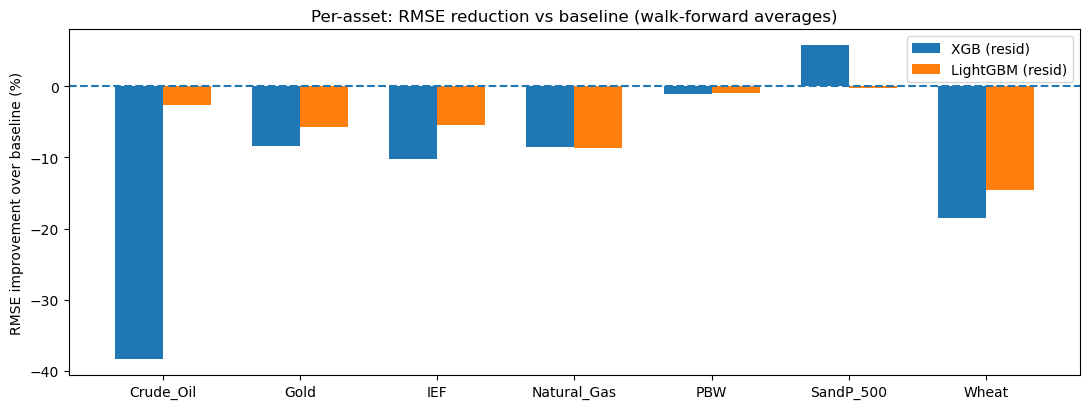

[skip] .ipynb_checkpoints: no fold preds


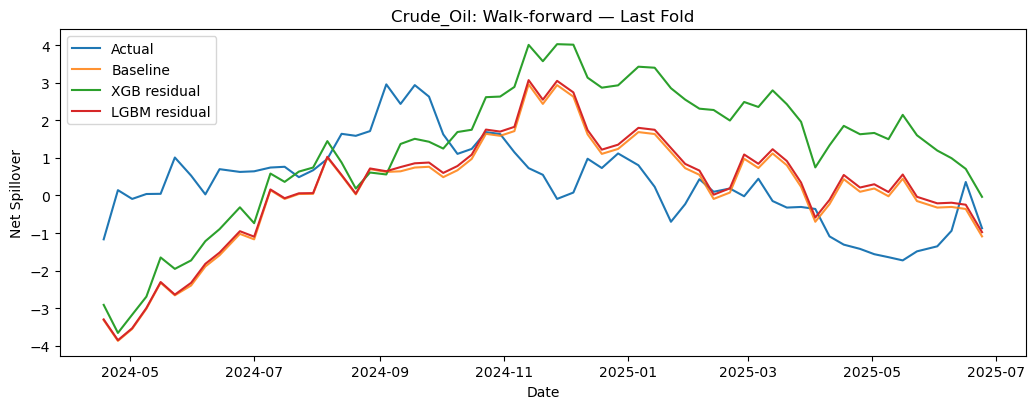

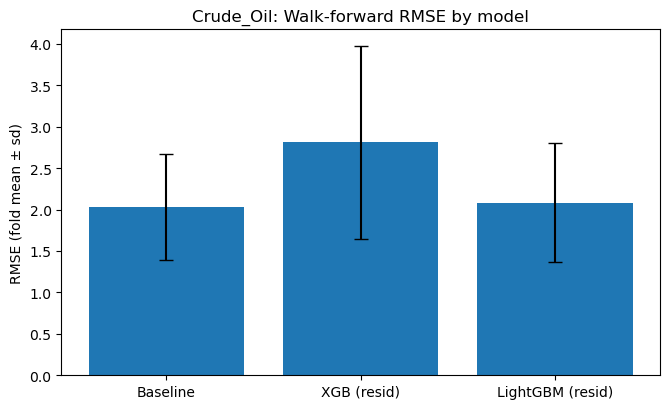

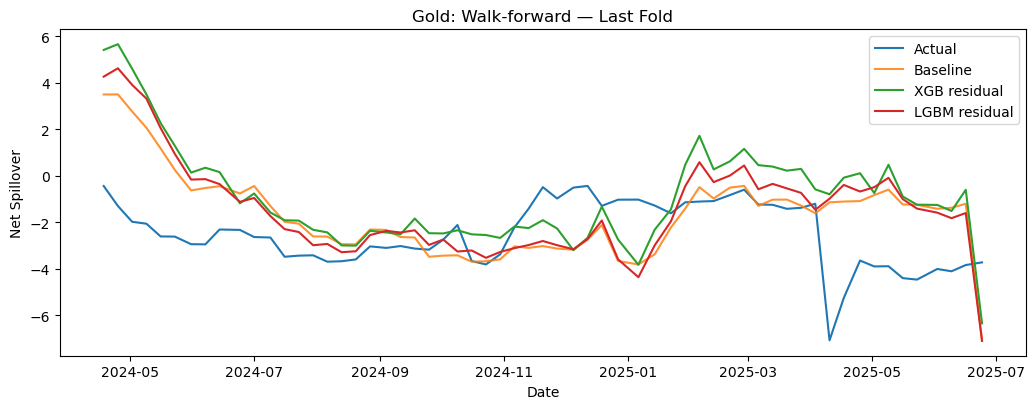

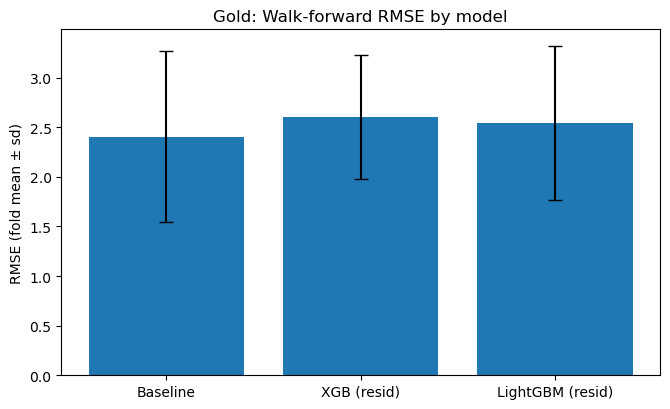

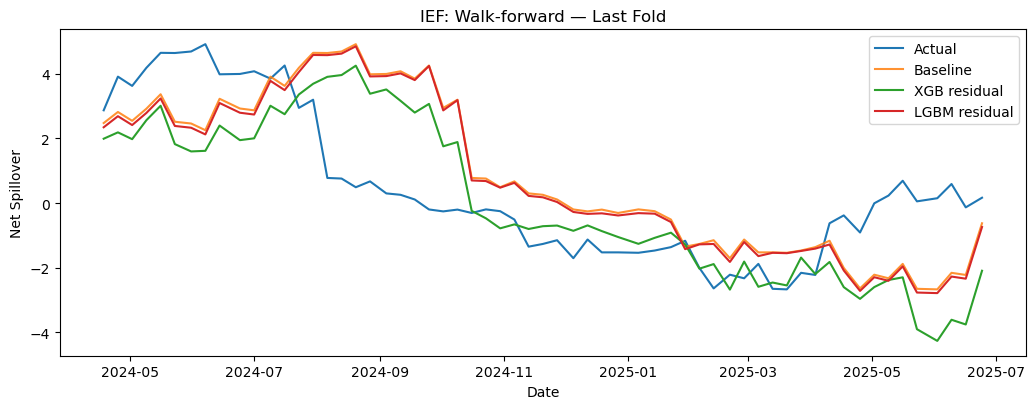

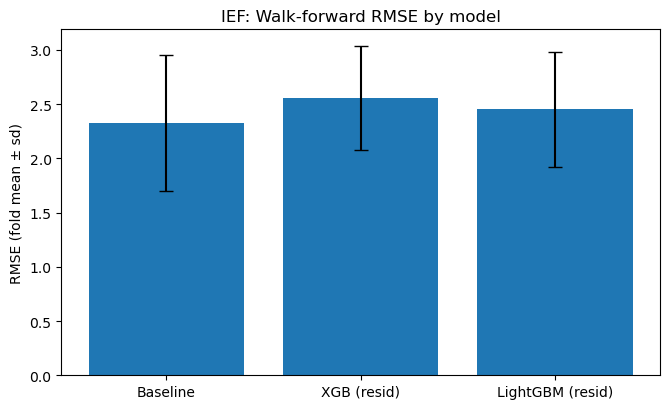

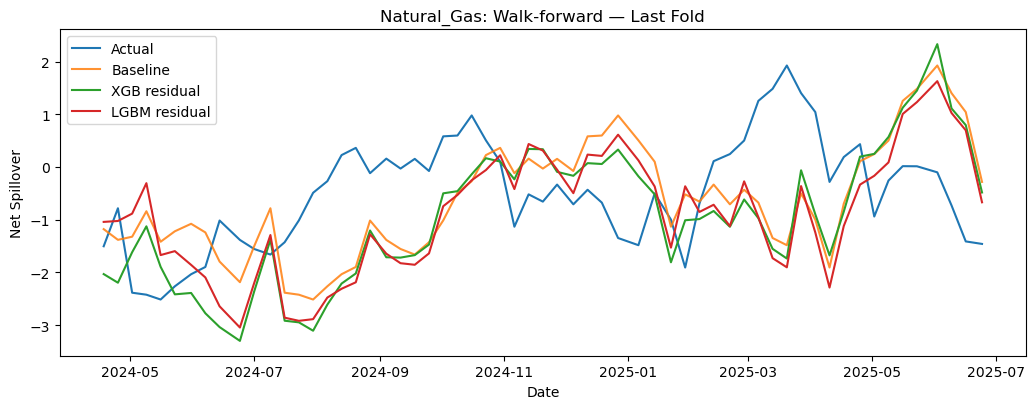

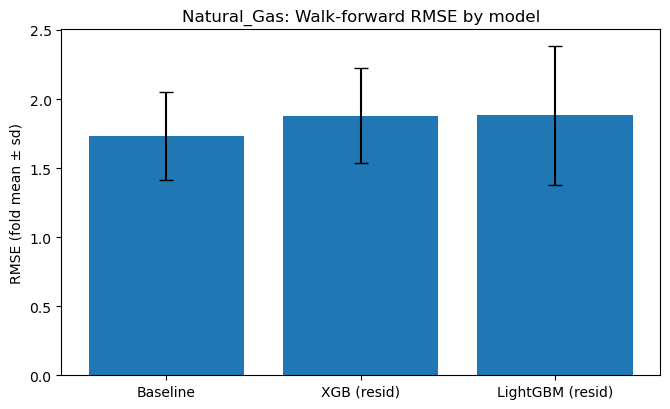

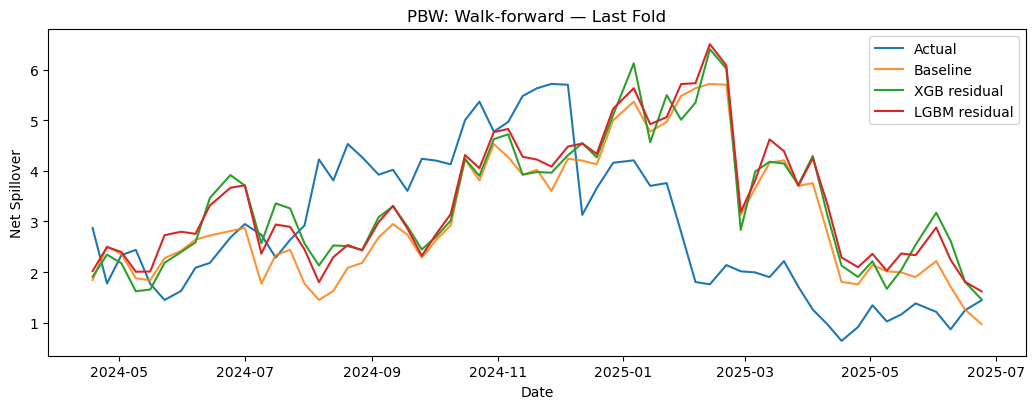

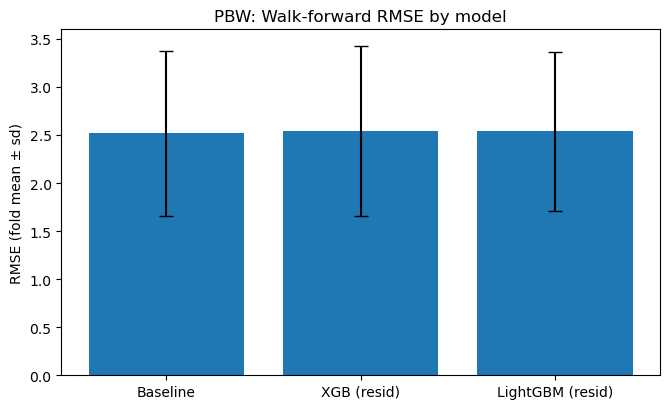

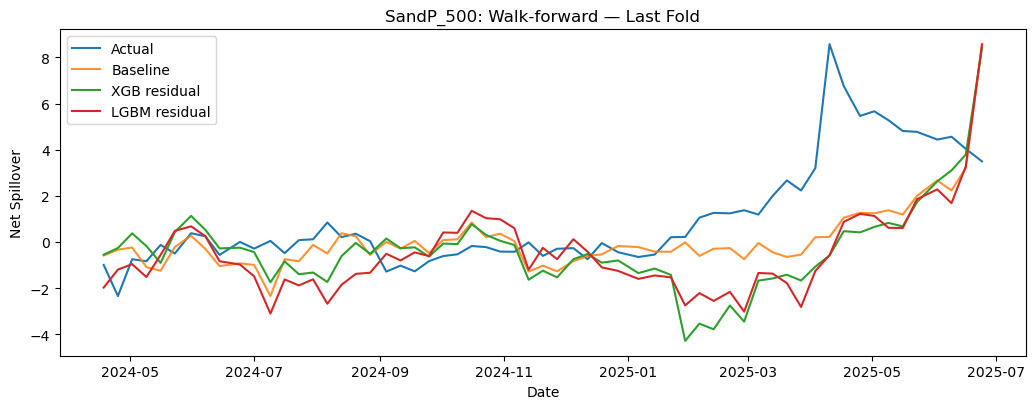

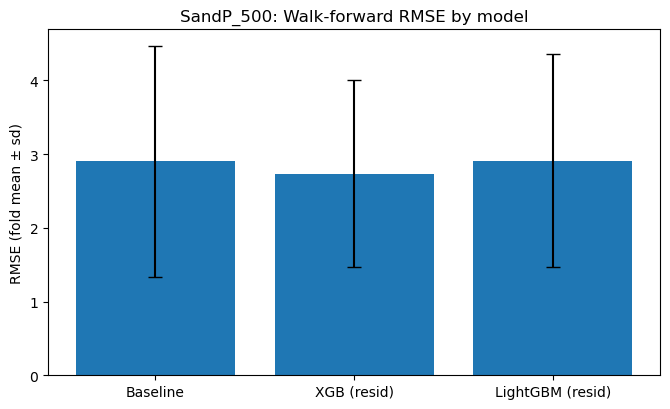

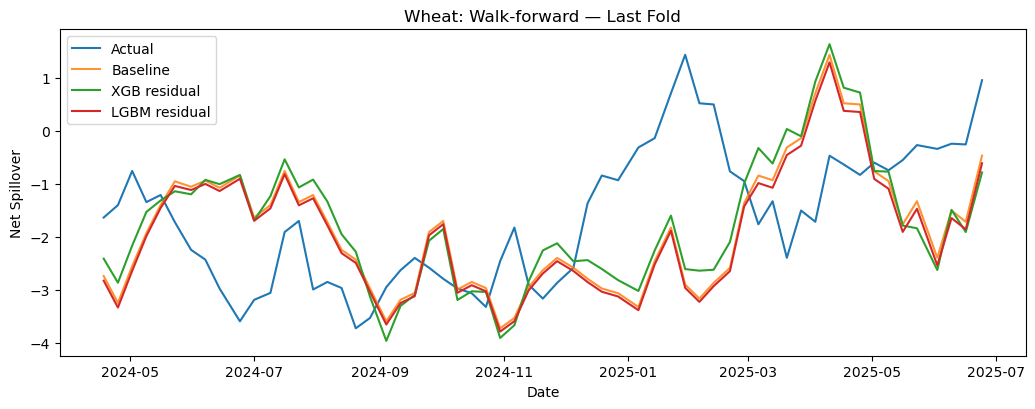

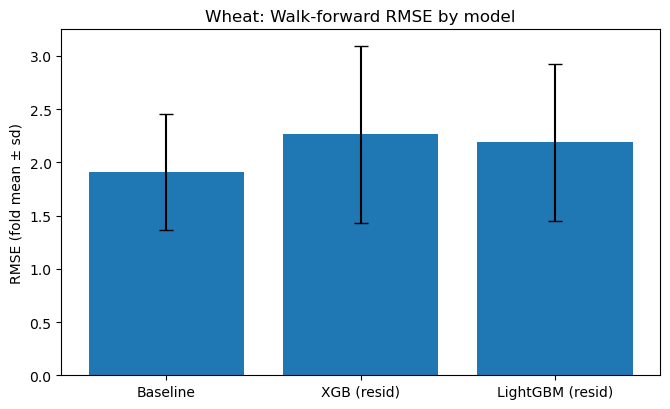

Saved per-asset figures (PNG+PDF) under: outputs/ml/walkforward/per_asset


In [122]:
# ==== Per-asset plotting bundle (walk-forward outputs) ====
import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt

BASE = "outputs/ml/walkforward/per_asset"
os.makedirs(BASE, exist_ok=True)

# 0) which assets?
assets = [d for d in os.listdir(BASE) if os.path.isdir(os.path.join(BASE, d)) and d != "_plots"]
assets = sorted(assets)
print("Assets:", assets)

# 1) Multi-asset summary improvements (bar chart)
overall_path = os.path.join(BASE, "summary.csv")
if os.path.exists(overall_path):
    overall = pd.read_csv(overall_path)
    for col in ["XGB_RMSE", "LGB_RMSE"]:
        if col in overall.columns:
            overall[f"{col}_ImprPct"] = (1 - overall[col] / overall["Base_RMSE"]) * 100.0
    overall.to_csv(os.path.join(BASE, "summary_with_improvements.csv"), index=False)

    # bar chart of improvement
    plt.figure(figsize=(11, 4.2))
    x = np.arange(len(overall))
    width = 0.35
    has_xgb = "XGB_RMSE_ImprPct" in overall.columns
    has_lgb = "LGB_RMSE_ImprPct" in overall.columns

    if has_xgb:
        plt.bar(x - (width/2 if has_lgb else 0), overall["XGB_RMSE_ImprPct"], width if has_lgb else 0.6, label="XGB (resid)")
    if has_lgb:
        plt.bar(x + (width/2 if has_xgb else 0), overall["LGB_RMSE_ImprPct"], width if has_xgb else 0.6, label="LightGBM (resid)")

    plt.axhline(0, linestyle="--")
    plt.xticks(x, overall["Asset"], rotation=0)
    plt.ylabel("RMSE improvement over baseline (%)")
    plt.title("Per-asset: RMSE reduction vs baseline (walk-forward averages)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(BASE, "per_asset_rmse_improvement.png"), dpi=200)
    plt.savefig(os.path.join(BASE, "per_asset_rmse_improvement.pdf"))
    plt.show()

# 2) Per-asset plots: last-fold time series + RMSE bar with error bars
for asset in assets:
    adir = os.path.join(BASE, asset)
    fold_files = sorted(glob.glob(os.path.join(adir, "fold_*_preds.csv")))
    if not fold_files:
        print(f"[skip] {asset}: no fold preds")
        continue

    # (a) Time series — last fold
    df = pd.read_csv(fold_files[-1], parse_dates=["Date"])
    plt.figure(figsize=(10.5, 4.2))
    plt.plot(df["Date"], df["Actual"], label="Actual")
    plt.plot(df["Date"], df["Baseline"], label="Baseline", alpha=0.85)
    if "XGB_residual" in df.columns:
        plt.plot(df["Date"], df["XGB_residual"], label="XGB residual")
    if "LGBM_residual" in df.columns:
        plt.plot(df["Date"], df["LGBM_residual"], label="LGBM residual")
    plt.title(f"{asset}: Walk-forward — Last Fold")
    plt.xlabel("Date"); plt.ylabel("Net Spillover")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(adir, f"{asset}_timeseries_lastfold.png"), dpi=200)
    plt.savefig(os.path.join(adir, f"{asset}_timeseries_lastfold.pdf"))
    plt.show()

    # (b) Fold-avg RMSE with error bars
    summ_path = os.path.join(adir, "summary_folds.csv")
    if not os.path.exists(summ_path):
        print(f"[warn] {asset}: missing summary_folds.csv")
        continue
    sf = pd.read_csv(summ_path)

    bars = []
    errs = []
    labels = []

    # Baseline
    labels.append("Baseline")
    bars.append(sf["Base_RMSE"].mean())
    errs.append(sf["Base_RMSE"].std())

    # XGB
    if "XGB_RMSE" in sf.columns:
        labels.append("XGB (resid)")
        bars.append(sf["XGB_RMSE"].mean())
        errs.append(sf["XGB_RMSE"].std())

    # LGBM
    if "LGB_RMSE" in sf.columns and not sf["LGB_RMSE"].isna().all():
        labels.append("LightGBM (resid)")
        bars.append(sf["LGB_RMSE"].mean())
        errs.append(sf["LGB_RMSE"].std())

    x = np.arange(len(labels))
    plt.figure(figsize=(6.8, 4.2))
    plt.bar(x, bars, yerr=errs, capsize=5)
    plt.xticks(x, labels, rotation=0)
    plt.ylabel("RMSE (fold mean ± sd)")
    plt.title(f"{asset}: Walk-forward RMSE by model")
    plt.tight_layout()
    plt.savefig(os.path.join(adir, f"{asset}_rmse_bar.png"), dpi=200)
    plt.savefig(os.path.join(adir, f"{asset}_rmse_bar.pdf"))
    plt.show()

print("Saved per-asset figures (PNG+PDF) under:", BASE)


In [125]:
# ==== Diebold–Mariano (DM) tests for walk-forward results: Total + Per-Asset ====
import os, glob, math, numpy as np, pandas as pd

# ---- DM test (squared-error loss) with Newey–West variance, lag = HORIZON-1 by default ----
def dm_test(y, yhat_base, yhat_model, h=1):
    y = np.asarray(y, dtype=float); b = np.asarray(yhat_base, dtype=float); m = np.asarray(yhat_model, dtype=float)
    e_b = y - b
    e_m = y - m
    d = e_b**2 - e_m**2     # loss differential: positive => model improves over baseline
    T = len(d)
    if T < 5 or np.allclose(d.var(), 0.0, atol=1e-12):
        return dict(stat=np.nan, pval=np.nan, dbar=float(np.nan), T=T)
    dbar = d.mean()

    # Newey–West HAC variance for autocov up to q
    q = max(0, int(h) - 1)
    d_demean = d - dbar
    gamma0 = np.dot(d_demean, d_demean) / T
    hac = gamma0
    for k in range(1, q+1):
        w = 1 - k/(q+1)               # Bartlett kernel
        cov = np.dot(d_demean[:-k], d_demean[k:]) / T
        hac += 2 * w * cov
    var = hac / T
    if var <= 0:
        return dict(stat=np.nan, pval=np.nan, dbar=float(dbar), T=T)

    stat = dbar / math.sqrt(var)

    # p-value: try Student-t with df=T-1; fallback to normal
    pval = np.nan
    try:
        from scipy.stats import t as student_t
        pval = 2 * (1 - student_t.cdf(abs(stat), df=max(1, T-1)))
    except Exception:
        # Normal approx
        from math import erf
        pval = 2 * (1 - 0.5*(1+erf(abs(stat)/math.sqrt(2))))

    return dict(stat=float(stat), pval=float(pval), dbar=float(dbar), T=T)

# ---------- TOTAL: run DM per fold ----------
TOTAL_WF_DIR = "outputs/ml/walkforward"
fold_files = sorted(glob.glob(os.path.join(TOTAL_WF_DIR, "fold_*_preds.csv")))
dm_rows_total = []
for fp in fold_files:
    df = pd.read_csv(fp, parse_dates=["Date"])
    have = [c for c in ["XGB_residual","LGBM_residual"] if c in df.columns]
    for model_col in have:
        res = dm_test(df["Actual"].values, df["Baseline"].values, df[model_col].values, h=HORIZON)
        dm_rows_total.append({
            "fold": int(os.path.basename(fp).split("_")[1]),
            "model": "XGB" if "XGB" in model_col else "LGBM",
            "stat": res["stat"], "pval": res["pval"], "dbar": res["dbar"], "T": res["T"]
        })

dm_total = pd.DataFrame(dm_rows_total)
os.makedirs(TOTAL_WF_DIR, exist_ok=True)
dm_total.to_csv(os.path.join(TOTAL_WF_DIR, "dm_tests_total.csv"), index=False)
print(f"[total] Saved DM tests -> {TOTAL_WF_DIR}/dm_tests_total.csv")
display(dm_total.head())

# Also an overall DM using all test points concatenated (rough approximation)
if fold_files:
    all_y, all_b = [], []
    preds = {"XGB": [], "LGBM": []}
    for fp in fold_files:
        df = pd.read_csv(fp)
        all_y.append(df["Actual"].values); all_b.append(df["Baseline"].values)
        if "XGB_residual" in df.columns: preds["XGB"].append(df["XGB_residual"].values)
        if "LGBM_residual" in df.columns: preds["LGBM"].append(df["LGBM_residual"].values)
    y_cat = np.concatenate(all_y); b_cat = np.concatenate(all_b)
    rows = []
    for k, parts in preds.items():
        if parts:
            m_cat = np.concatenate(parts)
            res = dm_test(y_cat, b_cat, m_cat, h=HORIZON)
            rows.append({"model": k, **res})
    dm_total_overall = pd.DataFrame(rows)
    dm_total_overall.to_csv(os.path.join(TOTAL_WF_DIR, "dm_tests_total_overall.csv"), index=False)
    print(f"[total] Saved overall DM -> {TOTAL_WF_DIR}/dm_tests_total_overall.csv")
    display(dm_total_overall)

# ---------- PER-ASSET: DM per fold, then summary ----------
PA_BASE = "outputs/ml/walkforward/per_asset"
assets = [d for d in os.listdir(PA_BASE) if os.path.isdir(os.path.join(PA_BASE, d)) and d not in {"_plots"}]
dm_rows_assets = []
for asset in sorted(assets):
    adir = os.path.join(PA_BASE, asset)
    fold_files = sorted(glob.glob(os.path.join(adir, "fold_*_preds.csv")))
    if not fold_files:
        continue
    for fp in fold_files:
        df = pd.read_csv(fp, parse_dates=["Date"])
        have = [c for c in ["XGB_residual","LGBM_residual"] if c in df.columns]
        for model_col in have:
            res = dm_test(df["Actual"].values, df["Baseline"].values, df[model_col].values, h=HORIZON)
            dm_rows_assets.append({
                "Asset": asset,
                "fold": int(os.path.basename(fp).split("_")[1]),
                "model": "XGB" if "XGB" in model_col else "LGBM",
                "stat": res["stat"], "pval": res["pval"], "dbar": res["dbar"], "T": res["T"]
            })

dm_assets = pd.DataFrame(dm_rows_assets)
out_all = os.path.join(PA_BASE, "dm_tests_per_asset.csv")
dm_assets.to_csv(out_all, index=False)
print(f"[per-asset] Saved DM tests -> {out_all}")
display(dm_assets.head())

# Per-asset overall DM (concatenate all fold points)
overall_rows = []
for asset in sorted(assets):
    adir = os.path.join(PA_BASE, asset)
    fold_files = sorted(glob.glob(os.path.join(adir, "fold_*_preds.csv")))
    if not fold_files:
        continue
    dfc = pd.concat([pd.read_csv(fp) for fp in fold_files], ignore_index=True)
    for k, col in [("XGB","XGB_residual"), ("LGBM","LGBM_residual")]:
        if col in dfc.columns:
            res = dm_test(dfc["Actual"].values, dfc["Baseline"].values, dfc[col].values, h=HORIZON)
            overall_rows.append({"Asset": asset, "model": k, **res})
overall_dm = pd.DataFrame(overall_rows)
overall_dm.to_csv(os.path.join(PA_BASE, "dm_tests_per_asset_overall.csv"), index=False)
print(f"[per-asset] Saved overall DM per asset -> {PA_BASE}/dm_tests_per_asset_overall.csv")
display(overall_dm)


[total] Saved DM tests -> outputs/ml/walkforward/dm_tests_total.csv


,fold,model,stat,pval,dbar,T
0,1,XGB,2.712282,0.008742,3.958105,60
1,1,LGBM,3.578027,0.000700,1.899436,60
2,2,XGB,1.996223,0.050531,8.975709,60
3,2,LGBM,2.059470,0.043871,7.488552,60
4,3,XGB,0.971131,0.335448,0.779575,60


[total] Saved overall DM -> outputs/ml/walkforward/dm_tests_total_overall.csv


,model,stat,pval,dbar,T
0,XGB,3.061501,0.002402,3.441243,300
1,LGBM,3.469900,0.000597,3.115482,300


[per-asset] Saved DM tests -> outputs/ml/walkforward/per_asset/dm_tests_per_asset.csv


,Asset,fold,model,stat,pval,dbar,T
0,Crude_Oil,1,XGB,-2.428690,0.018220,-1.584065,60
1,Crude_Oil,1,LGBM,-0.182688,0.855669,-0.008838,60
2,Crude_Oil,2,XGB,-0.623735,0.535206,-0.669923,60
3,Crude_Oil,2,LGBM,1.402785,0.165921,0.104015,60
4,Crude_Oil,3,XGB,-2.015502,0.048414,-7.575658,60


[per-asset] Saved overall DM per asset -> outputs/ml/walkforward/per_asset/dm_tests_per_asset_overall.csv


,Asset,model,stat,pval,dbar,T
0,Crude_Oil,XGB,-3.867817,0.000135,-4.535641,300
1,Crude_Oil,LGBM,-2.328825,0.020535,-0.308420,300
2,Gold,XGB,-1.183506,0.237549,-0.723397,300
3,Gold,LGBM,-1.281280,0.201088,-0.570960,300
4,IEF,XGB,-1.287664,0.198859,-1.020768,300
5,IEF,LGBM,-1.997702,0.046655,-0.521358,300
6,Natural_Gas,XGB,-1.286178,0.199376,-0.548813,300
7,Natural_Gas,LGBM,-1.567998,0.117939,-0.665152,300
8,PBW,XGB,-0.379854,0.704324,-0.171668,300
9,PBW,LGBM,-0.257932,0.796637,-0.073459,300


In [107]:
# ==== Dissertation pack: gather figures/tables into outputs/diss_assets/ ====
import os, glob, shutil, pandas as pd, numpy as np

PACK = "outputs/diss_assets"
os.makedirs(PACK, exist_ok=True)

# 1) Total spillover artifacts
candidates_total = glob.glob("outputs/ml/*total*plot*.png") + \
                   glob.glob("outputs/ml/*total*plot*.pdf") + \
                   glob.glob("outputs/ml/total_spillover_*predictions.csv") + \
                   glob.glob("outputs/ml/total_spillover_*metrics.json") + \
                   glob.glob("outputs/ml/walkforward/summary.csv") + \
                   glob.glob("outputs/ml/walkforward/dm_tests_total*.csv")
for src in candidates_total:
    if os.path.exists(src):
        shutil.copy(src, os.path.join(PACK, os.path.basename(src)))

# 2) Per-asset summary charts/tables
PA_BASE = "outputs/ml/walkforward/per_asset"
overall_files = [
    os.path.join(PA_BASE, "summary.csv"),
    os.path.join(PA_BASE, "summary_with_improvements.csv"),
    os.path.join(PA_BASE, "per_asset_rmse_improvement.png"),
    os.path.join(PA_BASE, "per_asset_rmse_improvement.pdf"),
    os.path.join(PA_BASE, "dm_tests_per_asset.csv"),
    os.path.join(PA_BASE, "dm_tests_per_asset_overall.csv"),
]
for src in overall_files:
    if os.path.exists(src):
        shutil.copy(src, os.path.join(PACK, os.path.basename(src)))

# 3) Per-asset figures: last-fold time series + RMSE bar
assets = [d for d in os.listdir(PA_BASE) if os.path.isdir(os.path.join(PA_BASE, d)) and d not in {"_plots"}]
for asset in assets:
    adir = os.path.join(PA_BASE, asset)
    for pattern in [f"{asset}_timeseries_lastfold.*", f"{asset}_rmse_bar.*"]:
        for src in glob.glob(os.path.join(adir, pattern)):
            shutil.copy(src, os.path.join(PACK, f"{asset}_{os.path.basename(src)}"))

# 4) Build a concise LaTeX table: best-of-two model vs baseline per asset (if summary available)
summary_path = os.path.join(PA_BASE, "summary.csv")
if os.path.exists(summary_path):
    df = pd.read_csv(summary_path)
    # Best RMSE across XGB/LGBM
    df["Best_RMSE"] = df[["XGB_RMSE","LGB_RMSE"]].min(axis=1)
    df["Best_Model"] = np.where(df["XGB_RMSE"]<=df["LGB_RMSE"], "XGB", "LGBM")
    df["RMSE_Impr_%"] = (1 - df["Best_RMSE"]/df["Base_RMSE"])*100
    df["Best_DoC"] = df[["XGB_DirChange","LGB_DirChange"]].max(axis=1)
    df["DoC_Δ(pp)"] = (df["Best_DoC"] - df["Base_DirChange"])*100

    cols = ["Asset","Base_RMSE","Best_Model","Best_RMSE","RMSE_Impr_%","Base_DirChange","Best_DoC","DoC_Δ(pp)"]
    df_out = df[cols].copy()
    tex_path = os.path.join(PACK, "per_asset_best_summary.tex")
    try:
        df_out.to_latex(tex_path, index=False, float_format="%.3f")
        print("Saved LaTeX table ->", tex_path)
    except Exception as e:
        # fallback: save CSV if LaTeX not available
        csv_path = os.path.join(PACK, "per_asset_best_summary.csv")
        df_out.to_csv(csv_path, index=False)
        print("Saved CSV table ->", csv_path)

# 5) Write a tiny README with paths you can reference in the diss
readme = os.path.join(PACK, "README.txt")
with open(readme, "w") as f:
    f.write(
"""Dissertation assets (key outputs)
---------------------------------
TOTAL:
- Walk-forward summary: summary.csv
- DM tests (fold & overall): dm_tests_total.csv, dm_tests_total_overall.csv
- Test plots & predictions/metrics: total_spillover_*.*

PER-ASSET:
- Walk-forward per-asset summary: summary.csv (+ improvements), dm_tests_per_asset*.csv
- Cross-asset RMSE improvements figure: per_asset_rmse_improvement.(png|pdf)
- Per-asset time series (last fold) & RMSE bar: <Asset>_timeseries_lastfold.*, <Asset>_rmse_bar.*
- LaTeX table: per_asset_best_summary.tex (or CSV fallback)

All files are in this folder for easy inclusion in the dissertation.
"""
)
print(f"Packed artifacts -> {PACK}")


Saved LaTeX table -> outputs/diss_assets/per_asset_best_summary.tex
Packed artifacts -> outputs/diss_assets


Saved: outputs/causality/xgb_granger/xgb_granger_deltaMSE.csv outputs/causality/xgb_granger/xgb_granger_pvals.csv


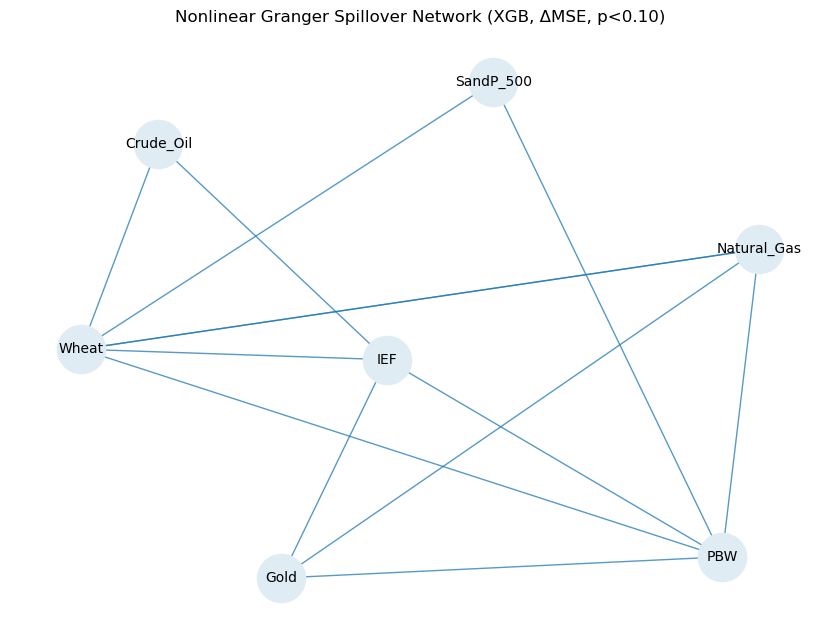

,out_strength,in_strength
PBW,23.405444,23.403541
IEF,16.782346,16.736255
Wheat,14.724716,14.767307
Crude_Oil,10.076123,10.084651
SandP_500,7.589401,7.588837
Gold,7.015776,7.017106
Natural_Gas,4.392918,4.389027


In [110]:
# ==== XGB-Granger nonlinear spillover network =================================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, networkx as nx
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from pandas.api.types import is_numeric_dtype

np.random.seed(RANDOM_SEED)

CSV_NET = "outputs/rolling/rolling_net_H10_W250_S5_fixed.csv"  # per-asset Net Spillovers
OUTDIR  = "outputs/causality/xgb_granger"
LAGS_CAUSAL = list(range(1, 11))  # use fewer lags for stability in causality map
N_SHIFTS = 50                     # block-permutation repetitions for p-values

os.makedirs(OUTDIR, exist_ok=True)

# -- load and align to merged calendar
net = pd.read_csv(CSV_NET, parse_dates=["Date"])
net.columns = [c.strip().replace(" ", "_").replace("/", "_").replace("&","and").replace("-", "_") for c in net.columns]
assets = [c for c in net.columns if c != "Date"]

df = merged[["Date"]].merge(net, on="Date", how="inner").sort_values("Date").reset_index(drop=True)

# helper: build lagged design
def lag_block(df, cols, lags):
    out = df[["Date"]].copy()
    for c in cols:
        for L in lags:
            out[f"{c}_lag{L}"] = df[c].shift(L)
    return out

design = lag_block(df, assets, LAGS_CAUSAL).dropna().reset_index(drop=True)
y_all = df.loc[df.index.isin(design.index), assets].reset_index(drop=True)  # contemporaneous targets

# simple time split for causality mapping (expanding train, final chunk test)
N = len(design)
n_test = max(120, int(0.2*N))
n_train = N - n_test
Xtr, Xte = design.iloc[:n_train, :].drop(columns=["Date"]), design.iloc[n_train:, :].drop(columns=["Date"])
dte = design.iloc[n_train:, :]["Date"] if "Date" in design.columns else df.loc[df.index.isin(design.index)].iloc[n_train:]["Date"]
Ytr, Yte = y_all.iloc[:n_train, :], y_all.iloc[n_train:, :]

# model config
def new_model():
    return XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist",
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        n_estimators=1000,
        random_state=RANDOM_SEED
    )

# circular shift utility over a set of columns (keeps autocorrelation but breaks alignment)
def circular_shift_cols(X, cols, k):
    Xs = X.copy()
    Xs.loc[:, cols] = Xs.loc[:, cols].shift(k, fill_value=np.nan).values
    # drop any resulting NaNs (shouldn't occur with fill_value), but guard anyway:
    if np.isnan(Xs[cols].to_numpy()).any():
        Xs = Xs.fillna(method="bfill").fillna(method="ffill")
    return Xs

# group columns by source asset lag block
block_cols = {a: [c for c in Xtr.columns if c.startswith(f"{a}_lag")] for a in assets}

W = pd.DataFrame(0.0, index=assets, columns=assets)    # ΔMSE matrix: rows = target i, cols = source j
P = pd.DataFrame(1.0, index=assets, columns=assets)    # empirical p-values

for i, target in enumerate(assets):
    # train model for target
    ytr = Ytr[target].values
    yte = Yte[target].values

    model = new_model()
    model.fit(Xtr, ytr, eval_set=[(Xte, yte)], verbose=False)
    base_pred = model.predict(Xte)
    base_mse  = mean_squared_error(yte, base_pred)

    for j, source in enumerate(assets):
        cols = block_cols[source]
        if not cols: 
            continue

        # repeated random circular shifts to get empirical ΔMSE distribution
        deltas = []
        T = len(Xte)
        valid_shifts = [k for k in range(5, T-5)]  # avoid near-zero shifts
        for r in range(N_SHIFTS):
            k = int(np.random.choice(valid_shifts))
            Xperm = Xte.copy()
            Xperm.loc[:, cols] = Xperm.loc[:, cols].shift(k, fill_value=np.nan).values
            # quick fill if any boundary NaNs:
            if np.isnan(Xperm[cols].to_numpy()).any():
                Xperm[cols] = Xperm[cols].bfill().ffill()
            pred_perm = model.predict(Xperm)
            deltas.append(mean_squared_error(yte, pred_perm) - base_mse)

        deltas = np.array(deltas)
        W.loc[target, source] = np.mean(deltas)                     # average ΔMSE
        P.loc[target, source] = np.mean(deltas <= 0.0)              # one-sided p ≈ P(Δ≤0) under null; small is good

# save matrices
W.to_csv(f"{OUTDIR}/xgb_granger_deltaMSE.csv")
P.to_csv(f"{OUTDIR}/xgb_granger_pvals.csv")
print("Saved:", f"{OUTDIR}/xgb_granger_deltaMSE.csv", f"{OUTDIR}/xgb_granger_pvals.csv")

# --- plot a network (threshold by p < 0.1 and positive ΔMSE) ---
thr_p = 0.10
Wpos = W.copy()
Wpos[P >= thr_p] = 0.0
Wpos[Wpos < 0] = 0.0

G = nx.DiGraph()
for a in assets:
    G.add_node(a)

# normalize weights for aesthetics
wmax = Wpos.values.max() if np.isfinite(Wpos.values).any() else 1.0
for i in assets:
    for j in assets:
        w = Wpos.loc[i, j]
        if i != j and w > 0:
            G.add_edge(j, i, weight=w, width=1.0 + 6.0*(w / (wmax + 1e-12)))

pos = nx.spring_layout(G, seed=RANDOM_SEED)
plt.figure(figsize=(8.5, 6.5))
nx.draw_networkx_nodes(G, pos, node_size=1200, node_color="#e0ecf4")
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos,
    arrows=True,
    width=[d["width"] for (_,_,d) in G.edges(data=True)],
    edge_color="#1f78b4",
    alpha=0.75
)
plt.title("Nonlinear Granger Spillover Network (XGB, ΔMSE, p<0.10)")
plt.axis("off")
plt.tight_layout()
plt.savefig(f"{OUTDIR}/xgb_granger_network.png", dpi=180)
plt.savefig(f"{OUTDIR}/xgb_granger_network.pdf")
plt.show()

# optional: centralities
cent = pd.DataFrame({
    "out_strength": Wpos.sum(axis=0),  # how much j influences others
    "in_strength":  Wpos.sum(axis=1),  # how much i is influenced by others
}).sort_values("out_strength", ascending=False)
cent.to_csv(f"{OUTDIR}/xgb_granger_centrality.csv")
cent.head(10)


In [126]:
# ==== Linking spillovers to returns/prices (clean + S&P_500 naming) ====
import os, re
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

# ---- config ----
CSV_PRICES = "all_assets_close_aligned.csv"   # Date + price columns (e.g., S&P_500, IEF, Gold, ...)
CSV_NET    = "outputs/rolling/rolling_net_H10_W250_S5_fixed.csv"  # per-asset Net Spillovers
CENT_PATH  = "outputs/causality/xgb_granger/xgb_granger_centrality.csv"       # from XGB-Granger step
OUTDIR     = "outputs/causal_link"
os.makedirs(OUTDIR, exist_ok=True)

# ---- helpers ----
def normcol(c: str) -> str:
    # normalize spacing and dashes; KEEP '&' so S&P_500 stays as is
    return (c.strip()
              .replace(" ", "_")
              .replace("/", "_")
              .replace("-", "_"))

def alias_asset(c: str) -> str:
    c = normcol(c)
    # unify any SandP_500 -> S&P_500 for consistency with price file
    return "S&P_500" if c == "SandP_500" else c

# ---- load & clean prices, compute log returns ----
assert os.path.exists(CSV_PRICES), f"Missing price file: {CSV_PRICES}"
px = pd.read_csv(CSV_PRICES, parse_dates=["Date"]).sort_values("Date").reset_index(drop=True)
px.columns = [alias_asset(col) if col != "Date" else "Date" for col in px.columns]

num_cols = [c for c in px.columns if c != "Date"]
for c in num_cols:
    s = px[c].astype(str)
    s = s.str.replace(",", "", regex=True)              # 1,234.56 -> 1234.56
    s = s.str.replace(r"[^\d\.\-eE]", "", regex=True)   # drop £, $, etc.
    px[c] = pd.to_numeric(s, errors="coerce")

# guard for non-positive prices: set NaN then ffill
for c in num_cols:
    px.loc[px[c] <= 0, c] = np.nan
px[num_cols] = px[num_cols].ffill()

prices = px.set_index("Date")[num_cols]
ret = np.log(prices).diff().dropna().reset_index()

print("Price columns detected:", prices.columns.tolist())

# ---- load centrality & standardize names ----
if not os.path.exists(CENT_PATH):
    raise FileNotFoundError(f"Centrality file not found: {CENT_PATH}")
cent = pd.read_csv(CENT_PATH)
# handle index-ish first column if present
if "Unnamed: 0" in cent.columns:
    cent = cent.rename(columns={"Unnamed: 0":"Asset"})
elif cent.columns[0].lower() in {"asset","index"}:
    cent = cent.rename(columns={cent.columns[0]:"Asset"})
cent["Asset"] = cent["Asset"].map(alias_asset)
cent = cent[["Asset","in_strength","out_strength"]]

# ---- features: Total Spillover + per-asset NET spillovers ----
feats = merged[["Date","Total_Spillover"]].copy()  # assumes 'merged' exists from your pipeline

net = pd.read_csv(CSV_NET, parse_dates=["Date"]).sort_values("Date")
net.columns = [alias_asset(c) if c != "Date" else "Date" for c in net.columns]
feats = feats.merge(net, on="Date", how="inner")

# ---- loop assets present in returns file ----
results = []
asset_list = [c for c in ret.columns if c != "Date"]

for asset in asset_list:
    # build target r_{t+1} for this asset
    df = feats.merge(ret[["Date", asset]].rename(columns={asset: "ret1"}), on="Date", how="inner").sort_values("Date")
    df["ret1"] = df["ret1"].shift(-1)

    # attach (static) centrality for this asset
    in_s  = cent.loc[cent["Asset"] == asset, "in_strength"]
    out_s = cent.loc[cent["Asset"] == asset, "out_strength"]
    df["in_strength"]  = float(in_s.iloc[0])  if len(in_s)  else 0.0
    df["out_strength"] = float(out_s.iloc[0]) if len(out_s) else 0.0

    # simple transforms
    df["Total_chg1"] = df["Total_Spillover"].diff(1)

    # asset-specific NET + change if available (column exists after aliasing)
    if asset in df.columns:
        df[f"{asset}_chg1"] = df[asset].diff(1)
        feat_cols = ["Total_Spillover","Total_chg1", asset, f"{asset}_chg1","in_strength","out_strength"]
    else:
        # NET series for this asset not present -> drop those two features
        feat_cols = ["Total_Spillover","Total_chg1","in_strength","out_strength"]

    X = df[feat_cols].copy()
    y = df["ret1"].copy()

    # align and drop NaNs
    data = pd.concat([X, y], axis=1).dropna()
    if len(data) < 200:
        print(f"[skip] {asset}: too few observations ({len(data)}) after alignment.")
        continue

    X = data[feat_cols]
    y = data["ret1"]

    # time split: last 25% test, at least 60 obs
    N = len(X)
    n_test = max(60, int(0.25 * N))
    n_train = N - n_test
    Xtr, Xte = X.iloc[:n_train], X.iloc[n_train:]
    ytr, yte = y.iloc[:n_train], y.iloc[n_train:]

    # --- OLS for OOS R^2 ---
    ols = LinearRegression().fit(Xtr, ytr)
    pred = ols.predict(Xte)
    oos_r2 = 1 - ((yte - pred) ** 2).sum() / ((yte - ytr.mean()) ** 2).sum()

    row = {"Asset": asset, "OOS_R2": float(oos_r2), "N_test": int(len(yte))}

    # --- optional: drawdown odds (ret1 < -1.5 * train std) ---
    thr = -1.5 * ytr.std()
    ytr_bin = (ytr < thr).astype(int)
    yte_bin = (yte < thr).astype(int)
    if ytr_bin.sum() >= 10 and ytr_bin.sum() < len(ytr_bin):  # need both classes
        clf = LogisticRegression(max_iter=200).fit(Xtr, ytr_bin)
        prob = clf.predict_proba(Xte)[:, 1]
        row.update({
            "AUC_drawdown": float(roc_auc_score(yte_bin, prob)),
            "ACC_drawdown": float(accuracy_score(yte_bin, (prob >= 0.5).astype(int)))
        })

    results.append(row)

# ---- save & show summary ----
res = pd.DataFrame(results).sort_values("Asset")
out_path = os.path.join(OUTDIR, "returns_link_summary.csv")
res.to_csv(out_path, index=False)
print(f"Saved returns link summary -> {out_path}")
display(res)


Price columns detected: ['S&P_500', 'IEF', 'Gold', 'Wheat', 'Natural_Gas', 'Crude_Oil', 'PBW']
Saved returns link summary -> outputs/causal_link/returns_link_summary.csv


,Asset,OOS_R2,N_test,AUC_drawdown,ACC_drawdown
5,Crude_Oil,-0.016885,241,0.446111,0.933610
2,Gold,-0.005053,241,0.351948,0.958506
1,IEF,-0.005459,241,0.459713,0.904564
4,Natural_Gas,-0.014600,241,0.478889,0.896266
6,PBW,0.007490,241,0.547585,0.892116
0,S&P_500,0.015056,241,0.612124,0.966805
3,Wheat,0.002301,241,0.513845,0.941909


In [9]:
# ==== Rolling XGB-Granger centrality (from NET only) ====
import os, numpy as np, pandas as pd, xgboost as xgb
from sklearn.metrics import mean_squared_error

CSV_NET = "outputs/rolling/rolling_net_H10_W250_S5_fixed.csv"
OUTDIR  = "outputs/causality/rolling_xgb_granger_from_net"
WINDOW, STEP = 300, 20          # faster & denser
LAGS_C = list(range(1, 6))      # keep modest
EVAL_LEN, N_SHIFTS = 40, 5
RANDOM_SEED = 42

os.makedirs(OUTDIR, exist_ok=True)

def alias_asset(c):
    c = c.strip().replace(" ", "_").replace("/", "_").replace("-", "_")
    return "S&P_500" if c == "SandP_500" else c

net = pd.read_csv(CSV_NET, parse_dates=["Date"]).sort_values("Date")
net.columns = [alias_asset(c) if c != "Date" else "Date" for c in net.columns]
assets = [c for c in net.columns if c != "Date"]

# compute ONLY from NET
df = net.sort_values("Date").reset_index(drop=True)
print("NET date range:", df["Date"].min().date(), "->", df["Date"].max().date())

def make_lags(df, cols, lags):
    out = df[["Date"]].copy()
    for c in cols:
        for L in lags:
            out[f"{c}_lag{L}"] = df[c].shift(L)
    return out

def fit_model(Xtr, ytr, Xev, yev):
    m = xgb.XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist",
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        n_estimators=400,
        n_jobs=-1,
        random_state=RANDOM_SEED,
    )
    best = None

    # Try modern early stopping via callbacks (version-safe)
    try:
        es = xgb.callback.EarlyStopping(rounds=50, save_best=True)
        m.fit(Xtr, ytr, eval_set=[(Xev, yev)], eval_metric="rmse",
              callbacks=[es], verbose=False)
        best = getattr(m, "best_iteration_", None)
    except Exception:
        # Fallback: fit without callbacks (no early stopping)
        try:
            m.fit(Xtr, ytr, eval_set=[(Xev, yev)], eval_metric="rmse", verbose=False)
            # some versions expose best_ntree_limit on the booster
            best = getattr(m.get_booster(), "best_ntree_limit", None)
        except Exception:
            m.fit(Xtr, ytr, verbose=False)

    def predict(X):
        # Prefer iteration_range if supported
        try:
            if best is not None:
                return m.predict(X, iteration_range=(0, best + 1))
        except TypeError:
            pass
        # Otherwise use ntree_limit if available
        try:
            if best is not None:
                return m.predict(X, ntree_limit=best + 1)
        except Exception:
            pass
        # Final fallback
        return m.predict(X)

    return m, predict


rows = []
for end in range(WINDOW, len(df)+1, STEP):
    df_win = df.iloc[end-WINDOW:end]
    lagged = make_lags(df_win, assets, LAGS_C).dropna()       # keep index
    if len(lagged) < EVAL_LEN + 80: 
        continue
    Y = df_win.loc[lagged.index, assets].sort_index()
    X = lagged.sort_index().drop(columns=["Date"])

    Xtr, Xev = X.iloc[:-EVAL_LEN, :], X.iloc[-EVAL_LEN:, :]
    Ytr, Yev = Y.iloc[:-EVAL_LEN, :], Y.iloc[-EVAL_LEN:, :]

    # precompute numpy arrays for fast permutations
    Xev_np = Xev.values
    idx_map = {a: X.columns.get_indexer([c for c in X.columns if c.startswith(f"{a}_lag")]) for a in assets}

    out_s = {a: 0.0 for a in assets}
    in_s  = {a: 0.0 for a in assets}

    for target in assets:
        ytr = Ytr[target].to_numpy(); yev = Yev[target].to_numpy()
        model, predict = fit_model(Xtr, ytr, Xev, yev)
        base_pred = predict(Xev)
        base_mse  = mean_squared_error(yev, base_pred)

        for source in assets:
            idx = idx_map[source]
            if len(idx) == 0: 
                continue
            T = len(Xev_np)
            if T < 10: 
                continue
            valid_shifts = np.arange(5, max(6, T-5))
            deltas = []
            for _ in range(N_SHIFTS):
                k = int(np.random.choice(valid_shifts))
                Xp = Xev_np.copy()
                Xp[:, idx] = np.roll(Xp[:, idx], shift=k, axis=0)
                predp = predict(Xp)
                deltas.append(mean_squared_error(yev, predp) - base_mse)
            delta = float(np.mean(deltas))
            if delta > 0:
                out_s[source] += delta
                in_s[target]  += delta

    asof = df_win["Date"].iloc[-1]
    for a in assets:
        rows.append({"Date": asof, "Asset": a, "out_strength": out_s[a], "in_strength": in_s[a]})

roll_long = pd.DataFrame(rows).sort_values(["Date","Asset"]).reset_index(drop=True)
roll_long.to_csv(f"{OUTDIR}/rolling_centrality_long_w{WINDOW}_s{STEP}.csv", index=False)

out_wide = roll_long.pivot(index="Date", columns="Asset", values="out_strength").sort_index()
in_wide  = roll_long.pivot(index="Date", columns="Asset", values="in_strength").sort_index()
out_wide.to_csv(f"{OUTDIR}/rolling_out_strength_w{WINDOW}_s{STEP}.csv")
in_wide.to_csv(f"{OUTDIR}/rolling_in_strength_w{WINDOW}_s{STEP}.csv")

print("Saved to:", OUTDIR)
print("Centrality date range:", out_wide.index.min().date(), "->", out_wide.index.max().date(), "points:", len(out_wide))


NET date range: 2006-03-13 -> 2025-06-24
Saved to: outputs/causality/rolling_xgb_granger_from_net
Centrality date range: 2012-02-24 -> 2025-04-17 points: 34


In [180]:
# ==== Event classification using rolling centralities =====================================
import os, numpy as np, pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, balanced_accuracy_score

# ---- config / inputs ----
PRICES_CSV = "all_assets_close_aligned.csv"   # same file you used earlier
NET_CSV    = "outputs/rolling/rolling_net_H10_W250_S5_fixed.csv"
CENT_DIR   = "outputs/causality/rolling_xgb_granger"
OUTDIR     = "outputs/causal_link"
K_SIGMA    = 1.5   # event threshold in std dev
TEST_FRAC  = 0.25  # time split

os.makedirs(OUTDIR, exist_ok=True)

def alias_asset(c: str) -> str:
    c = (c.strip().replace(" ", "_").replace("/", "_").replace("-", "_"))
    return "S&P_500" if c == "SandP_500" else c

# --- load returns (recompute safely)
px = pd.read_csv(PRICES_CSV, parse_dates=["Date"]).sort_values("Date")
px.columns = [alias_asset(c) if c != "Date" else "Date" for c in px.columns]
num_cols = [c for c in px.columns if c != "Date"]
for c in num_cols:
    s = px[c].astype(str).str.replace(",", "", regex=True).str.replace(r"[^\d\.\-eE]", "", regex=True)
    px[c] = pd.to_numeric(s, errors="coerce")
px[num_cols] = px[num_cols].where(px[num_cols] > 0).ffill()

ret = np.log(px.set_index("Date")[num_cols]).diff().dropna().reset_index()

# --- load rolling centralities (wide)
out_wide = pd.read_csv(max([os.path.join(CENT_DIR, f) for f in os.listdir(CENT_DIR) if f.startswith("rolling_out_strength_")], key=os.path.getmtime))
in_wide  = pd.read_csv(max([os.path.join(CENT_DIR, f) for f in os.listdir(CENT_DIR) if f.startswith("rolling_in_strength_")], key=os.path.getmtime))
out_wide["Date"] = pd.to_datetime(out_wide["Date"]); in_wide["Date"] = pd.to_datetime(in_wide["Date"])

# --- spillover features (Total + NET)
feats = merged[["Date","Total_Spillover"]].copy().sort_values("Date")
net   = pd.read_csv(NET_CSV, parse_dates=["Date"]).sort_values("Date")
net.columns = [alias_asset(c) if c != "Date" else "Date" for c in net.columns]
feats = feats.merge(net, on="Date", how="inner")

# --- merge centralities (align by Date; forward-fill between steps)
Xcent = out_wide.merge(in_wide, on="Date", how="outer", suffixes=("_out","_in")).sort_values("Date")
Xcent = Xcent.ffill()  # carry forward centralities until next window point

results = []
assets = [c for c in ret.columns if c != "Date"]

for asset in assets:
    # features at time t
    df = feats.merge(Xcent, on="Date", how="left").merge(ret[["Date", asset]].rename(columns={asset:"ret"}), on="Date", how="inner")
    df = df.sort_values("Date").reset_index(drop=True)

    # simple deltas
    df["Total_chg1"] = df["Total_Spillover"].diff(1)
    if asset in df.columns:
        df[f"{asset}_chg1"] = df[asset].diff(1)
    # centrality deltas (per asset) if present
    if asset in Xcent.columns:
        df[f"{asset}_out_chg1"] = df[f"{asset}_out"].diff(1)
        df[f"{asset}_in_chg1"]  = df[f"{asset}_in"].diff(1)

    # targets at t+1
    df["ret_fwd"] = df["ret"].shift(-1)

    # threshold from train std later; for now build feature matrix
    base_cols = ["Total_Spillover","Total_chg1"]
    opt_cols  = []
    if asset in df.columns:
        opt_cols += [asset, f"{asset}_chg1"]
    if asset in Xcent.columns:
        opt_cols += [f"{asset}_out", f"{asset}_in", f"{asset}_out_chg1", f"{asset}_in_chg1"]

    feat_cols = base_cols + [c for c in opt_cols if c in df.columns]

    data = df[["Date","ret_fwd"] + feat_cols].dropna().reset_index(drop=True)
    if len(data) < 300:
        print(f"[skip] {asset}: too few rows after alignment ({len(data)}).")
        continue

    # time split
    N = len(data); n_test = max(60, int(TEST_FRAC * N)); n_train = N - n_test
    tr, te = data.iloc[:n_train], data.iloc[n_train:]

    # event targets using train std (to prevent look-ahead)
    sigma = tr["ret_fwd"].std()
    y_tr = (tr["ret_fwd"] < -K_SIGMA * sigma).astype(int).values
    y_te = (te["ret_fwd"] < -K_SIGMA * sigma).astype(int).values

    X_tr = tr[feat_cols].values
    X_te = te[feat_cols].values

    # logistic classifier (simple & stable)
    clf = LogisticRegression(max_iter=500).fit(X_tr, y_tr)
    prob = clf.predict_proba(X_te)[:,1]
    pred = (prob >= 0.5).astype(int)

    # metrics
    event_rate = y_te.mean()
    roc  = roc_auc_score(y_te, prob) if y_te.sum() and (1-y_te).sum() else np.nan
    pr   = average_precision_score(y_te, prob) if y_te.sum() else np.nan   # PR-AUC (AP); baseline = event_rate
    bacc = balanced_accuracy_score(y_te, pred)

    results.append({
        "Asset": asset,
        "N_train": int(len(tr)), "N_test": int(len(te)),
        "EventRate_test": float(event_rate),
        "ROC_AUC": float(roc) if roc==roc else np.nan,
        "PR_AUC": float(pr) if pr==pr else np.nan,
        "PR_baseline": float(event_rate),   # no-skill baseline for PR-AUC
        "Balanced_ACC": float(bacc)
    })

res = pd.DataFrame(results).sort_values("Asset")
out_path = os.path.join(OUTDIR, "event_classification_with_rolling_centrality.csv")
res.to_csv(out_path, index=False)
print("Saved ->", out_path)
display(res)


Saved -> outputs/causal_link/event_classification_with_rolling_centrality.csv


,Asset,N_train,N_test,EventRate_test,ROC_AUC,PR_AUC,PR_baseline,Balanced_ACC
5,Crude_Oil,725,241,0.066390,0.446389,0.099203,0.066390,0.5
2,Gold,725,241,0.041494,0.350216,0.032968,0.041494,0.5
1,IEF,725,241,0.095436,0.460511,0.091865,0.095436,0.5
4,Natural_Gas,725,241,0.103734,0.478889,0.140585,0.103734,0.5
6,PBW,725,241,0.107884,0.547585,0.153297,0.107884,0.5
0,S&P_500,725,241,0.033195,0.609979,0.057926,0.033195,0.5
3,Wheat,725,241,0.058091,0.514160,0.060613,0.058091,0.5


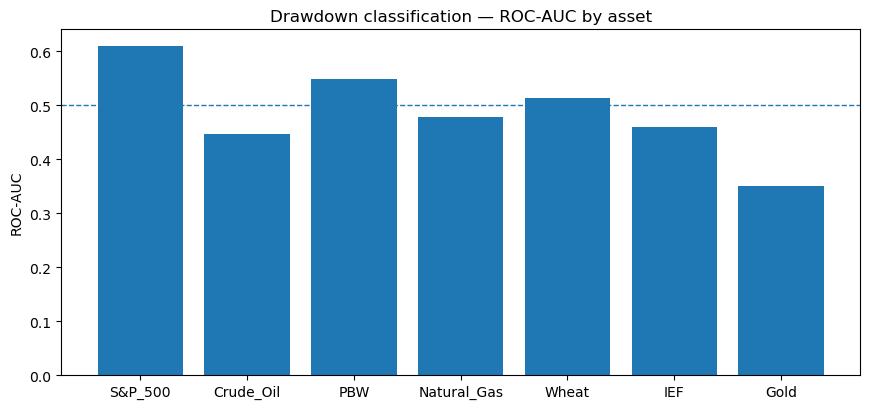

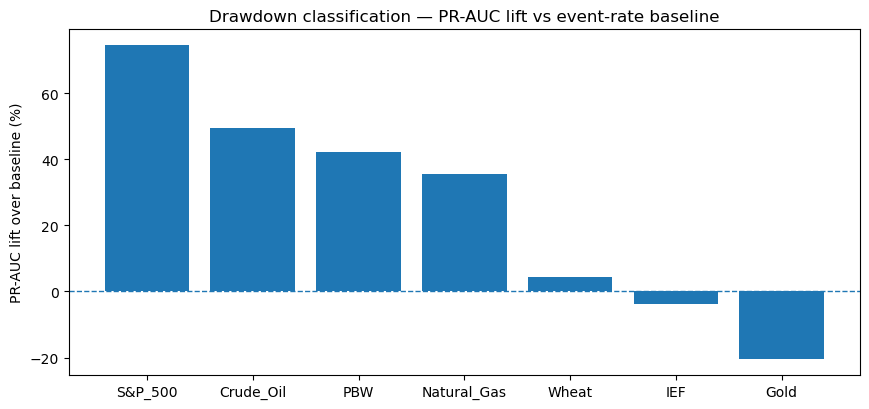

Saved figures + LaTeX -> outputs/diss_assets


In [161]:
# ==== Diss pack: event metrics charts + LaTeX table ====
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt

IN  = "outputs/causal_link/event_classification_with_rolling_centrality.csv"
OUT = "outputs/diss_assets"
os.makedirs(OUT, exist_ok=True)

df = pd.read_csv(IN)
df["PR_Lift_%"] = (df["PR_AUC"] / df["PR_baseline"] - 1.0) * 100.0

# order by PR lift, descending
df_plot = df.sort_values("PR_Lift_%", ascending=False)

# 1) ROC-AUC bar
plt.figure(figsize=(8.8, 4.2))
plt.bar(df_plot["Asset"], df_plot["ROC_AUC"])
plt.axhline(0.5, linestyle="--", linewidth=1)
plt.ylabel("ROC-AUC")
plt.title("Drawdown classification — ROC-AUC by asset")
plt.tight_layout()
plt.savefig(os.path.join(OUT, "event_roc_auc_by_asset.png"), dpi=200)
plt.savefig(os.path.join(OUT, "event_roc_auc_by_asset.pdf"))
plt.show()

# 2) PR-AUC lift vs baseline
plt.figure(figsize=(8.8, 4.2))
plt.bar(df_plot["Asset"], df_plot["PR_Lift_%"])
plt.axhline(0, linestyle="--", linewidth=1)
plt.ylabel("PR-AUC lift over baseline (%)")
plt.title("Drawdown classification — PR-AUC lift vs event-rate baseline")
plt.tight_layout()
plt.savefig(os.path.join(OUT, "event_pr_auc_lift_by_asset.png"), dpi=200)
plt.savefig(os.path.join(OUT, "event_pr_auc_lift_by_asset.pdf"))
plt.show()

# 3) LaTeX table (pretty)
tbl = df.copy()
fmt = lambda x: f"{x:.3f}"
tbl["EventRate_test"] = tbl["EventRate_test"].map(fmt)
for c in ["ROC_AUC","PR_AUC","PR_baseline","OOS_R2","Balanced_ACC"]:
    if c in tbl.columns:
        tbl[c] = tbl[c].map(lambda x: "" if pd.isna(x) else f"{x:.3f}")
tbl["PR_Lift_%"] = tbl["PR_Lift_%"].map(lambda x: "" if pd.isna(x) else f"{x:.1f}")

cols = ["Asset","N_train","N_test","EventRate_test","ROC_AUC","PR_AUC","PR_baseline","PR_Lift_%","Balanced_ACC"]
tex_path = os.path.join(OUT, "event_metrics_summary.tex")
tbl[cols].to_latex(tex_path, index=False, escape=False)
print("Saved figures + LaTeX ->", OUT)


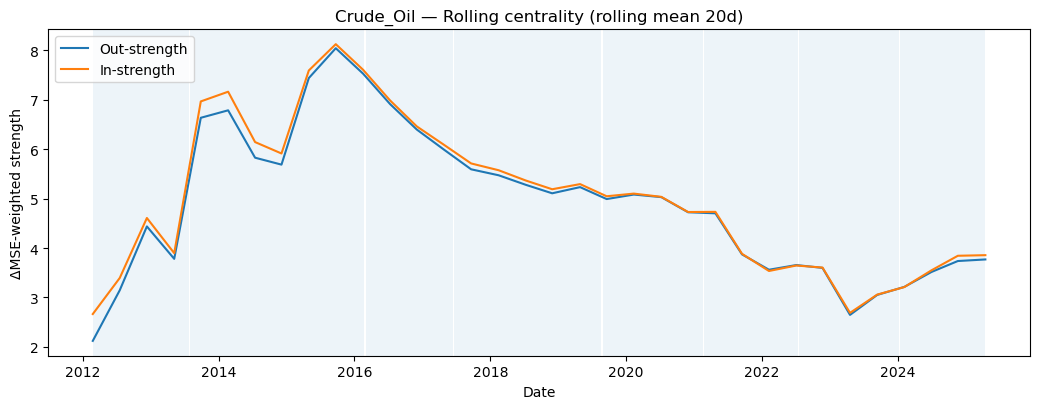

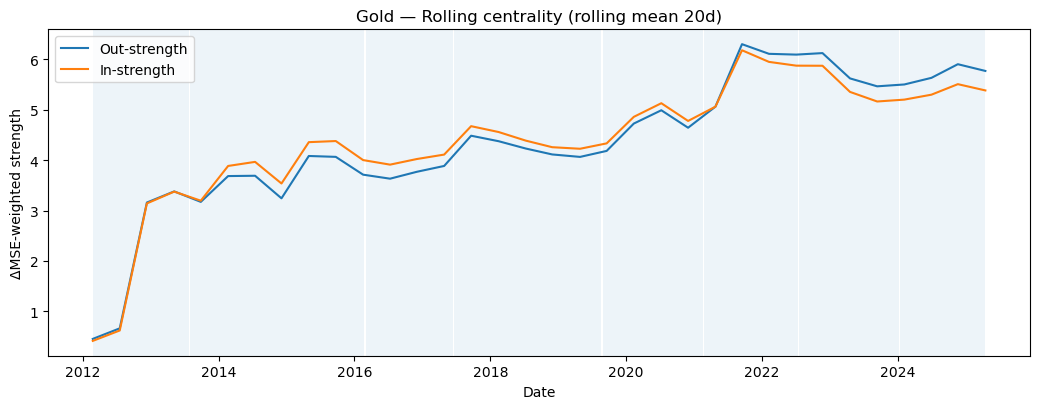

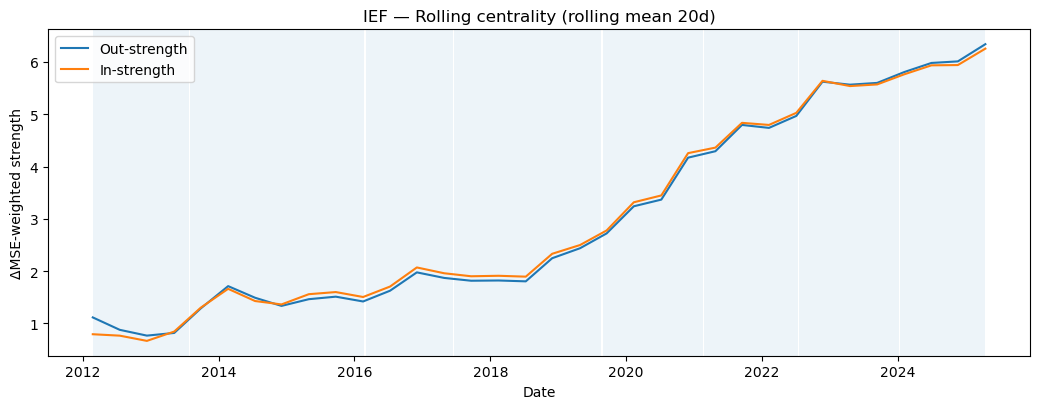

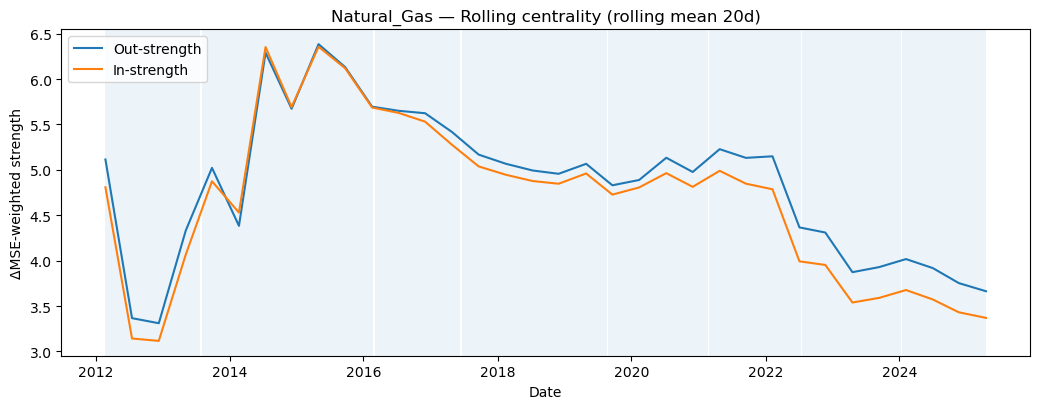

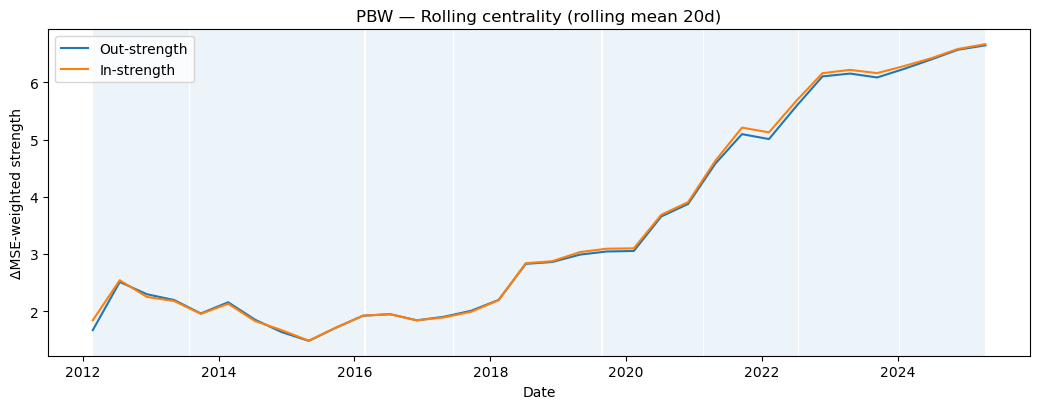

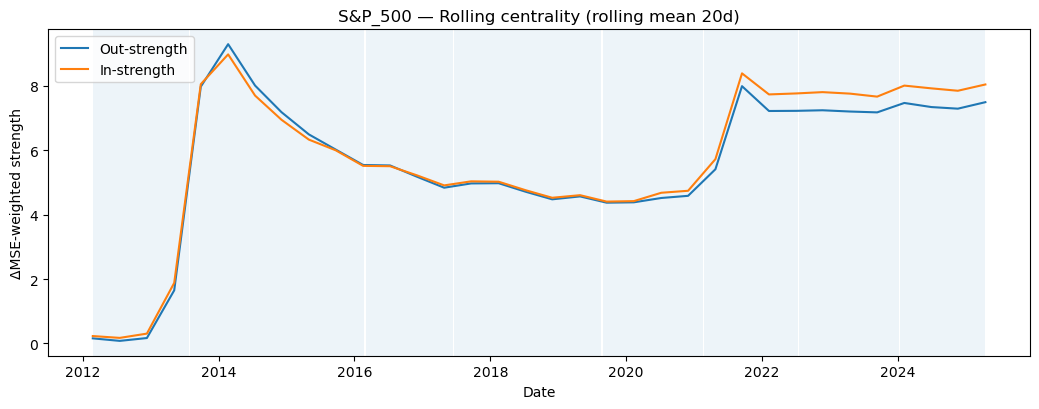

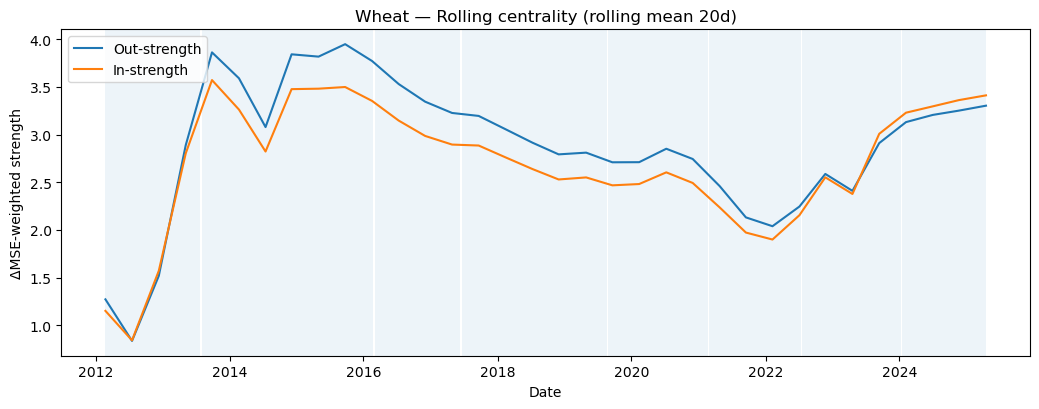

Saved plots to: outputs/causality/rolling_xgb_granger_from_net/plots


In [163]:
# ==== Plot rolling centrality with regime overlays (no clipping) ====
import os, glob, pandas as pd, numpy as np, matplotlib.pyplot as plt

CENT_DIR = "outputs/causality/rolling_xgb_granger_from_net"
OUTDIR   = os.path.join(CENT_DIR, "plots")
SMOOTH   = 20
USE_MS   = True
os.makedirs(OUTDIR, exist_ok=True)

def latest(globpat):
    files = glob.glob(globpat)
    if not files:
        raise FileNotFoundError(globpat)
    return max(files, key=os.path.getmtime)

out_wide = pd.read_csv(latest(os.path.join(CENT_DIR, "rolling_out_strength_*.csv")), parse_dates=["Date"]).sort_values("Date")
in_wide  = pd.read_csv(latest(os.path.join(CENT_DIR, "rolling_in_strength_*.csv")),  parse_dates=["Date"]).sort_values("Date")
assets = [c for c in out_wide.columns if c != "Date" and c in in_wide.columns]

# regimes (optional) – we won't align to merged; just overlay spans where they exist
reg_key = "Regime_MS" if USE_MS and "Regime_MS" in merged.columns else ("Regime_SegID" if "Regime_SegID" in merged.columns else None)
reg_blocks = []
if reg_key is not None:
    r = merged[["Date", reg_key]].dropna().sort_values("Date")
    r[reg_key] = r[reg_key].astype(int)
    dates, vals = r["Date"].values, r[reg_key].values
    start = 0
    for i in range(1, len(vals)):
        if vals[i] != vals[i-1]:
            reg_blocks.append((dates[start], dates[i-1], int(vals[i-1])))
            start = i
    reg_blocks.append((dates[start], dates[-1], int(vals[-1])))

for a in assets:
    df = out_wide[["Date", a]].merge(in_wide[["Date", a]].rename(columns={a:"in_strength"}), on="Date", how="inner")
    df = df.rename(columns={a:"out_strength"}).sort_values("Date").dropna()

    if SMOOTH and SMOOTH > 1:
        df["out_s"] = df["out_strength"].rolling(SMOOTH, min_periods=1).mean()
        df["in_s"]  = df["in_strength"].rolling(SMOOTH,  min_periods=1).mean()
        y1, y2 = "out_s", "in_s"
        title_suffix = f" (rolling mean {SMOOTH}d)"
    else:
        y1, y2 = "out_strength", "in_strength"
        title_suffix = ""

    fig, ax = plt.subplots(figsize=(10.5, 4.2))
    ax.plot(df["Date"], df[y1], label="Out-strength")
    ax.plot(df["Date"], df[y2], label="In-strength")

    # overlay regimes if their dates overlap; do not clip centralities
    if reg_blocks:
        ymin, ymax = ax.get_ylim()
        for s, e, lab in reg_blocks:
            # only draw spans that intersect our time range
            if e < df["Date"].min() or s > df["Date"].max():
                continue
            ax.axvspan(max(s, df["Date"].min()), min(e, df["Date"].max()), alpha=0.08)
        ax.set_ylim(ymin, ymax)

    ax.set_title(f"{a} — Rolling centrality{title_suffix}")
    ax.set_xlabel("Date"); ax.set_ylabel("ΔMSE-weighted strength"); ax.legend(loc="upper left")
    fig.tight_layout()
    base = os.path.join(OUTDIR, f"{a}_centrality_{'noClip'}")
    fig.savefig(base + ".png", dpi=200); fig.savefig(base + ".pdf")
    plt.show()

print("Saved plots to:", OUTDIR)


In [165]:
# ==== Risk-managed backtest (threshold selection + summary) ====================
import os, glob, numpy as np, pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    f1_score, precision_score, recall_score, balanced_accuracy_score
)

# -------- config --------
PRICES_CSV = "all_assets_close_aligned.csv"
NET_CSV    = "outputs/rolling/rolling_net_H10_W250_S5_fixed.csv"
CENT_DIRS  = [
    "outputs/causality/rolling_xgb_granger_from_net",
    "outputs/causality/rolling_xgb_granger"  # fallback
]
OUTDIR     = "outputs/causal_link/backtests"
K_SIGMA    = 1.5     # drawdown threshold: r_{t+1} < -K_SIGMA * std(train)
TEST_FRAC  = 0.25    # last fraction of sample used as test
VAL_FRAC   = 0.20    # last fraction of the *train* used to pick threshold
COST_BPS   = 1.0     # per-side transaction cost (bps of notional)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
os.makedirs(OUTDIR, exist_ok=True)

# -------- helpers --------
def alias_asset(c: str) -> str:
    c = (c.strip().replace(" ", "_").replace("/", "_").replace("-", "_"))
    return "S&P_500" if c == "SandP_500" else c

def latest(path_glob):
    files = glob.glob(path_glob)
    if not files:
        return None
    return max(files, key=os.path.getmtime)

def load_latest_centrality():
    out, inn = None, None
    for d in CENT_DIRS:
        if not os.path.isdir(d): 
            continue
        out = latest(os.path.join(d, "rolling_out_strength_*.csv"))
        inn = latest(os.path.join(d, "rolling_in_strength_*.csv"))
        if out and inn:
            print(f"[info] centrality from: {d}")
            out_w = pd.read_csv(out, parse_dates=["Date"]).sort_values("Date")
            in_w  = pd.read_csv(inn, parse_dates=["Date"]).sort_values("Date")
            return out_w, in_w
    raise FileNotFoundError("No rolling centrality files found in CENT_DIRS.")

def max_drawdown(log_ret_series: pd.Series):
    """log_ret_series: daily log returns; returns max DD as negative number."""
    equity = np.exp(log_ret_series.cumsum())
    peak   = equity.cummax()
    dd     = equity/peak - 1.0
    return float(dd.min())

# -------- load returns --------
assert os.path.exists(PRICES_CSV), f"Missing price file: {PRICES_CSV}"
px = pd.read_csv(PRICES_CSV, parse_dates=["Date"]).sort_values("Date").reset_index(drop=True)
px.columns = [alias_asset(c) if c != "Date" else "Date" for c in px.columns]
num_cols = [c for c in px.columns if c != "Date"]
for c in num_cols:
    s = px[c].astype(str).str.replace(",", "", regex=True).str.replace(r"[^\d\.\-eE]", "", regex=True)
    px[c] = pd.to_numeric(s, errors="coerce")
px[num_cols] = px[num_cols].where(px[num_cols] > 0).ffill()
ret = np.log(px.set_index("Date")[num_cols]).diff().dropna().reset_index()

# -------- load features: Total + NET + rolling centralities --------
# Total_Spillover from 'merged' if present; else try CSV_TOTAL_SPILLOVER path
if "merged" in globals() and isinstance(merged, pd.DataFrame) and "Total_Spillover" in merged.columns:
    feats = merged[["Date","Total_Spillover"]].copy().sort_values("Date")
else:
    # fallback (edit the path if needed)
    CSV_TOTAL_SPILLOVER = "outputs/rolling/rolling_total_H10_W250_S5_fixed.csv"
    tmp = pd.read_csv(CSV_TOTAL_SPILLOVER, parse_dates=["Date"])
    feats = tmp[["Date","Total_Spillover"]].copy().sort_values("Date")

net = pd.read_csv(NET_CSV, parse_dates=["Date"]).sort_values("Date")
net.columns = [alias_asset(c) if c != "Date" else "Date" for c in net.columns]
feats = feats.merge(net, on="Date", how="inner")

out_wide, in_wide = load_latest_centrality()
Xcent = out_wide.merge(in_wide, on="Date", how="outer", suffixes=("_out","_in")).sort_values("Date").ffill()

# -------- backtest per asset --------
rows = []
thr_rows = []

assets = [c for c in ret.columns if c != "Date"]
for asset in assets:
    # Build dataset at time t to predict r_{t+1}
    df = feats.merge(Xcent, on="Date", how="left")\
              .merge(ret[["Date", asset]].rename(columns={asset:"ret"}), on="Date", how="inner")\
              .sort_values("Date").reset_index(drop=True)

    # Feature engineering
    df["Total_chg1"] = df["Total_Spillover"].diff(1)
    if asset in df.columns:
        df[f"{asset}_chg1"] = df[asset].diff(1)
    if asset in Xcent.columns:
        df[f"{asset}_out_chg1"] = df[f"{asset}_out"].diff(1)
        df[f"{asset}_in_chg1"]  = df[f"{asset}_in"].diff(1)
    df["ret_fwd"] = df["ret"].shift(-1)

    base_cols = ["Total_Spillover","Total_chg1"]
    opt_cols  = []
    if asset in df.columns:
        opt_cols += [asset, f"{asset}_chg1"]
    if asset in Xcent.columns:
        opt_cols += [f"{asset}_out", f"{asset}_in", f"{asset}_out_chg1", f"{asset}_in_chg1"]
    feat_cols = [c for c in base_cols + opt_cols if c in df.columns]

    data = df[["Date","ret_fwd"] + feat_cols].dropna().reset_index(drop=True)
    if len(data) < 400:
        print(f"[skip] {asset}: too few observations ({len(data)}).")
        continue

    # Splits
    N = len(data); n_test = max(60, int(TEST_FRAC * N)); n_train = N - n_test
    train = data.iloc[:n_train].copy()
    test  = data.iloc[n_train:].copy()

    # Event threshold from train std
    sigma = train["ret_fwd"].std()
    y_tr = (train["ret_fwd"] < -K_SIGMA * sigma).astype(int).values

    # Train/val within training for threshold selection
    n_val = max(40, int(VAL_FRAC * len(train)))
    tr_sub = train.iloc[:-n_val]
    va_sub = train.iloc[-n_val:]

    y_tr_sub = (tr_sub["ret_fwd"] < -K_SIGMA * sigma).astype(int).values
    y_va_sub = (va_sub["ret_fwd"] < -K_SIGMA * sigma).astype(int).values

    X_tr_sub = tr_sub[feat_cols].values
    X_va_sub = va_sub[feat_cols].values
    X_tr     = train[feat_cols].values
    X_te     = test[feat_cols].values

    # Fit logistic on sub-train, pick τ on val by max F1
    clf = LogisticRegression(max_iter=500).fit(X_tr_sub, y_tr_sub)
    prob_val = clf.predict_proba(X_va_sub)[:,1]
    prec, rec, thr = precision_recall_curve(y_va_sub, prob_val)
    f1 = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0)
    if len(thr) == 0:
        tau = 0.5
    else:
        tau = float(thr[np.argmax(f1)])

    # Refit on full training
    clf = LogisticRegression(max_iter=500).fit(X_tr, y_tr)
    prob_te = clf.predict_proba(X_te)[:,1]
    y_te = (test["ret_fwd"] < -K_SIGMA * sigma).astype(int).values

    # Classification metrics (test)
    roc  = roc_auc_score(y_te, prob_te) if y_te.sum() and (1-y_te).sum() else np.nan
    pr   = average_precision_score(y_te, prob_te) if y_te.sum() else np.nan
    yhat = (prob_te >= tau).astype(int)
    prec_at = precision_score(y_te, yhat, zero_division=0)
    rec_at  = recall_score(y_te, yhat, zero_division=0)
    bacc    = balanced_accuracy_score(y_te, yhat)

    # Strategy: long/cash (flat when alert)
    pos = (prob_te < tau).astype(int)  # 1 hold, 0 cash
    # transaction cost on position changes (approx, per change)
    changes = np.abs(pd.Series(pos).diff().fillna(0))
    tc = changes * (COST_BPS / 1e4)   # convert bps to fraction; applied to log returns approx

    strat_logret = pos * test["ret_fwd"].to_numpy() - tc.to_numpy()
    bh_logret    = test["ret_fwd"].to_numpy()

    # Performance summary
    mu_s = strat_logret.mean();  sd_s = strat_logret.std(ddof=0)
    mu_b = bh_logret.mean();     sd_b = bh_logret.std(ddof=0)
    ann_ret_s = float(np.exp(mu_s*252)-1)
    ann_ret_b = float(np.exp(mu_b*252)-1)
    ann_vol_s = float(sd_s*np.sqrt(252))
    ann_vol_b = float(sd_b*np.sqrt(252))
    sharpe_s  = float((mu_s/sd_s)*np.sqrt(252)) if sd_s>0 else np.nan
    sharpe_b  = float((mu_b/sd_b)*np.sqrt(252)) if sd_b>0 else np.nan
    mdd_s = max_drawdown(pd.Series(strat_logret))
    mdd_b = max_drawdown(pd.Series(bh_logret))

    rows.append({
        "Asset": asset,
        "N_test": int(len(test)),
        "EventRate_test": float(y_te.mean()),
        "Tau": tau,
        "ROC_AUC": float(roc) if roc==roc else np.nan,
        "PR_AUC": float(pr) if pr==pr else np.nan,
        "Prec@Tau": float(prec_at),
        "Rec@Tau": float(rec_at),
        "Alerts_%": float(100*yhat.mean()),
        "AnnRet_Strategy": ann_ret_s,
        "AnnVol_Strategy": ann_vol_s,
        "Sharpe_Strategy": sharpe_s,
        "MaxDD_Strategy": mdd_s,
        "AnnRet_BH": ann_ret_b,
        "AnnVol_BH": ann_vol_b,
        "Sharpe_BH": sharpe_b,
        "MaxDD_BH": mdd_b,
        "Ret_Lift_pp": float(100*(ann_ret_s - ann_ret_b)),
        "DD_Reduction_pp": float(100*(mdd_b - mdd_s))
    })

    # Save per-asset predictions
    out_pred = pd.DataFrame({
        "Date": test["Date"].values,
        "ret_fwd": test["ret_fwd"].values,
        "prob": prob_te,
        "alert": yhat,
        "position": pos,
        "logret_strategy": strat_logret,
        "logret_bh": bh_logret
    })
    out_pred.to_csv(os.path.join(OUTDIR, f"{asset}_preds.csv"), index=False)
    thr_rows.append({"Asset": asset, "Tau": tau})

# -------- save & display summary --------
summary = pd.DataFrame(rows).sort_values("Asset")
summary.to_csv(os.path.join(OUTDIR, "summary.csv"), index=False)
pd.DataFrame(thr_rows).to_csv(os.path.join(OUTDIR, "thresholds.csv"), index=False)

print(f"Saved backtest summary -> {OUTDIR}/summary.csv")
print(f"Saved thresholds -> {OUTDIR}/thresholds.csv")
display(summary)


[info] centrality from: outputs/causality/rolling_xgb_granger_from_net
Saved backtest summary -> outputs/causal_link/backtests/summary.csv
Saved thresholds -> outputs/causal_link/backtests/thresholds.csv


,Asset,N_test,EventRate_test,Tau,ROC_AUC,PR_AUC,Prec@Tau,Rec@Tau,Alerts_%,AnnRet_Strategy,AnnVol_Strategy,Sharpe_Strategy,MaxDD_Strategy,AnnRet_BH,AnnVol_BH,Sharpe_BH,MaxDD_BH,Ret_Lift_pp,DD_Reduction_pp
5,Crude_Oil,241,0.066390,0.033290,0.446389,0.099203,0.052239,0.437500,55.601660,-0.465920,0.334470,-1.875234,-0.486848,-0.609924,0.412571,-2.281826,-0.603267,14.400384,-11.641881
2,Gold,241,0.041494,0.111805,0.350216,0.032968,0.000000,0.000000,0.000000,-0.034807,0.153352,-0.231020,-0.123460,-0.034807,0.153352,-0.231020,-0.123460,0.000000,0.000000
1,IEF,241,0.095436,0.021731,0.460511,0.091865,0.087719,0.434783,47.302905,-0.071733,0.052605,-1.414977,-0.091244,-0.107412,0.077264,-1.470662,-0.109851,3.567899,-1.860727
4,Natural_Gas,241,0.103734,0.056919,0.478889,0.140585,0.109244,0.520000,49.377593,1.882201,0.499050,2.121140,-0.199210,2.965805,0.701049,1.965209,-0.347444,-108.360323,-14.823467
6,PBW,241,0.107884,0.057199,0.547585,0.153297,0.250000,0.038462,1.659751,-0.287834,0.422910,-0.802638,-0.494548,-0.312511,0.425006,-0.881659,-0.513854,2.467771,-1.930568
0,S&P_500,241,0.033195,0.039887,0.609979,0.057926,0.045802,0.750000,54.356846,0.016781,0.106937,0.155622,-0.135938,-0.002731,0.167792,-0.016296,-0.167904,1.951166,-3.196612
3,Wheat,241,0.058091,0.033159,0.514160,0.060613,0.027027,0.142857,30.705394,-0.234311,0.271486,-0.983401,-0.306209,-0.379776,0.315852,-1.512336,-0.413223,14.546476,-10.701453


In [21]:
import pandas as pd

# Xtr, Xte must be the same feature engineering you trained with.
# If Date is a column, set it as index; if it's already the index, this will no-op.

X_all = pd.concat([Xtr, Xte], axis=0).sort_index()

if not isinstance(X_all.index, pd.DatetimeIndex):
    if "Date" in X_all.columns:
        X_all["Date"] = pd.to_datetime(X_all["Date"])
        X_all = X_all.set_index("Date").sort_index()
    else:
        raise ValueError("Need a Date index or a 'Date' column.")

X_all.to_csv("outputs/ml/features_full.csv")
print("Saved -> outputs/ml/features_full.csv", X_all.shape)


ValueError: Need a Date index or a 'Date' column.